# **Домашнее задание №1 (pro). Часть 1**

В этом домашнем задании (его первой части) вам будет необходимо:
*  обучить модель регрессии для предсказания стоимости автомобилей;


> Оценка за первую часть домашки = $min(\text{ваш балл}, 7)$



**Примечание**

В каждой части оцениваются как код, **так и ответы на вопросы.** Вопросы подсвечены синим цветом.

Если нет одного и/или другого, то часть баллов за соответствующее задание снимается.

In [1]:
!pip install ydata_profiling

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.7/398.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 62.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.7/679.7 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.4/105.4 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.3/43.3 kB 3.6 MB/s eta 0:00:00


In [2]:
!pip install phik

In [3]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.9/85.9 kB 4.1 MB/s eta 0:00:00


In [4]:
!pip install feature_engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.0/230.0 kB 8.0 MB/s eta 0:00:00


In [5]:
import warnings
import random
import re
import joblib

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from IPython.display import display, Markdown

from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_absolute_error as MAE, mean_squared_error as MSE, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from category_encoders import LeaveOneOutEncoder

from feature_engine.outliers import Winsorizer

from ydata_profiling import ProfileReport
import phik
from phik import resources, report

random.seed(42)
np.random.seed(42)
warnings.filterwarnings('ignore')


### **Задание 0**
Давайте зафиксируем важный момент.

**Задание 0 (0 баллов).**
Изучите и ответье на вопрос: для чего фиксируем сиды в домашках?

`Мы фиксируем сиды для воспроизводимости полученного результата - при каждом новом запуске ноутбука результат получится один и тот же`

> Добавить блок с цитатой



# **Часть 1 | EDA**


Первая часть состоит из классических шагов EDA:

- Базовый EDA и обработка признаков (1.7 балла)
- Визуализации признаков и их анализ (1.6 балл)

Всего можно набрать 3.3 основных балла и 0.25 бонусных.

В следующих частях, вы увидите бонусные задания. Бонусные задания выделены как **Дополнительное задание/Бонус**. Вы можете выполнять их, чтобы в случае ошибок в основных задачах всё равно набрать за работу максимум. Кроме того, дополнительные задания позволяют вам углубить знания.

Призываем активно использовать их!

## **Простейший EDA и обработка признаков (1.7 балла)**

In [6]:
df_train = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_train.csv')
df_test = pd.read_csv('https://raw.githubusercontent.com/Murcha1990/MLDS_ML_2022/main/Hometasks/HT1/cars_test.csv')

print("Train data shape:", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape: (6999, 13)
Test data shape:  (1000, 13)


### **Задание 1.(0.4 балла)**
Выполните операции, направленные на базовое исследование данных:

- [ ] Посмотрите, есть ли в датасете пропуски и дубликаты. Запишите/выведите названия колонок, для которых есть пропущенные значения (0.1 балла)
- [ ] Посмотрите, есть ли в данных явные дубликаты (0.05 балла)
- [ ] Постройте дашборд в одну строку, используя [ydata-profilling](https://github.com/ydataai/ydata-profiling)(0.15 балла)
- [ ] Опишите базовые выводы (какие — выберите сами), используя дашборд (0.2 балла).

In [7]:
display(df_train.isna().sum())

,0
name,0
year,0
selling_price,0
km_driven,0
fuel,0
seller_type,0
transmission,0
owner,0
mileage,202
engine,202


Пропуски наблюдаются в столбцах mileage, engine, max_power, torque, seats



In [8]:
duplicates = df_train.duplicated()

# подсчет дубликатов
num_duplicates = duplicates.sum()
print(num_duplicates)

985


В датасете 985 дубликатов

In [9]:
for i in range(0, len(df_train)):
  try:
    ffil_value = float(df_train.loc[i, 'max_power'][:-4])
    df_train.loc[i, 'max_power'] = ffil_value

  except:
    if df_train.loc[i, 'max_power'] in [np.nan, 'nan']:
      continue
    elif df_train.loc[i, 'max_power'] == '0':
      ffil_value = float(df_train.loc[i, 'max_power'])
      df_train.loc[i, 'max_power'] = ffil_value
    else:
      df_train.loc[i, 'max_power'] = 0


In [10]:
df_train_pipe = df_train.copy()
df_test_pipe = df_test.copy()

In [11]:
profile_report = ProfileReport(df_train, title='Pandas Profiling Report')
profile_report.to_file('CarsPrices.html')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 13/13 [00:01<00:00, 12.15it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

###Выводы:

1) Года выпуска автомобилей лежат в диапазоне от 1983 до 2020 года, но 95% всех автомобилей выпущены не раньше 2006 года
2) Цены лежат в диапазоне от 30000 до 10000000, но большие значения очень редки, что может исказить модель
3) Имеется много корреллирующих друг с другом значений: с максимальной мощностью кореллируют тип топлива, тип трансмиссии, цена, а также тип продавца. Цена, кроме мощности, кореллирует с годом выпуска авто и трансмиссией. Год выпуска дополнительно кореллирует с пробегом автомобиля.
4) В датасете имеются пропуски (около 3% от всего датасета). Пропуски наблюдаются в одних и тех же строках и отдних и тех же столбцах - mileage, engine, max_power, torque, seats.
5) Переменные mileage, engine, torque имеют неправильный тип данных - числовые значения представлены в виде текста, а так же имеют единицы измерения, к тому же разные: mileage (расход топлива) представлен в разных единицах измерения, для жидкого топлива километры на литр, для LPG (пропан) - километры на килограмм сжиженного газа, torque (крутящий момент) представлен в разном масштабе и дополнительно указаны обороты двигателя, при которых он достигается.
Объем двигателя указан в кубических сантиметрах
6) Датасет имеет много дубликатов, которые необходимо обработать

### **Задание 2 (0.2 балла)**
Проанализируйте статистики датасета.

**Ваша задача:**
- [ ] Посчитайте основные статистики по числовым столбцам для трейна и теста
- [ ] Посчитайте основные статистики по категориальным столбцам для трейна и теста
- [ ] Сравните среднее и медиану внутри `train`, внутри `test` и между собой. О чём могут говорить результаты?
- [ ] Сделайте выводы по статистикам. Отсутсвие выводов равносильно по баллам невыполнению задания.

**Подсказка:**

Используте ``.describe()`` с нужным(и) аргументом(-ами).

In [12]:
display(Markdown('### Статистики числовых переменных тренировочного датасета'))
display(df_train.describe())
display(Markdown('### Статистики категориальных переменных тренировочного датасета'))
display(df_train.describe(include = 'object'))
display(Markdown('###Статистики числовых переменных тестового датасета'))
display(df_test.describe())
display(Markdown('###Статистики категориальных переменных тестового датасета'))
display(df_test.describe(include = 'object'))

### Статистики числовых переменных тренировочного датасета

,year,selling_price,km_driven,seats
count,6999.000000,6.999000e+03,6.999000e+03,6797.000000
mean,2013.818403,6.395152e+05,6.958462e+04,5.419008
std,4.053095,8.089419e+05,5.772400e+04,0.965767
min,1983.000000,2.999900e+04,1.000000e+00,2.000000
25%,2011.000000,2.549990e+05,3.500000e+04,5.000000
50%,2015.000000,4.500000e+05,6.000000e+04,5.000000
75%,2017.000000,6.750000e+05,9.700000e+04,5.000000
max,2020.000000,1.000000e+07,2.360457e+06,14.000000


### Статистики категориальных переменных тренировочного датасета

,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,6999,6999,6999,6999,6999,6797,6797,6803.0,6796
unique,1924,4,3,2,5,386,120,313.0,419
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner,18.9 kmpl,1248 CC,74.0,190Nm@ 2000rpm
freq,116,3793,5826,6095,4587,197,885,330.0,468


###Статистики числовых переменных тестового датасета

,year,selling_price,km_driven,seats
count,1000.000000,1.000000e+03,1000.000000,981.000000
mean,2013.681000,6.179010e+05,71393.341000,5.410805
std,4.012149,7.585539e+05,48486.218662,0.919985
min,1995.000000,3.100000e+04,1303.000000,4.000000
25%,2011.000000,2.500000e+05,37000.000000,5.000000
50%,2014.000000,4.349990e+05,61500.000000,5.000000
75%,2017.000000,6.700000e+05,100000.000000,5.000000
max,2020.000000,6.000000e+06,375000.000000,9.000000


###Статистики категориальных переменных тестового датасета

,name,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque
count,1000,1000,1000,1000,1000,981,981,981,981
unique,621,4,3,2,5,237,88,182,226
top,Maruti Alto 800 LXI,Diesel,Individual,Manual,First Owner,18.6 kmpl,1248 CC,74 bhp,200Nm@ 1750rpm
freq,15,534,837,877,623,23,116,43,57


1) Среднее и медиана у тренировочной и тестовой выборки почти совпадает, это говорит о том, что данные имеют одинаковое распределение, следовательно, оценка модели на тестовой выборке будет достаточно точной. Коме того, выбросы одинаково влияют на обе выборки, что снижает риск переобучения модели. Остальные статистики числовых переменных тоже имеют почти одинаковые значения в обеих выборках.
2) Значение count как у числовых, так и у категориальных переменных показывает количество непустых значений
3) Очень много уникальных значений у переменной name - это количество разных марок продающихся автомобилей. Самая часто продаваемая машина - Maruti Swift Dzire VDI - 116 объявлений. В тестовой выборке - Maruti Alto 800 LXI количеством 15.
4) Самый частый тип топлива - дизель, тип трансмиссии - механика. Как правило, продавец авто является его первым владельцем.
5) Наиболее частые характеристики двигателя - 1248 СС, 74 л.с., 200 Нм при 1750 об/мин, т.е. наиболее популярные авто - маломощные малогабаритные автомобили, такие, как представленные выше Maruti. (Если сравнивать с авторынком России - Лады Калины/Гранты и Рено Логаны)


### **Задание 3 (0.2 балла)**

- [ ] Посмотрите, есть ли в трейне объекты с одинаковым признаковым описанием (целевую переменную следует исключить). Если есть, то сколько? (0.01 балла)
- [ ] Отобразите такие объекты (0.01 балла)
- [ ] Удалите повторяющиеся строки. Если при одинаковом признаковом описании цены на автомобили отличаются, то оставьте первую строку по этому автомобилю (0.01 балла)
- [ ]  Обновите индексы строк таким образом, чтобы они шли от 0 без пропусков (0.01 балла)
- [ ] Подумайте, могут ли в данных быть другие скрытые дубли? Предложите, как их можно отлавливать. (0.16 балла)

P.S тут данные без подвоха, но выводы нам нужны.

In [13]:
df_train.drop('selling_price', axis=1).duplicated().sum()

np.int64(1159)

In [14]:
df_train.loc[df_train.drop('selling_price', axis=1).duplicated()]

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
254,Hyundai Grand i10 Sportz,2017,450000,35000,Petrol,Individual,Manual,First Owner,18.9 kmpl,1197 CC,82.0,114Nm@ 4000rpm,5.0
258,Maruti Swift VXI,2012,330000,50000,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197 CC,85.8,114Nm@ 4000rpm,5.0
268,Maruti Swift Dzire VXI,2014,400000,70000,Petrol,Individual,Manual,Second Owner,19.1 kmpl,1197 CC,85.8,114Nm@ 4000rpm,5.0
324,Jaguar XE 2016-2019 2.0L Diesel Prestige,2017,2625000,9000,Diesel,Dealer,Automatic,First Owner,13.6 kmpl,1999 CC,177.0,430Nm@ 1750-2500rpm,5.0
325,Lexus ES 300h,2019,5150000,20000,Petrol,Dealer,Automatic,First Owner,22.37 kmpl,2487 CC,214.56,202Nm@ 3600-5200rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6947,Chevrolet Spark 1.0 LS,2010,140000,60000,Petrol,Individual,Manual,Second Owner,18.0 kmpl,995 CC,62.0,90.3Nm@ 4200rpm,5.0
6984,Ford Freestyle Titanium Plus Diesel BSIV,2018,746000,24000,Diesel,Individual,Manual,First Owner,24.4 kmpl,1498 CC,98.63,215Nm@ 1750-3000rpm,5.0
6989,Maruti Swift Dzire VDI,2015,625000,50000,Diesel,Individual,Manual,First Owner,26.59 kmpl,1248 CC,74.0,190Nm@ 2000rpm,5.0
6997,Tata Indigo CR4,2013,290000,25000,Diesel,Individual,Manual,First Owner,23.57 kmpl,1396 CC,70.0,140Nm@ 1800-3000rpm,5.0


In [15]:
df_train = df_train.drop_duplicates(subset=df_train.columns.difference(['selling_price']))

In [16]:
assert df_train.shape == (5840, 13)

In [17]:
df_train = df_train.reset_index()
df_train = df_train.drop('index', axis=1)
df_train

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74.0,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90.0,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86,113.75nm@ 4000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92 kmpl,1086 CC,62.1,96.1Nm@ 3000rpm,5.0
5836,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.9 kmpl,998 CC,67.1,90Nm@ 3500rpm,5.0
5837,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85,113.7Nm@ 4000rpm,5.0
5838,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110.0,"24@ 1,900-2,750(kgm@ rpm)",5.0


Скрытые дубли в датасете могут быть следующими:
1) Могут быть текстовые данные, различающиеся между собой только регистром или наличием/отсутствием пробелов в начале или конце строки. Для их выявления нужно удалить эти пробелы и свести текст к единому регистру, например, нижнему
2) Также будет полезно взять попарно или по несколько некоторые признаки и проверить на дубли. Наппример, название авто, год выпуска, пробег, тип топлива и трансмиссии. Если строки совпадут, то, скорей всего, это один и тот же автомобиль (особенно, если пробег указан в точности до километра/мили)

### **Задание 4 (0.3 балла)**

Вы могли заметить, что с признаками ``mileage, engine, max_power и torque`` всё не очень хорошо. Они распознаются как строки (можно убедиться в этом, вызвав `data.dtypes`). Однако эти переменные не являются категориальными — они — числа. Соответственно, нужно привести их к числовому виду.

**Задача :**
* [ ] Уберите единицы измерения для признаков ``mileage, engine, max_power``.
* [ ] Приведите тип данных к ``float``.
* [ ] Предобработайте признак `torque` — разделите его на два: собственно `torque` и `max_torque_rpm`. Учтите единицы измерения


**Важно**
- Все действия нужно производить над обоими датасетами — `train` и `test`.

In [18]:
df_train_copy = df_train.copy()
df_train_copy

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.4 kmpl,1248 CC,74.0,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14 kmpl,1498 CC,103.52,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.0 kmpl,1396 CC,90.0,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.1 kmpl,1298 CC,88.2,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14 kmpl,1197 CC,81.86,113.75nm@ 4000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92 kmpl,1086 CC,62.1,96.1Nm@ 3000rpm,5.0
5836,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.9 kmpl,998 CC,67.1,90Nm@ 3500rpm,5.0
5837,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.5 kmpl,1197 CC,82.85,113.7Nm@ 4000rpm,5.0
5838,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.8 kmpl,1493 CC,110.0,"24@ 1,900-2,750(kgm@ rpm)",5.0


In [19]:
df_train_copy['max_power'].unique()

array([74.0, 103.52, 90.0, 88.2, 81.86, 57.5, 37.0, 67.1, 68.1, 108.45,
       60.0, 73.9, nan, 67.0, 82.0, 46.3, 88.73, 64.1, 98.6, 88.8, 83.1,
       47.3, 73.8, 34.2, 88.5, 35.0, 40.3, 121.3, 138.03, 160.77, 117.3,
       116.3, 67.05, 168.5, 100.0, 120.7, 98.63, 175.56, 171.5, 100.6,
       174.33, 187.74, 170.0, 78.9, 88.76, 86.8, 108.495, 108.62, 93.7,
       103.6, 98.59, 189.0, 67.04, 68.05, 58.2, 82.85, 81.8, 120.0, 94.68,
       160.0, 155.0, 69.01, 126.32, 138.1, 83.14, 83.8, 126.2, 62.1, 86.7,
       188.0, 214.56, 177.0, 148.31, 254.79, 190.0, 177.46, 204.0, 141.0,
       241.4, 282.0, 150.0, 108.5, 147.5, 103.5, 183.0, 181.04, 157.7,
       164.7, 91.1, 400.0, 68.0, 81.83, 75.0, 85.8, 87.2, 53.0, 118.0,
       83.0, 84.0, 58.16, 147.94, 74.02, 80.0, 88.7, 97.7, 121.36, 162.0,
       53.3, 140.0, 73.0, 94.0, 100.57, 82.9, 83.11, 70.0, 153.86, 121.0,
       126.3, 73.97, 69.0, 99.6, 102.0, 105.0, 63.0, 79.4, 97.9, 63.1,
       66.1, 174.5, 53.26, 73.75, 67.06, 64.08, 37.5, 

Обратим внимание, что одно из значений мощности не является числом - указаны просто единицы измерения. Найдем это значение в таблице

In [20]:
df_train_copy[df_train_copy['max_power'] == ' bhp']

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats


Это одно значение - автомобиль Maruti Omni CNG. В открытых источниках найдем значение мощности для данного автомобиля. Занесем его пока в строковом формате

In [21]:
df_train_copy.loc[3586, 'max_power'] = '37'
df_train_copy.iloc[3586]

,3586
name,Maruti Omni CNG
year,2000
selling_price,80000
km_driven,100000
fuel,CNG
seller_type,Individual
transmission,Manual
owner,Second Owner
mileage,10.9 km/kg
engine,796 CC


In [22]:
df_train_copy['mileage'] = df_train_copy['mileage'].apply(lambda x: float(x.split()[0]) if type(x) != float else x)
df_train_copy['engine'] = df_train_copy['engine'].apply(lambda x: float(x.split()[0]) if type(x) != float else x)
df_train_copy['max_power'] = df_train_copy['max_power'].apply(lambda x: float(x.split()[0]) if type(x) != float else x)

df_train_copy

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,190Nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250Nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197.0,81.86,113.75nm@ 4000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92,1086.0,62.10,96.1Nm@ 3000rpm,5.0
5836,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.90,998.0,67.10,90Nm@ 3500rpm,5.0
5837,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197.0,82.85,113.7Nm@ 4000rpm,5.0
5838,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493.0,110.00,"24@ 1,900-2,750(kgm@ rpm)",5.0


In [23]:
df_train_copy['torque'] = df_train_copy['torque'].apply(lambda x: x.lower() if type(x) != float else x)

df_train_copy

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,190nm@ 2000rpm,5.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250nm@ 1500-2500rpm,5.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,22.4 kgm at 1750-2750rpm,5.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,"11.5@ 4,500(kgm@ rpm)",5.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197.0,81.86,113.75nm@ 4000rpm,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92,1086.0,62.10,96.1nm@ 3000rpm,5.0
5836,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.90,998.0,67.10,90nm@ 3500rpm,5.0
5837,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197.0,82.85,113.7nm@ 4000rpm,5.0
5838,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493.0,110.00,"24@ 1,900-2,750(kgm@ rpm)",5.0


Распарсим строку torque, разделив ее на torque и max_torque_rpm. Мы переведем единицы измерения к одной - Nm и отделим обороты от момента. Напишем скрипт с помощью LLM Gigacode с учетом всех возможных значений строки torque

Текущая логика:
Удаляет запятые.
Ищет первое число (возможно, с точкой).
Пытается определить единицы измерения (nm, kgm).
Возвращает:
значение, если nm,
value * 10, если kgm, kg или есть @,
иначе тоже value * 10.

In [24]:
def extract_torque(s):
    if not isinstance(s, str):
        return None
    s = s.replace(',', '')
    # Ищем число и единицу измерения после него (возможно с @ или пробелами)
    match = re.search(r'([\d\.]+)\s*(?:@|\(|at)?\s*([\d\.]*)\s*([a-z]*)', s,)
    if not match:
        return None

    value = float(match.group(1))
    unit = match.group(3).strip().lower()

    # Если единица — 'nm', оставляем как есть
    if 'nm' in unit:
        return value
    # Если 'kgm' '@' — считаем, что это kgm и умножаем на 10
    elif 'kgm' in unit or '@' in s or 'kg' in unit:
        return value * 10
    else:
        return value * 10

def extract_max_torque_rpm(s):
    if not isinstance(s, str):
        return None
    s = s.replace(',', '')
     # Ищем диапазон: 1500-2500, 1500~2500 и т.п.
    range_match = re.search(r'(\d+)\s*[-~]\s*(\d+)[^\d]*?(?:rpm|\)|$)', s)
    if range_match:
        start = int(range_match.group(1))
        end = int(range_match.group(2))
        return round((start + end) / 2)

    # Ищем одиночное значение с rpm или в скобках
    single_match = re.search(r'(\d+)\s*[^\d]*?(?:rpm|\)|$)', s)
    if single_match:
        return int(single_match.group(1))

    # Попытка найти число после @, at, / и т.д., даже если rpm не указан явно
    fallback_match = re.search(r'(?:@|at|\/)\s*(\d+)', s)
    if fallback_match:
        return int(fallback_match.group(1))


df_train_copy['torque_text'] = df_train_copy['torque']
df_train_copy['torque'] = df_train_copy['torque_text'].apply(lambda x: extract_torque(x) if type(x) != float else x)
df_train_copy['max_torque_rpm'] = df_train_copy['torque_text'].apply(lambda x: extract_max_torque_rpm(x) if type(x) != float else x)
df_train_copy = df_train_copy.drop('torque_text', axis=1)
df_train_copy

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248.0,74.00,190.00,5.0,2000.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498.0,103.52,250.00,5.0,2000.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,224.00,5.0,2250.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298.0,88.20,115.00,5.0,4500.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197.0,81.86,113.75,5.0,4000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92,1086.0,62.10,96.10,5.0,3000.0
5836,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.90,998.0,67.10,90.00,5.0,3500.0
5837,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197.0,82.85,113.70,5.0,4000.0
5838,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493.0,110.00,240.00,5.0,2325.0


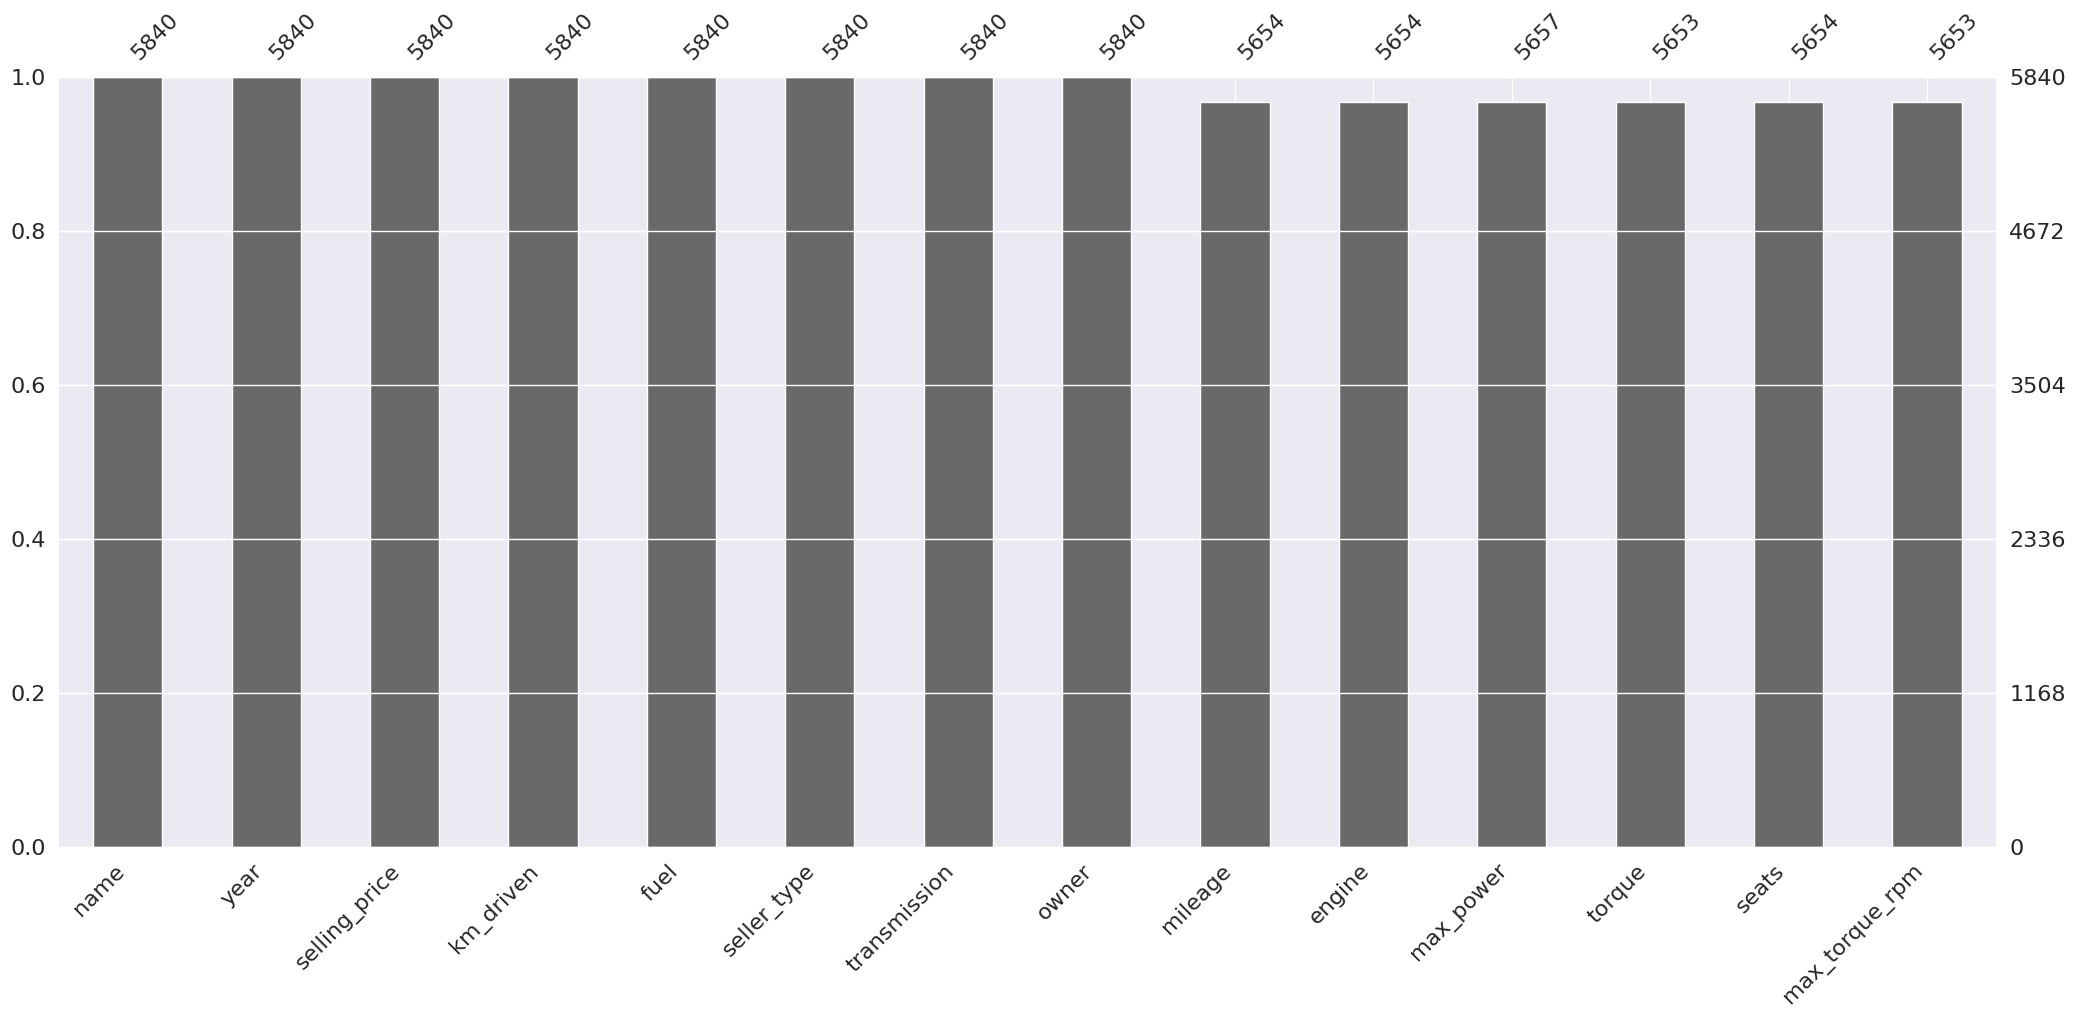

In [25]:
sns.set()

msno.bar(df_train_copy);

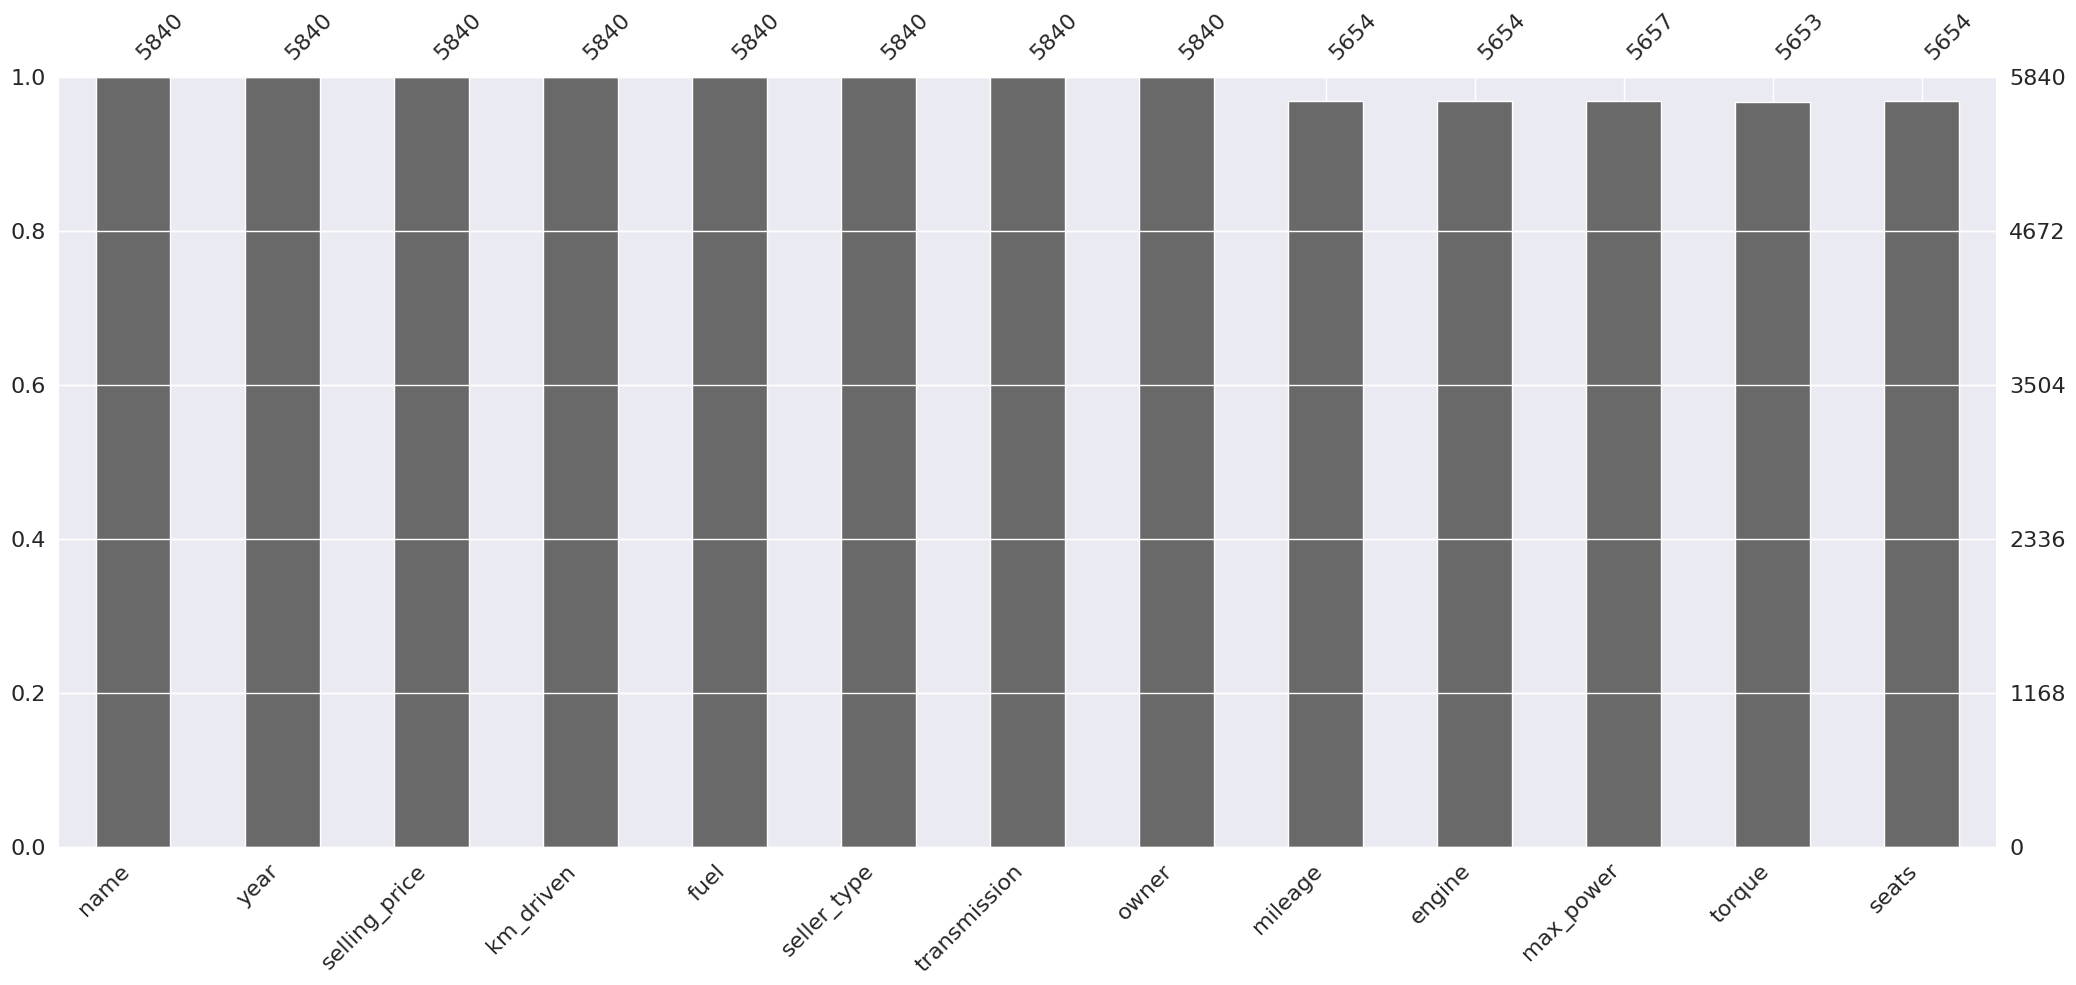

In [26]:
msno.bar(df_train);

In [27]:
df_train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5840 non-null   object 
 1   year            5840 non-null   int64  
 2   selling_price   5840 non-null   int64  
 3   km_driven       5840 non-null   int64  
 4   fuel            5840 non-null   object 
 5   seller_type     5840 non-null   object 
 6   transmission    5840 non-null   object 
 7   owner           5840 non-null   object 
 8   mileage         5654 non-null   float64
 9   engine          5654 non-null   float64
 10  max_power       5657 non-null   float64
 11  torque          5653 non-null   float64
 12  seats           5654 non-null   float64
 13  max_torque_rpm  5653 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 638.9+ KB


In [28]:
df_train = df_train_copy.copy()

Мы проверили, не добавил ли парсинг переменной torque новых пропусков в данные. Как видим, не добавил. Повторим обработку переменных для тестовой выборки:

In [29]:
df_test_copy = df_test.copy()

df_test_copy['mileage'] = df_test_copy['mileage'].apply(lambda x: float(x.split()[0]) if type(x) != float else x)
df_test_copy['engine'] = df_test_copy['engine'].apply(lambda x: float(x.split()[0]) if type(x) != float else x)
df_test_copy['max_power'] = df_test_copy['max_power'].apply(lambda x: float(x.split()[0]) if type(x) != float else x)
df_test_copy['torque'] = df_test_copy['torque'].apply(lambda x: x.lower() if type(x) != float else x)
df_test_copy['torque_text'] = df_test_copy['torque']
df_test_copy['torque'] = df_test_copy['torque_text'].apply(lambda x: extract_torque(x) if type(x) != float else x)
df_test_copy['max_torque_rpm'] = df_test_copy['torque_text'].apply(lambda x: extract_max_torque_rpm(x) if type(x) != float else x)
df_test_copy = df_test_copy.drop('torque_text', axis=1)
df_test_copy

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
0,Mahindra Xylo E4 BS IV,2010,229999,168000,Diesel,Individual,Manual,First Owner,14.00,2498.0,112.00,260.00,7.0,2000.0
1,Tata Nexon 1.5 Revotorq XE,2017,665000,25000,Diesel,Individual,Manual,First Owner,21.50,1497.0,108.50,260.00,5.0,2125.0
2,Honda Civic 1.8 S AT,2007,175000,218463,Petrol,Individual,Automatic,First Owner,12.90,1799.0,130.00,172.00,5.0,4300.0
3,Honda City i DTEC VX,2015,635000,173000,Diesel,Individual,Manual,First Owner,25.10,1498.0,98.60,200.00,5.0,1750.0
4,Tata Indica Vista Aura 1.2 Safire BSIV,2011,130000,70000,Petrol,Individual,Manual,Second Owner,16.50,1172.0,65.00,96.00,5.0,3000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,Hyundai i10 Magna 1.1L,2008,250000,100000,Petrol,Individual,Manual,Second Owner,19.81,1086.0,68.05,99.04,5.0,4500.0
996,Hyundai i20 2015-2017 Sportz 1.2,2017,440000,50000,Petrol,Individual,Manual,Second Owner,18.60,1197.0,81.83,114.70,5.0,4000.0
997,Hyundai i20 Era Diesel,2009,340000,40000,Diesel,Individual,Manual,First Owner,23.00,1396.0,90.00,224.00,5.0,2250.0
998,Hyundai i10 Asta,2012,350000,25000,Petrol,Individual,Manual,First Owner,20.36,1197.0,78.90,111.80,5.0,4000.0


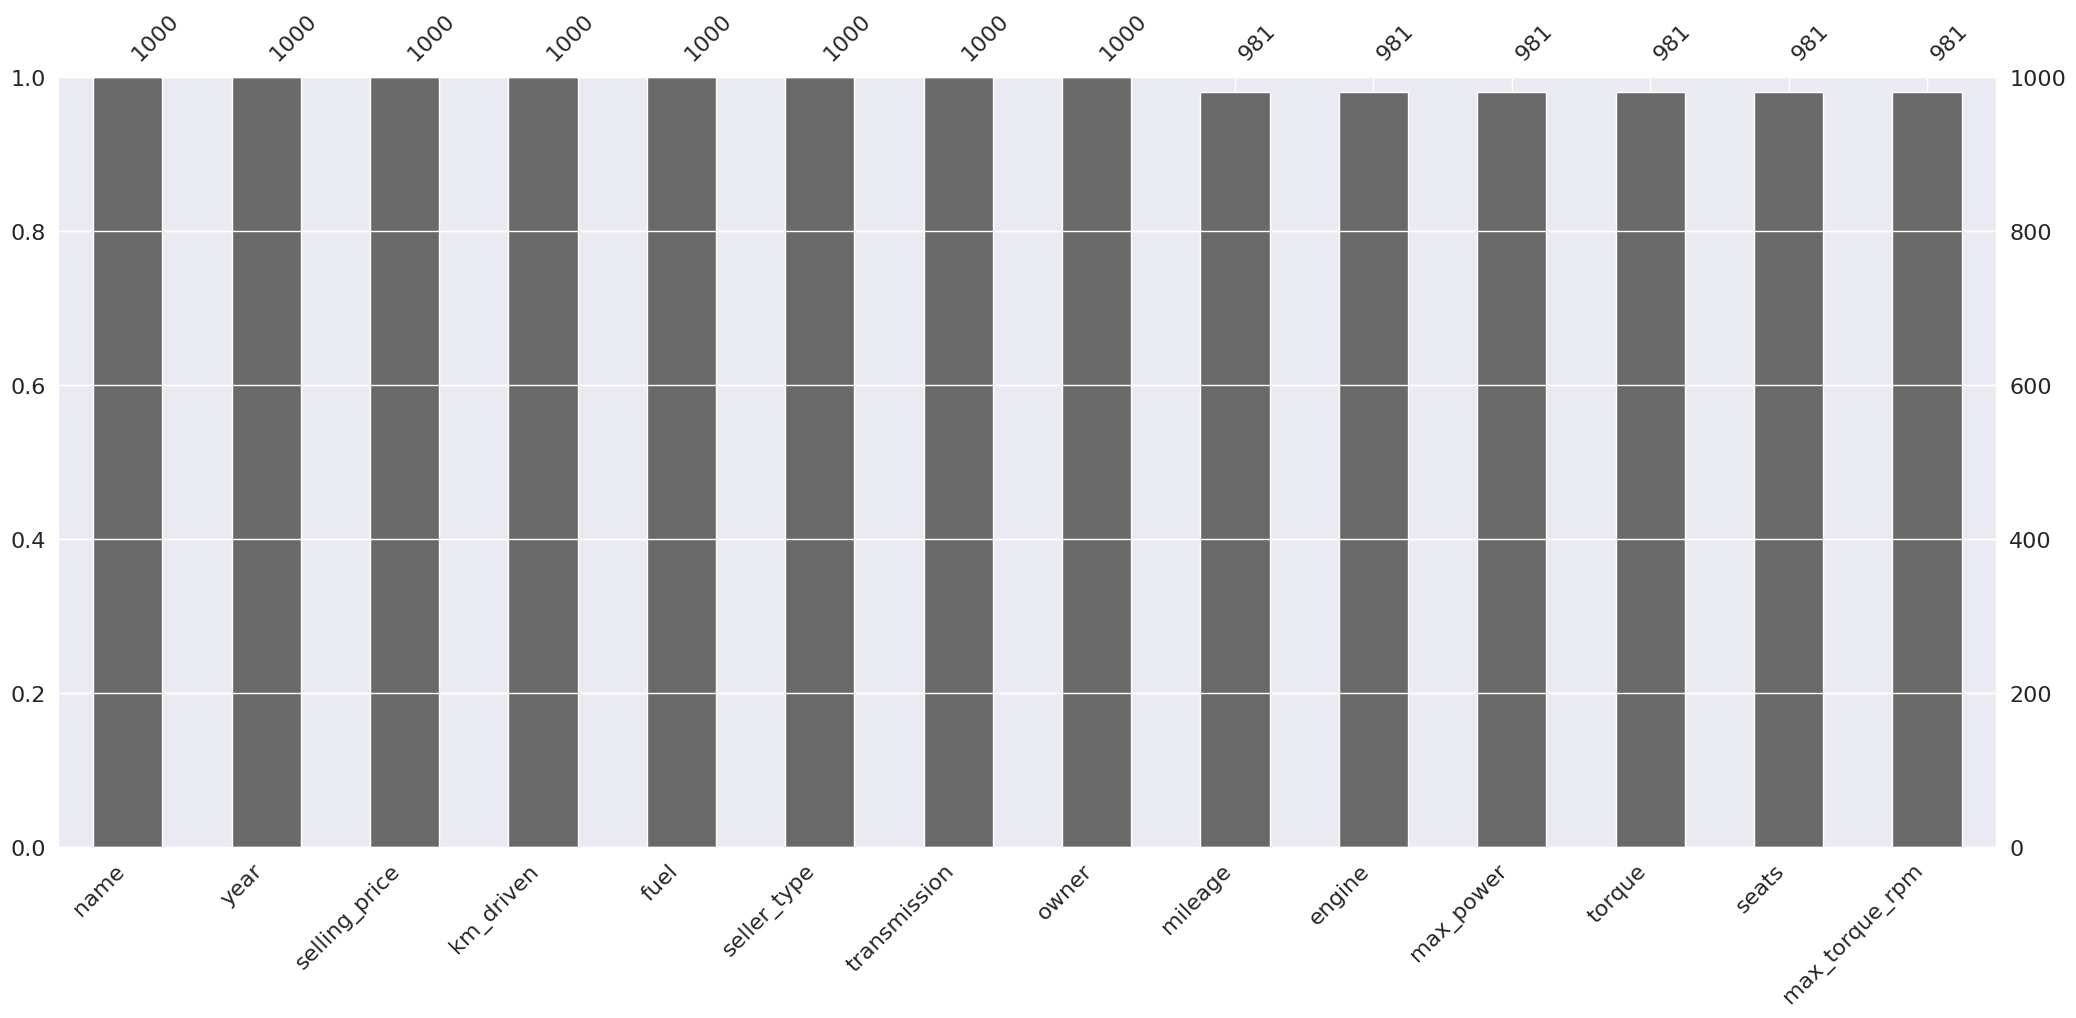

In [30]:
msno.bar(df_test_copy);

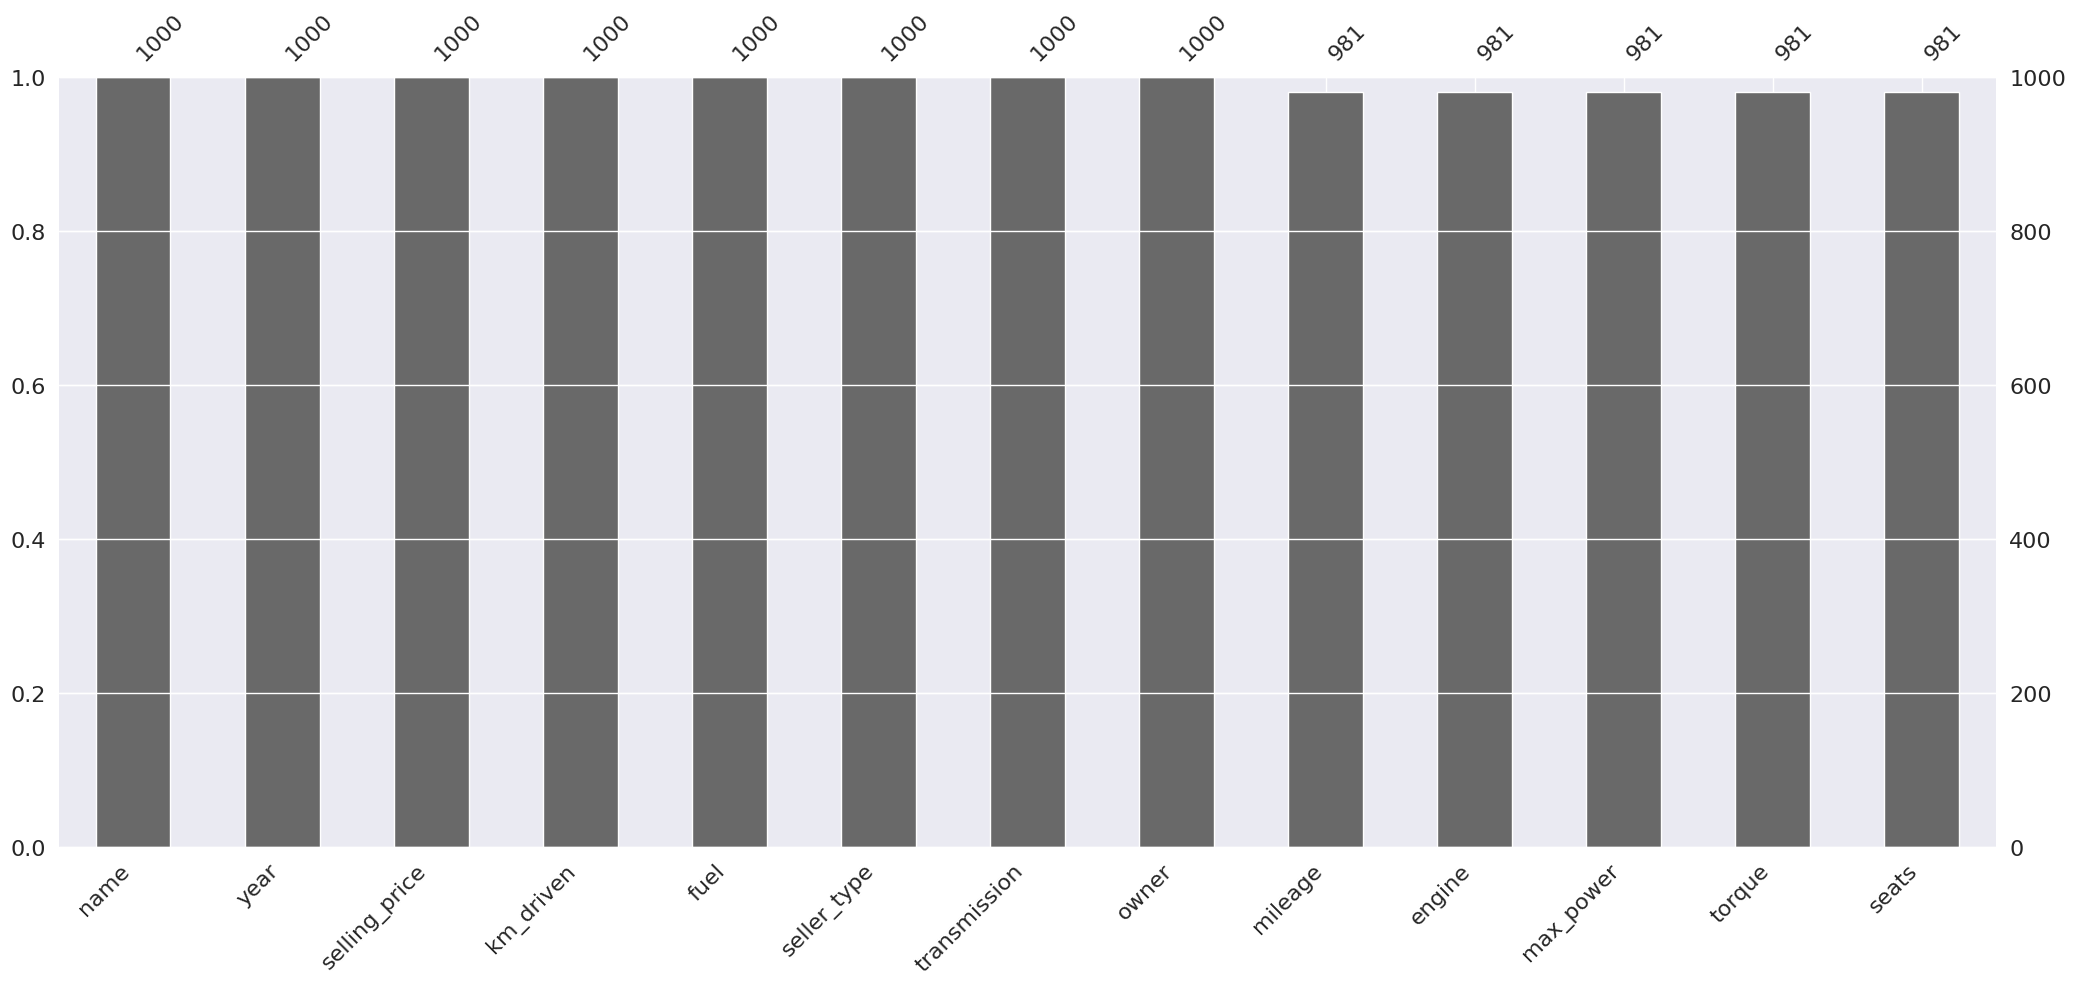

In [31]:
msno.bar(df_test);

In [32]:
df_test_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1000 non-null   object 
 1   year            1000 non-null   int64  
 2   selling_price   1000 non-null   int64  
 3   km_driven       1000 non-null   int64  
 4   fuel            1000 non-null   object 
 5   seller_type     1000 non-null   object 
 6   transmission    1000 non-null   object 
 7   owner           1000 non-null   object 
 8   mileage         981 non-null    float64
 9   engine          981 non-null    float64
 10  max_power       981 non-null    float64
 11  torque          981 non-null    float64
 12  seats           981 non-null    float64
 13  max_torque_rpm  981 non-null    float64
dtypes: float64(6), int64(3), object(5)
memory usage: 109.5+ KB


In [33]:
df_test = df_test_copy.copy()

### **Задание 5 (0.3 балла)**

На первом шаге мы обнаружили пропуски. Давайте избавимся от них.

**Задание:**
- [ ] Заполните пропуски в столбцах медианами. Убедитесь, что после заполнения пропусков не осталось.
- [ ] Почему стоит применять именно медиану. Могли ли мы применить среднее? Обоснуйте свое рассуждение.
- [ ] Как правильно считать медиану для заполнения? Выберите верное утверждение:
 - По тестовым свою, по тренировочным — свою
 - По тренировочным данным для `train` и `test`






Построим диаграммы распределения для переменных, в которых наблюдаются пропуски

<Axes: >

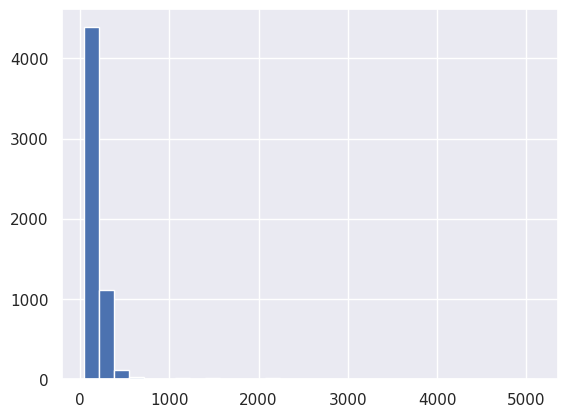

In [34]:
df_train['torque'].hist(bins=30)

<Axes: >

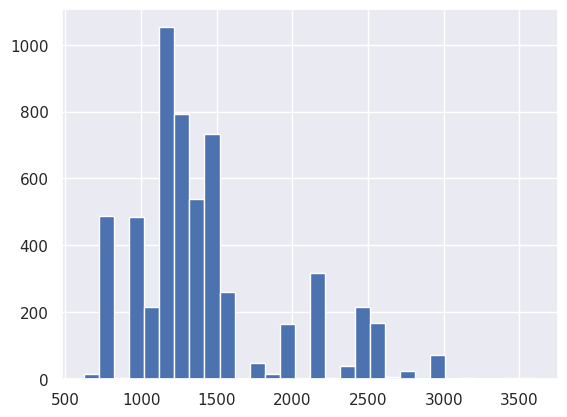

In [35]:
df_train['engine'].hist(bins=30)

<Axes: >

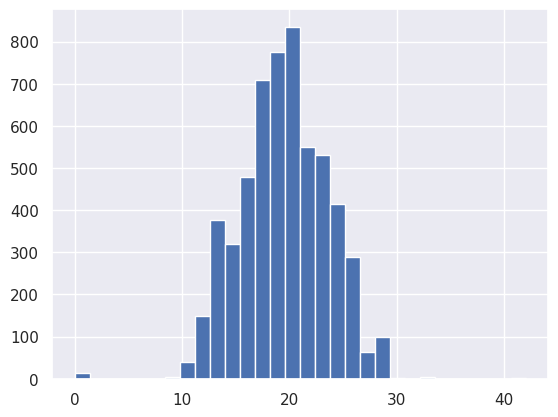

In [36]:
df_train['mileage'].hist(bins=30)

<Axes: >

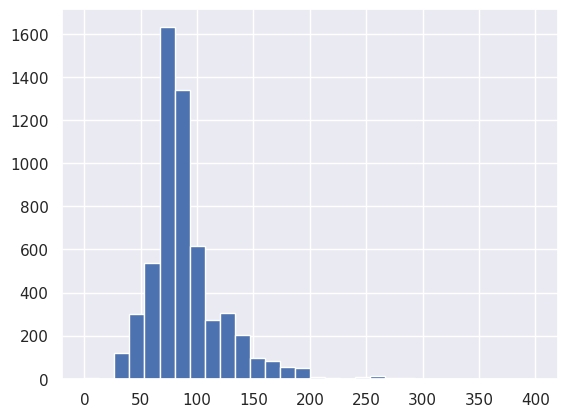

In [37]:
df_train['max_power'].hist(bins=30)

<Axes: >

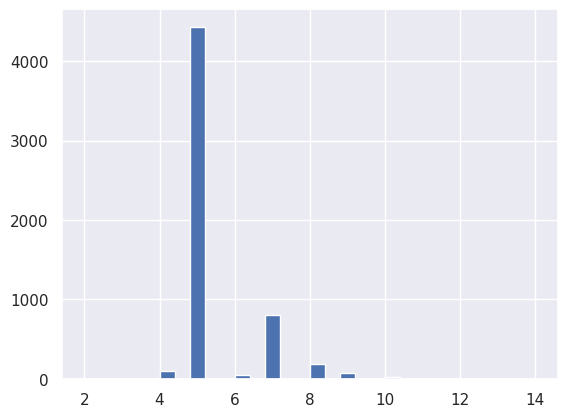

In [38]:
df_train['seats'].hist(bins=30)

<Axes: >

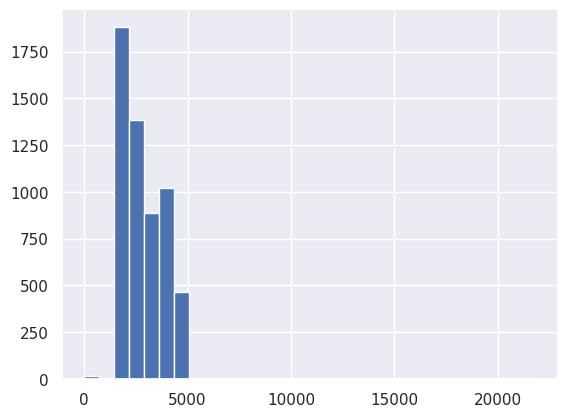

In [39]:
df_train['max_torque_rpm'].hist(bins=30)

Из диаграмм видно, что почти все переменные имеют смещенное распределение - только переменная mileage имеет распределение близкое к нормальному. А при смещенном распределении лучше использовать медиану, так как она более устойчива к выбросам. В переменной mileage можно использовать среднее значение, так как распределение близко к нормальному

Для заполнения пропусков посчитаем медиану только по тренировочным данным, так как мы не можем считать медиану по данным из будущего, это приведет к утечке данных.

In [40]:
torque_median = df_train['torque'].median()
engine_median = df_train['engine'].median()
mileage_median = df_train['mileage'].median()
max_power_median = df_train['max_power'].median()
seats_median = df_train['seats'].median()
max_torque_rpm_median = df_train['max_torque_rpm'].median()

In [41]:
df_train['torque'].fillna(torque_median, inplace=True)
df_train['engine'].fillna(engine_median, inplace=True)
df_train['mileage'].fillna(mileage_median, inplace=True)
df_train['max_power'].fillna(max_power_median, inplace=True)
df_train['seats'].fillna(seats_median, inplace=True)
df_train['max_torque_rpm'].fillna(max_torque_rpm_median, inplace=True)

df_test['torque'].fillna(torque_median, inplace=True)
df_test['engine'].fillna(engine_median, inplace=True)
df_test['mileage'].fillna(mileage_median, inplace=True)
df_test['max_power'].fillna(max_power_median, inplace=True)
df_test['seats'].fillna(seats_median, inplace=True)
df_test['max_torque_rpm'].fillna(max_torque_rpm_median, inplace=True)


In [42]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5840 non-null   object 
 1   year            5840 non-null   int64  
 2   selling_price   5840 non-null   int64  
 3   km_driven       5840 non-null   int64  
 4   fuel            5840 non-null   object 
 5   seller_type     5840 non-null   object 
 6   transmission    5840 non-null   object 
 7   owner           5840 non-null   object 
 8   mileage         5840 non-null   float64
 9   engine          5840 non-null   float64
 10  max_power       5840 non-null   float64
 11  torque          5840 non-null   float64
 12  seats           5840 non-null   float64
 13  max_torque_rpm  5840 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 638.9+ KB


In [43]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1000 non-null   object 
 1   year            1000 non-null   int64  
 2   selling_price   1000 non-null   int64  
 3   km_driven       1000 non-null   int64  
 4   fuel            1000 non-null   object 
 5   seller_type     1000 non-null   object 
 6   transmission    1000 non-null   object 
 7   owner           1000 non-null   object 
 8   mileage         1000 non-null   float64
 9   engine          1000 non-null   float64
 10  max_power       1000 non-null   float64
 11  torque          1000 non-null   float64
 12  seats           1000 non-null   float64
 13  max_torque_rpm  1000 non-null   float64
dtypes: float64(6), int64(3), object(5)
memory usage: 109.5+ KB


### **Задание 6 (0.2 балла)**

Теперь, когда не осталось пропусков, давайте преобразуем столбцы к более подходящим типам. А именно столбцы ``engnine`` и ``seats`` к приведем к `int`.

- [ ] Осуществите приведение столбцов к необходимому типу.
- [ ] Ответье на вопрос — почему (хоть мы этого и не делаем) ``seats``, возможно рассмотреть как категориальную переменную?

In [44]:
df_train['engine'] = df_train['engine'].astype('int32')
df_train['seats'] = df_train['seats'].astype('int32')

df_test['engine'] = df_test['engine'].astype('int32')
df_test['seats'] = df_test['seats'].astype('int32')

In [45]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5840 non-null   object 
 1   year            5840 non-null   int64  
 2   selling_price   5840 non-null   int64  
 3   km_driven       5840 non-null   int64  
 4   fuel            5840 non-null   object 
 5   seller_type     5840 non-null   object 
 6   transmission    5840 non-null   object 
 7   owner           5840 non-null   object 
 8   mileage         5840 non-null   float64
 9   engine          5840 non-null   int32  
 10  max_power       5840 non-null   float64
 11  torque          5840 non-null   float64
 12  seats           5840 non-null   int32  
 13  max_torque_rpm  5840 non-null   float64
dtypes: float64(4), int32(2), int64(3), object(5)
memory usage: 593.3+ KB


In [46]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            1000 non-null   object 
 1   year            1000 non-null   int64  
 2   selling_price   1000 non-null   int64  
 3   km_driven       1000 non-null   int64  
 4   fuel            1000 non-null   object 
 5   seller_type     1000 non-null   object 
 6   transmission    1000 non-null   object 
 7   owner           1000 non-null   object 
 8   mileage         1000 non-null   float64
 9   engine          1000 non-null   int32  
 10  max_power       1000 non-null   float64
 11  torque          1000 non-null   float64
 12  seats           1000 non-null   int32  
 13  max_torque_rpm  1000 non-null   float64
dtypes: float64(4), int32(2), int64(3), object(5)
memory usage: 101.7+ KB


`Your answer here`

Переменную seats возможно рассмотреть как категориальную, так как она:
1) Имеет ограниченное количество значений
2) По количеству мест мы можем судить о типе автомобиля - от двухместного спорткара или автомобиля марки Smart до семиместного минивена
3) Разное количество мест может по разному влиять на цену автомобиля - минивены с 7 местами сильно дороже 4-местного седана

### **Задание 7 (0.1 балла)**

Снова вызовите метод describe и проанализируйте статистики.

**Ответье на вопрос:**
- [ ] Есть ли основания предполагать, что заполнение пропусков свдинуло наши распределения? Могло ли это вообще возникнуть?

In [47]:
display(Markdown('### Статистики числовых переменных тренировочного датасета'))
display(df_train.describe())
display(Markdown('### Статистики категориальных переменных тренировочного датасета'))
display(df_train.describe(include = 'object'))
display(Markdown('###Статистики числовых переменных тестового датасета'))
display(df_test.describe())
display(Markdown('###Статистики категориальных переменных тестового датасета'))
display(df_test.describe(include = 'object'))

### Статистики числовых переменных тренировочного датасета

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
count,5840.000000,5.840000e+03,5.840000e+03,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000,5840.000000
mean,2013.428425,5.229601e+05,7.395224e+04,19.430841,1429.448973,87.898689,179.265512,5.426712,2841.998630
std,4.095622,5.354320e+05,6.007114e+04,3.985973,485.662834,31.647331,145.538725,0.982344,979.793332
min,1983.000000,2.999900e+04,1.000000e+00,0.000000,624.000000,0.000000,48.000000,2.000000,7.000000
25%,2011.000000,2.500000e+05,3.900000e+04,16.950000,1197.000000,68.000000,112.000000,5.000000,2000.000000
50%,2014.000000,4.050000e+05,7.000000e+04,19.370000,1248.000000,81.860000,163.000000,5.000000,2400.000000
75%,2017.000000,6.400000e+05,1.000000e+05,22.300000,1498.000000,99.000000,204.000000,5.000000,3750.000000
max,2020.000000,1.000000e+07,2.360457e+06,42.000000,3604.000000,400.000000,5100.000000,14.000000,21800.000000


### Статистики категориальных переменных тренировочного датасета

,name,fuel,seller_type,transmission,owner
count,5840,5840,5840,5840,5840
unique,1924,4,3,2,5
top,Maruti Swift Dzire VDI,Diesel,Individual,Manual,First Owner
freq,91,3177,5223,5336,3603


###Статистики числовых переменных тестового датасета

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
count,1000.000000,1.000000e+03,1000.000000,1000.00000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2013.681000,6.179010e+05,71393.341000,19.33881,1454.87600,90.841670,179.353610,5.403000,2873.373000
std,4.012149,7.585539e+05,48486.218662,3.95175,521.99574,34.893389,108.707585,0.912921,977.145256
min,1995.000000,3.100000e+04,1303.000000,0.00000,624.00000,34.200000,48.000000,4.000000,2.000000
25%,2011.000000,2.500000e+05,37000.000000,16.55000,1197.00000,69.000000,111.700000,5.000000,2125.000000
50%,2014.000000,4.349990e+05,61500.000000,19.37000,1248.00000,82.425000,163.000000,5.000000,2400.000000
75%,2017.000000,6.700000e+05,100000.000000,22.30000,1582.00000,102.000000,210.000000,5.000000,4000.000000
max,2020.000000,6.000000e+06,375000.000000,32.26000,3604.00000,280.000000,1450.000000,9.000000,5000.000000


###Статистики категориальных переменных тестового датасета

,name,fuel,seller_type,transmission,owner
count,1000,1000,1000,1000,1000
unique,621,4,3,2,5
top,Maruti Alto 800 LXI,Diesel,Individual,Manual,First Owner
freq,15,534,837,877,623


`Your answer here`

Так как до обработки все признаки, кроме seats, были категориальными, то о смещении статистик говорить нельзя, если только сравнить моду бывших категориальных признаков, то все же небольшое смещение произошло, потому что мода показывала реальные параметры, а в статистике числовых параметров отобразились средние, медианные и квартильные значения. Так как пропусков было немного, то в признаке seats произошло лишь небольшое смещение, в районе 0,01. Категориальные статистики остались без изменений. Числовые признаки, которые не обрабатывлись, в тестовом датасете не изменились, а в тренировочном изменились, так как мы удалили дубликаты

## **Визуализации и корреляция (1.6 балла + 0.25)**

Визуализация данных — важный шаг в работе. Визуализировать данные необходимо, например, чтобы:

- Оценить распределения признаков самих по себе (это может натоклнуть вас на мысли о модели, которую можно использовать)
- Сравнить распределения на `train` и `test` — чтобы проверить, насколько информация, на которой вы будете обучаться согласуется с той, на которой модель должна работать
- Оценить есть ли явная связь признаков с целевой переменной

**Важно:**

Если распределения на `train` и `test` не совпадают, это не значит, что нужно перемешивать данные! Более корректно актуализировать задачу и уточнить, а не устарели ли данные `train`. Также полезным может быть собрать новую тестовую выборку, смешав те, что имеются сейчас.

**Если вы будете подгонять распределения, то можете встретиться с переобучением!**

### **Задание 8 (0.5 балла)**

Шаг 1.
- [ ] Воспользуйтесь `pairplot` из библиотеки `seabron`, чтобы визуализировать попарные распределения числовых признаков для `train`
- [ ] По полученному графику ответьте на вопросы:
 - Можно ли предположить на основе распределений связь признаков с целевой переменной?
 - Можно ли предположить на основе распределений выдвинуть гипотезу о корреляциях признаков?

Шаг 2.

- [ ] Постройте pairplot по тестовым данным
- [ ] Ответьте на вопрос "Похожими ли оказались совокупности при разделении на трейн и тест?"

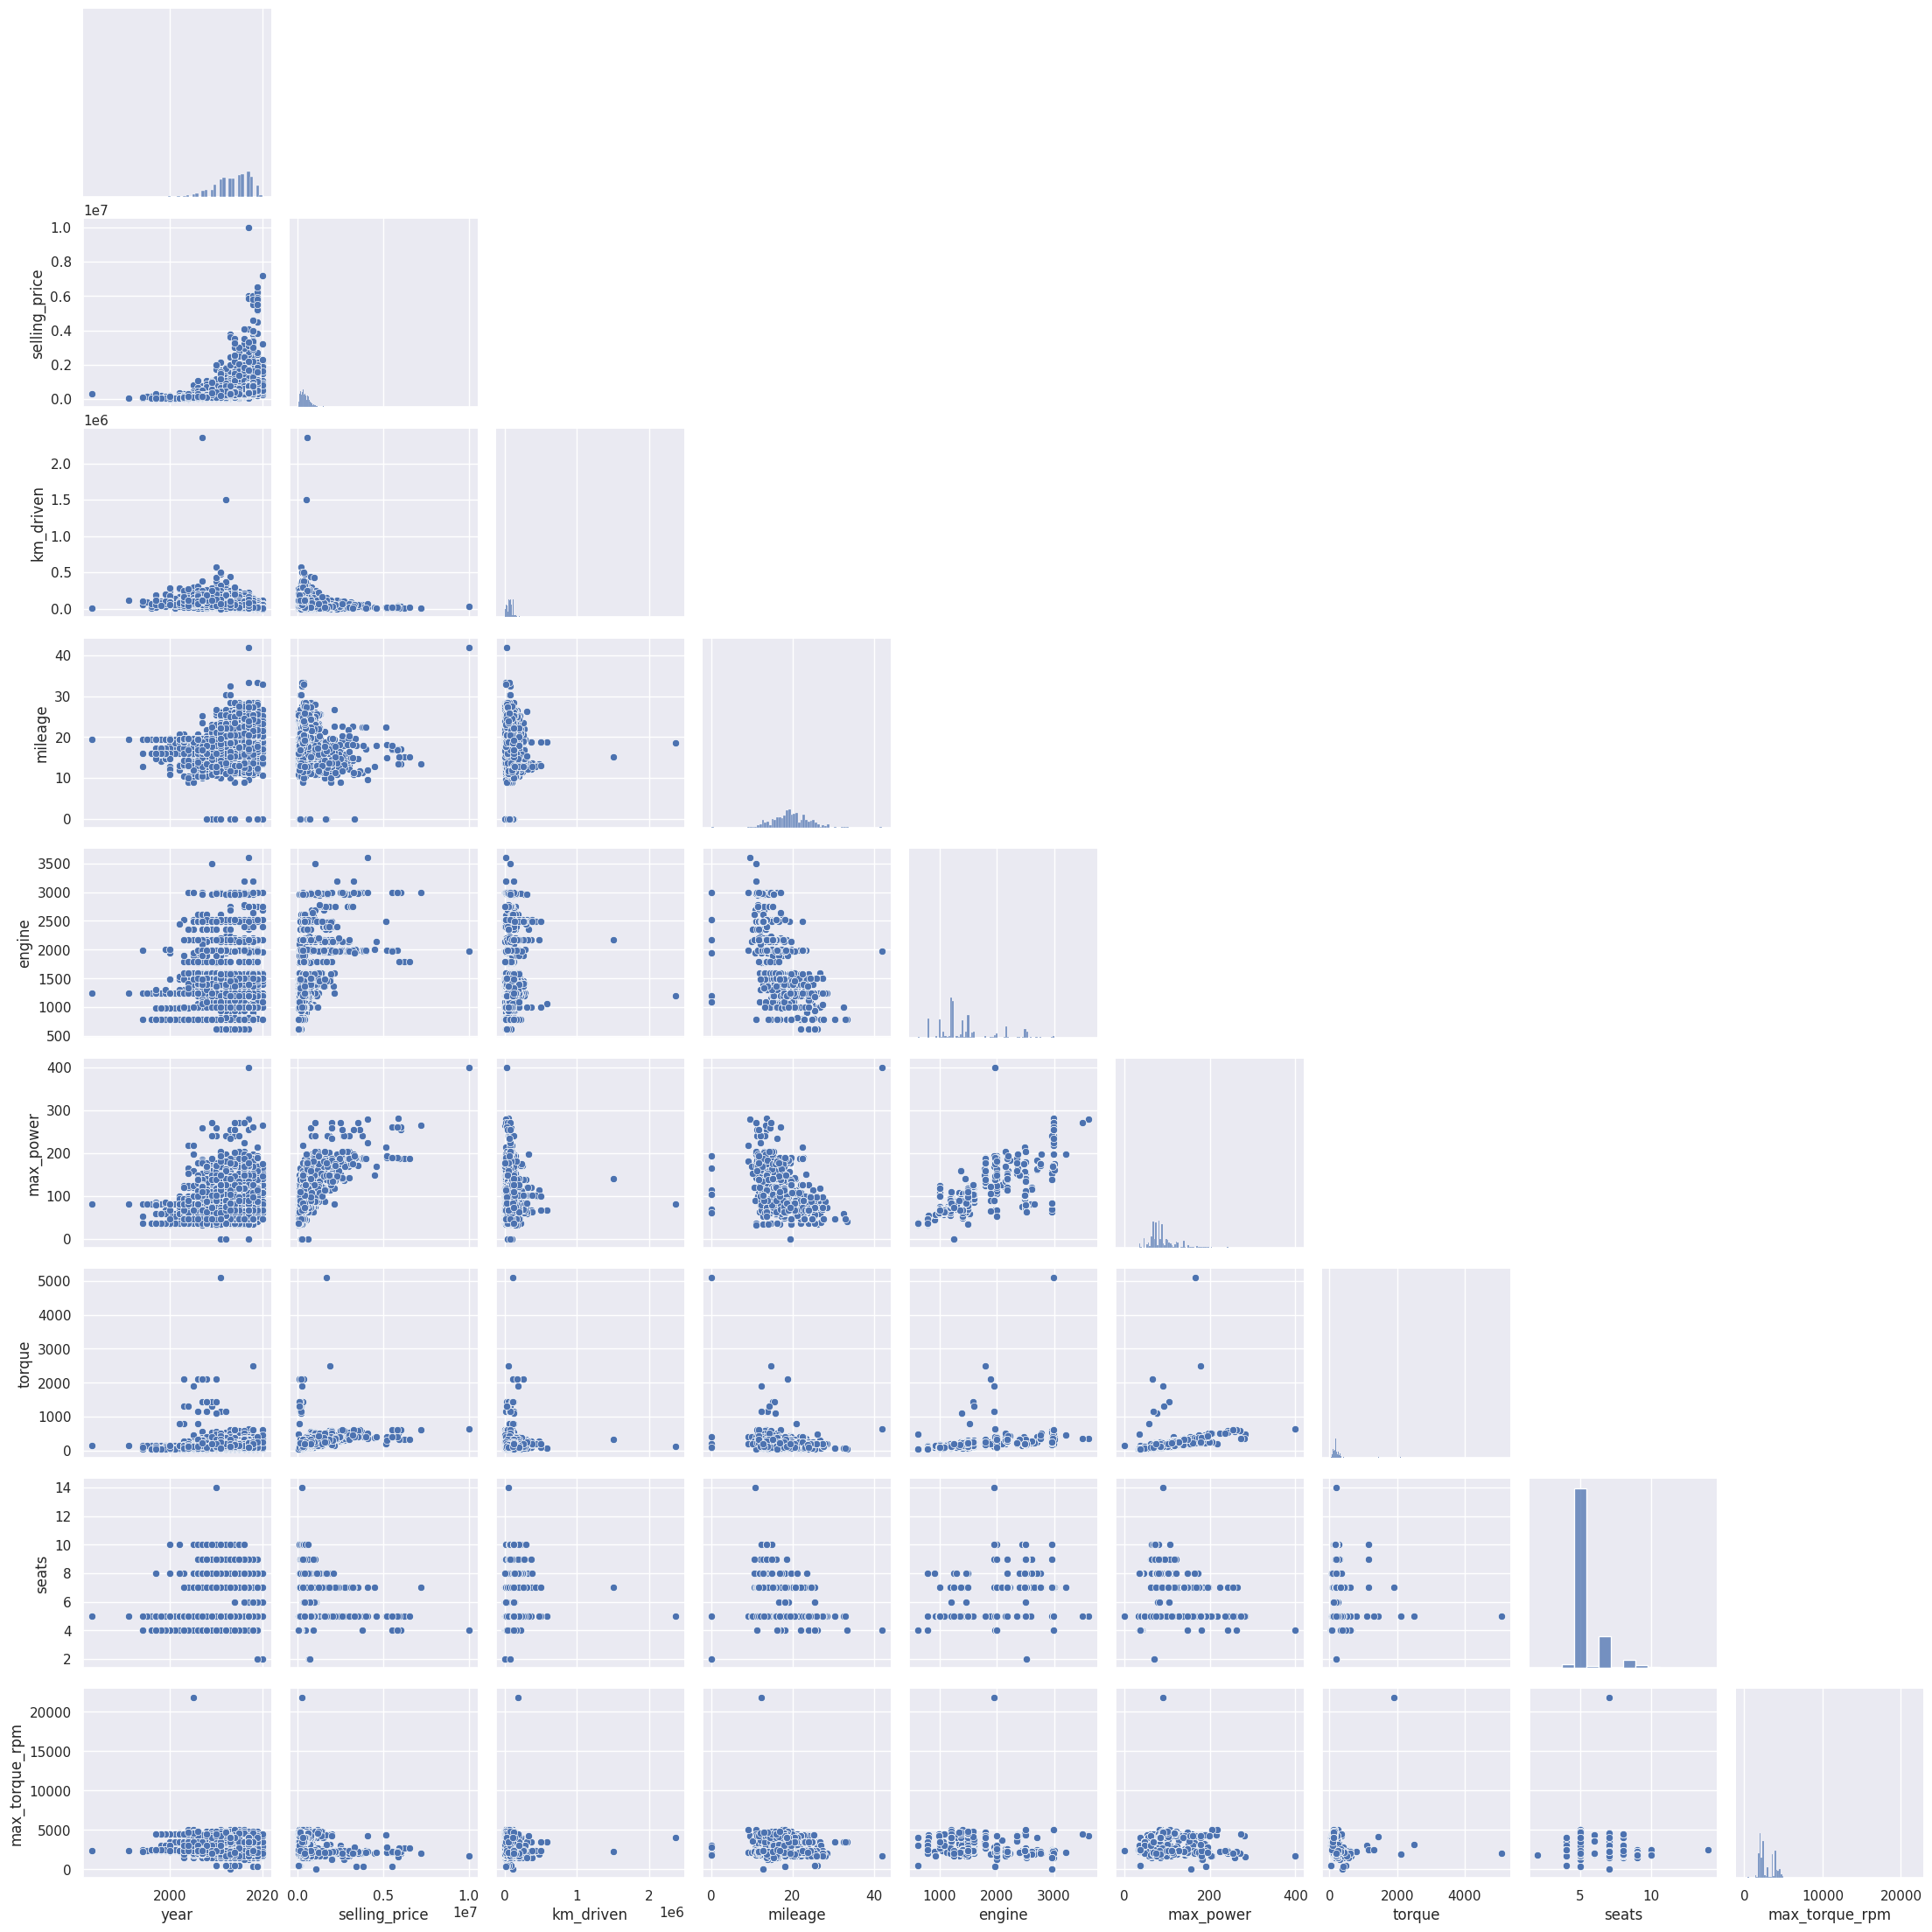

In [48]:
sns.pairplot(df_train, corner=True)

Можно увидеть явную связь между признаками и целевой переменной:
1) year - явная отрицательная связь, чем новее машина, тем она дороже.
2) Можно увидеть, что распределение целевой переменной немного смещено влево
3) km_driven - автомобили с маленьким пробегом ценятся больше
4) mileage - более экономичные двигатели хоть и ценятся больше, но мощные двигатели с большим расходом топлива всегда в большой цене
5) engine и max_power - двигатели с большим объемом и мощностью стоят дороже малолитражных
6) Зависимость цены от крутящего момента не такая явная, но все равно, машины с тяговитым мотором дороже
7) Число сидений не чсильно влияет на цену авто, четырехместный седан может стоить дороже семиместного минивена, если седан бизнес-класса, а минивен бюджетный
8) Обороты, при которых достигается максимальный момент не сильно влияют на цену. Этот параметр зависит от типа двигателя

На основе графиков можно сделать выводы о наличии корелляции между многими параметрами, например мощностью и объемом двигателя, крутящим моментом и мощностью, а также объемом двигателя, годом выпуска и пробега

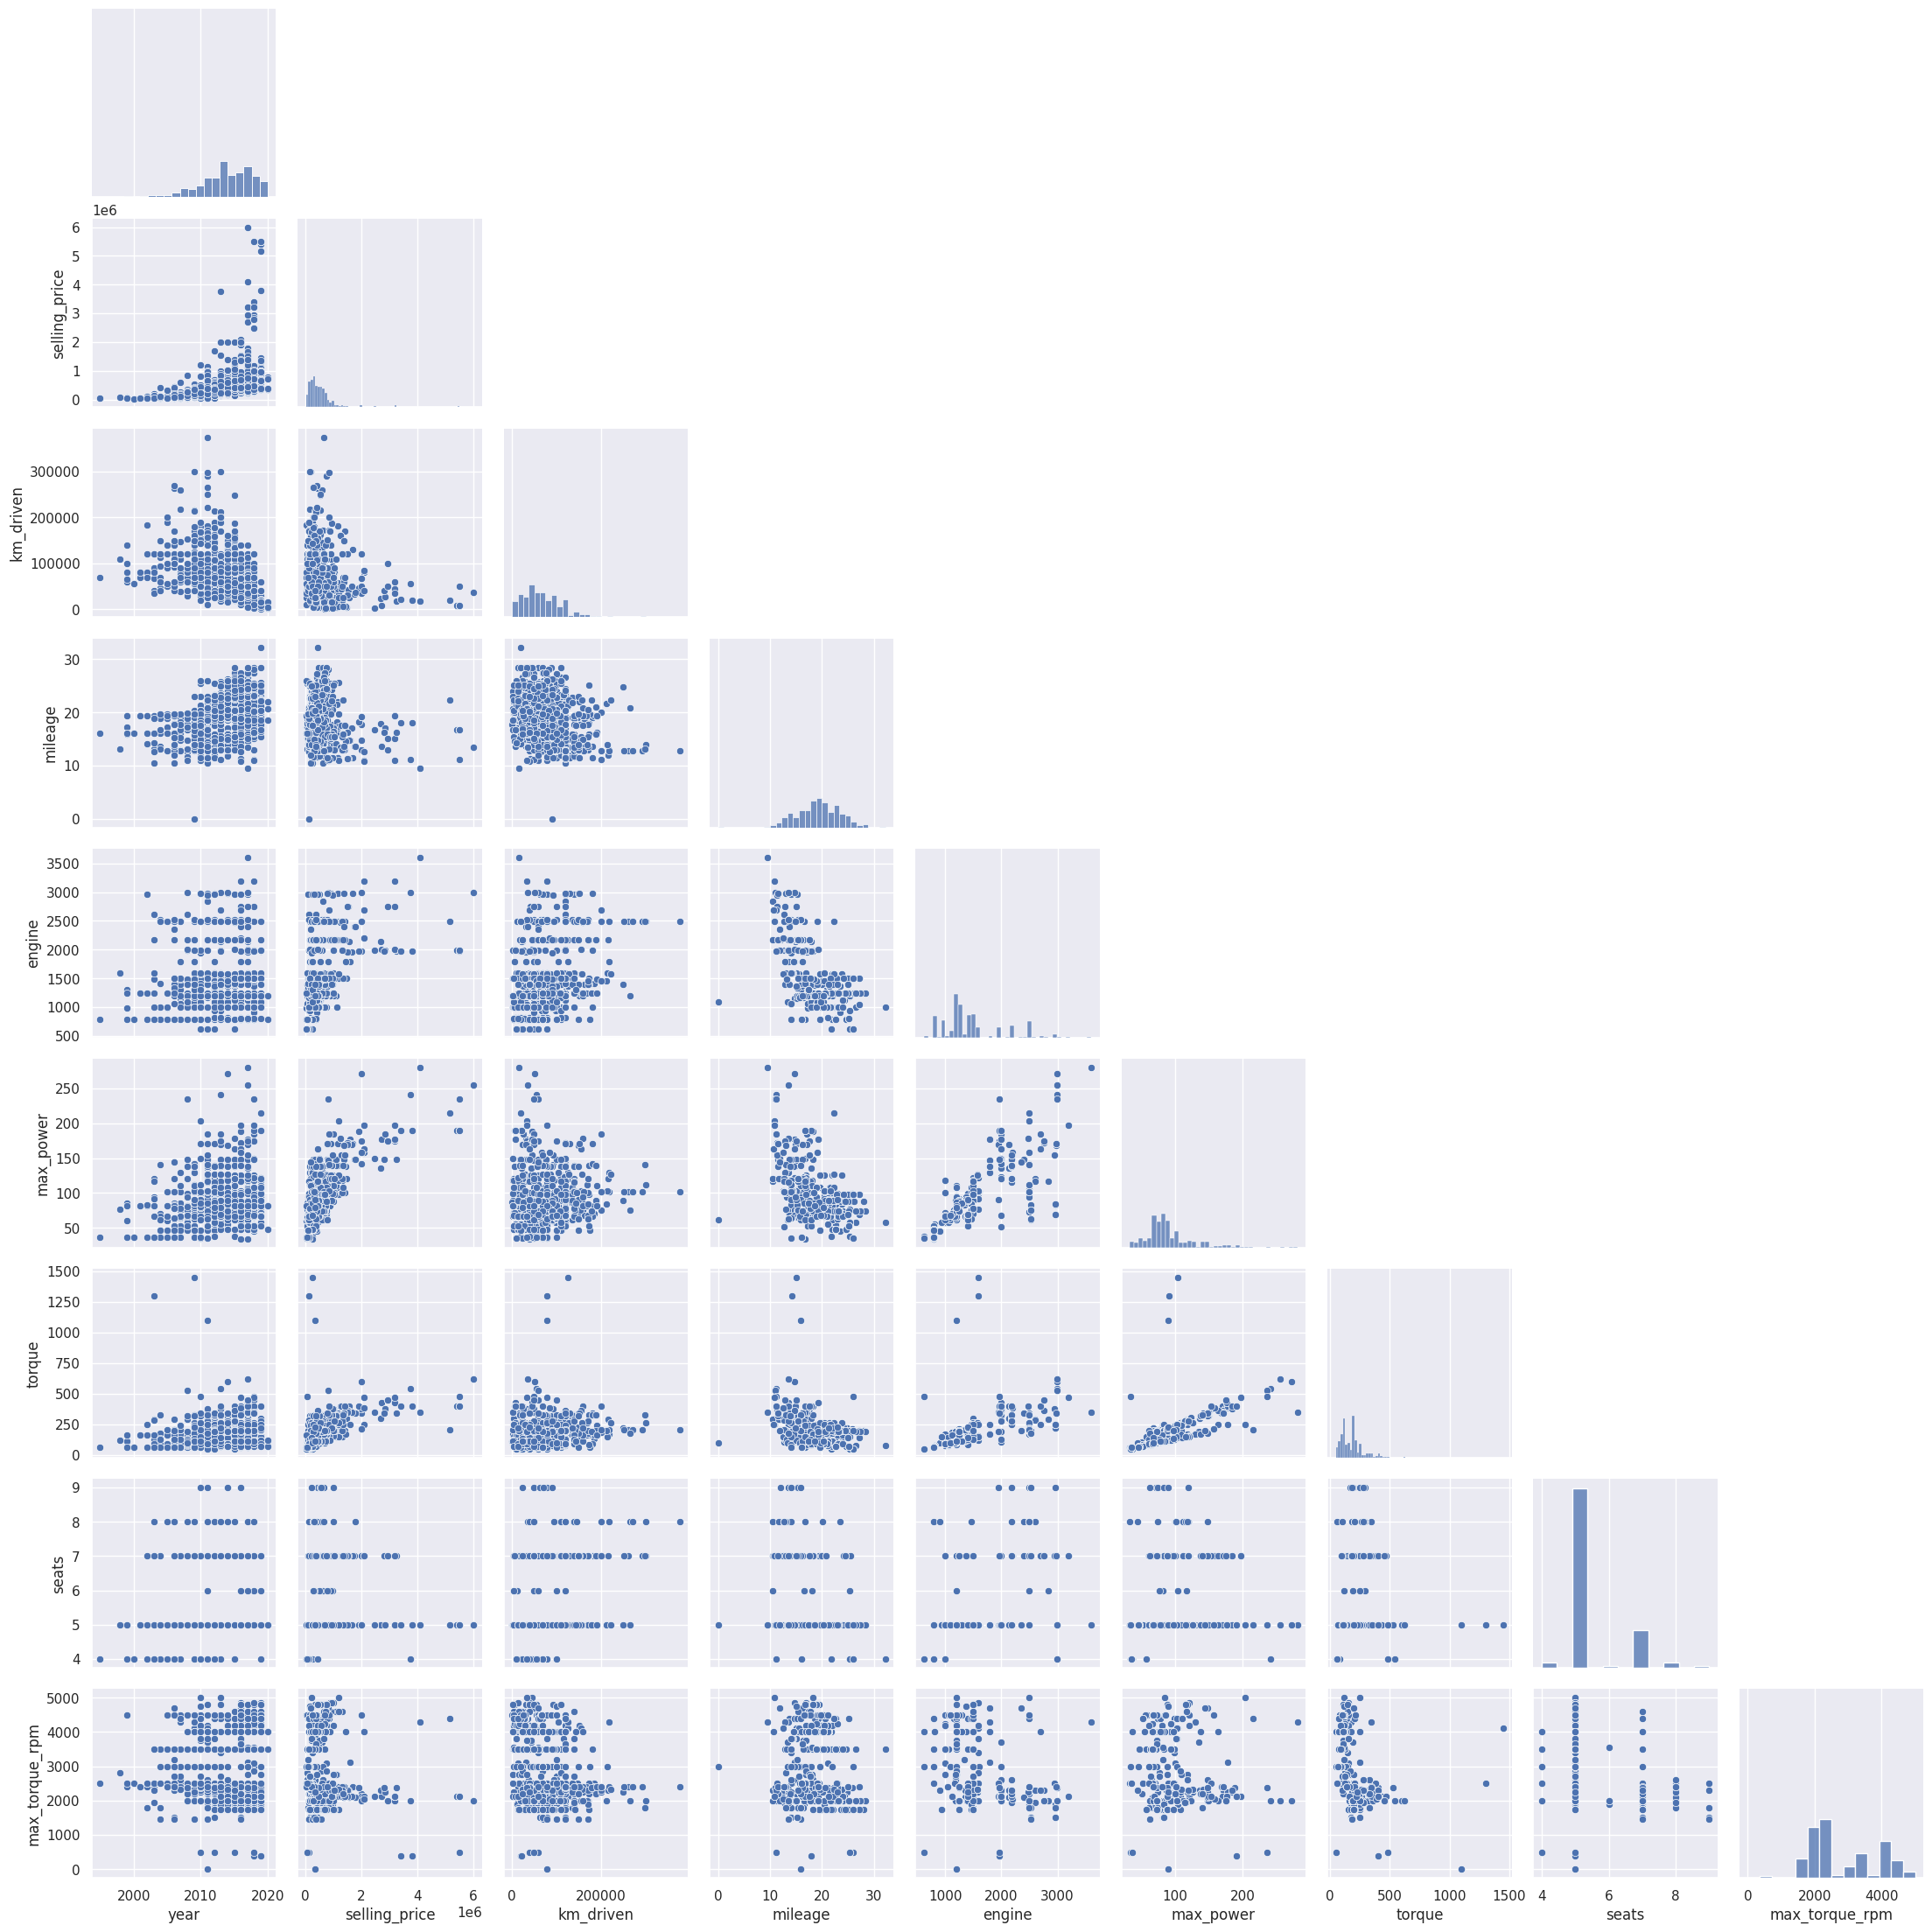

In [49]:
sns.pairplot(df_test, corner=True)

Распределения трейна и теста достаточно похожи

### **Задание 9 (0.5 балла)**

И так, вы выдвинули гипотезы о наличии связи. Теперь давайте оценим эту связь в числах.

**Задание:**
- [ ] Получите значения коэффициента корреляции Пирсона для тренировочного набора данных при помощи `pd.corr()`
- [ ] По полученным корреляциям постройте тепловую карту (`heatmap` из бибилотеки seaborn)

In [50]:
df_train

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
0,Maruti Swift Dzire VDI,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.00,5,2000.0
1,Skoda Rapid 1.5 TDI Ambition,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.00,5,2000.0
2,Hyundai i20 Sportz Diesel,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,224.00,5,2250.0
3,Maruti Swift VXI BSIII,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,115.00,5,4500.0
4,Hyundai Xcent 1.2 VTVT E Plus,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197,81.86,113.75,5,4000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,Hyundai Santro Xing GLS,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92,1086,62.10,96.10,5,3000.0
5836,Maruti Wagon R VXI BS IV with ABS,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.90,998,67.10,90.00,5,3500.0
5837,Hyundai i20 Magna,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197,82.85,113.70,5,4000.0
5838,Hyundai Verna CRDi SX,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493,110.00,240.00,5,2325.0


In [51]:
correlation_matrix = df_train.drop(['name', 'fuel', 'transmission', 'seller_type', 'owner'], axis=1).corr(method='pearson')
correlation_matrix

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
year,1.000000,0.427279,-0.368966,0.341334,0.002819,0.157620,0.009970,0.041178,0.032423
selling_price,0.427279,1.000000,-0.164828,-0.104769,0.447672,0.692864,0.351463,0.149953,-0.179598
km_driven,-0.368966,-0.164828,1.000000,-0.182086,0.229766,0.024477,0.107479,0.192328,-0.226914
mileage,0.341334,-0.104769,-0.182086,1.000000,-0.572893,-0.372789,-0.208477,-0.451059,-0.097939
engine,0.002819,0.447672,0.229766,-0.572893,1.000000,0.681285,0.476255,0.652172,-0.375779
max_power,0.157620,0.692864,0.024477,-0.372789,0.681285,1.000000,0.495093,0.243423,-0.149846
torque,0.009970,0.351463,0.107479,-0.208477,0.476255,0.495093,1.000000,0.222427,-0.286915
seats,0.041178,0.149953,0.192328,-0.451059,0.652172,0.243423,0.222427,1.000000,-0.287117
max_torque_rpm,0.032423,-0.179598,-0.226914,-0.097939,-0.375779,-0.149846,-0.286915,-0.287117,1.000000


<Axes: >

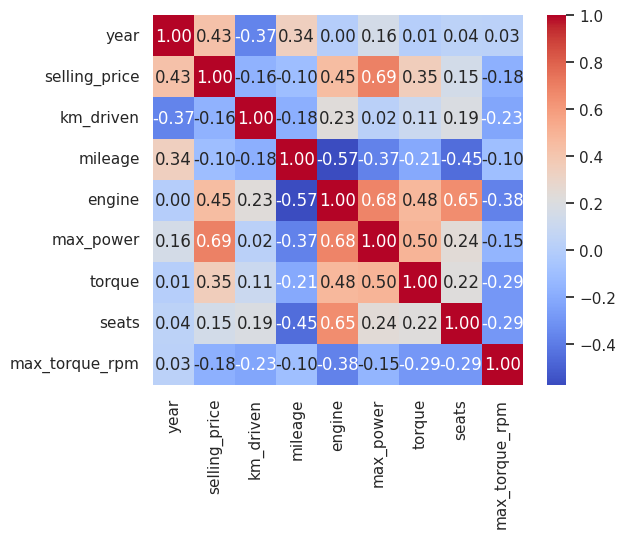

In [52]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)

- [ ] Ответьте на вопросы:
 - Какие 2 признака наименее скоррелированы между собой?
 - Между какими наблюдается довольно сильная положительная линейная зависимость?
 - Правильно ли, опираясь на данные, утверждать, что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи?
 - Изучите типы корреляций в `pd.corr()`. Какую вы использовали по умолчанию?

1) наименее скоррелированы между собой - год выпуска авто и объем двигателя (корреляция = 0)
2) Сильная положительная зависимость - цена и мощность, цена и объем двигателя, объем двигателя и число сидений
3) Утверждать, что что чем меньше год, тем, скорее всего, больше километров проехала машина к дате продажи можно только с оговорками, коэффициент -0.37 указывает на умеренную отрицательную свзяь, то есть, нужно учитывать прочие факторы, например, частота использования авто
4) По умолчанию используется корреляция Пирсона

`Your answer here`

### **Задание 10 (0.6 балла)**

По умолчанию `pd.corr` возвращает корреляцию Пирсона, говорящую о линейной взаимосвязи. Но зависимости существуют не только линейные! В этой задаче, попробуйте измерить другие способы вычисления корреляций.

- [ ] Реализуйте корреляцию Спирмена/Кендала (на выбор) без использования библиотек (можно пользоваться только `numpy`). Сравните результаты вычисления с библиотечной реализацией
- [ ] Сделайте выводы


Постройте матрицу корреляции [phik](https://pypi.org/project/phik/)
- [ ] Проинтерпретируйте результаты


In [53]:
!pip install phik

Реализуем корреляцию Спирмена:

In [54]:
def spearman(df):

  list_df = list(df)
  corr_matrix = pd.DataFrame()

  #функция ранжирования
  def rank(arr):
    sorted_indices = np.argsort(arr)
    ranks = np.empty_like(sorted_indices, dtype=float)
    ranks[sorted_indices] = np.arange(1, len(arr) + 1)
    unique_vals, inverse, counts = np.unique(arr, return_inverse=True, return_counts=True)

    for i, count in enumerate(counts):
      if count > 1:
        indices = np.where(inverse == i)[0]
        avg_rank = np.mean(ranks[indices])
        ranks[indices] = avg_rank
    return ranks

  df = df.to_numpy()
  n = df.shape[0]
  for i in range(df.shape[1]):
    if type(df[:, i][0]) != str:
      arr_x = df[:, i]
      rank_x = rank(arr_x)
      for j in range(df.shape[1]):
        if type(df[:, j][0]) != str:
          arr_y = df[:, j]
          rank_y = rank(arr_y)
          d = rank_x - rank_y
          mean_x = np.mean(rank_x)
          mean_y = np.mean(rank_y)
          corr = (np.sum((rank_x - mean_x)*(rank_y - mean_y))) / (np.sqrt(np.sum((rank_x - mean_x)**2)) * np.sqrt(np.sum((rank_y - mean_y)**2)))
          corr_matrix.at[list_df[i], list_df[j]] = corr
  return corr_matrix







In [55]:
spearman(df_train)

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
year,1.000000,0.707123,-0.569659,0.346132,-0.038056,0.166261,0.095569,0.048291,0.003496
selling_price,0.707123,1.000000,-0.295665,0.026186,0.463577,0.612598,0.576908,0.317605,-0.251339
km_driven,-0.569659,-0.295665,1.000000,-0.198466,0.304504,0.040662,0.246018,0.195317,-0.305198
mileage,0.346132,0.026186,-0.198466,1.000000,-0.429871,-0.308245,-0.164844,-0.435458,-0.159134
engine,-0.038056,0.463577,0.304504,-0.429871,1.000000,0.713435,0.842014,0.527716,-0.465562
max_power,0.166261,0.612598,0.040662,-0.308245,0.713435,1.000000,0.777637,0.304117,-0.147218
torque,0.095569,0.576908,0.246018,-0.164844,0.842014,0.777637,1.000000,0.436121,-0.645639
seats,0.048291,0.317605,0.195317,-0.435458,0.527716,0.304117,0.436121,1.000000,-0.302903
max_torque_rpm,0.003496,-0.251339,-0.305198,-0.159134,-0.465562,-0.147218,-0.645639,-0.302903,1.000000


In [56]:
correlation_matrix = df_train.drop(['name', 'fuel', 'transmission', 'seller_type', 'owner'], axis=1).corr(method='spearman')
correlation_matrix

,year,selling_price,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
year,1.000000,0.707123,-0.569659,0.346132,-0.038056,0.166261,0.095569,0.048291,0.003496
selling_price,0.707123,1.000000,-0.295665,0.026186,0.463577,0.612598,0.576908,0.317605,-0.251339
km_driven,-0.569659,-0.295665,1.000000,-0.198466,0.304504,0.040662,0.246018,0.195317,-0.305198
mileage,0.346132,0.026186,-0.198466,1.000000,-0.429871,-0.308245,-0.164844,-0.435458,-0.159134
engine,-0.038056,0.463577,0.304504,-0.429871,1.000000,0.713435,0.842014,0.527716,-0.465562
max_power,0.166261,0.612598,0.040662,-0.308245,0.713435,1.000000,0.777637,0.304117,-0.147218
torque,0.095569,0.576908,0.246018,-0.164844,0.842014,0.777637,1.000000,0.436121,-0.645639
seats,0.048291,0.317605,0.195317,-0.435458,0.527716,0.304117,0.436121,1.000000,-0.302903
max_torque_rpm,0.003496,-0.251339,-0.305198,-0.159134,-0.465562,-0.147218,-0.645639,-0.302903,1.000000


Результат работы реализованной и библиотечной функции корелляции Спирмена совпадают

<Axes: >

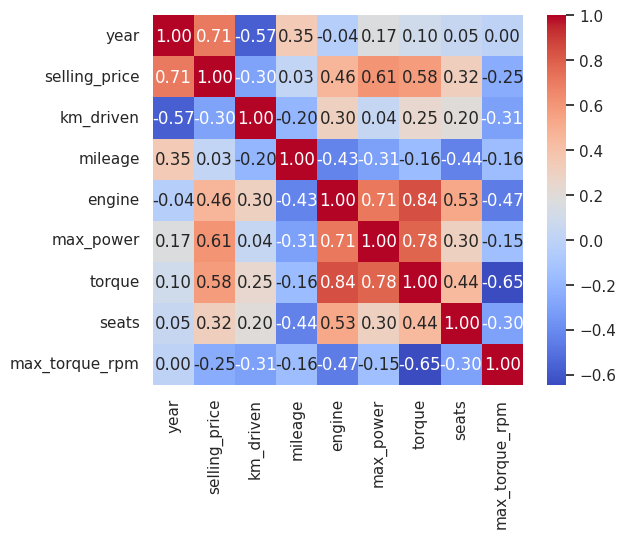

In [57]:
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)

Анализируя матрицу корреляции Спирмена можно сделать следующие выводы о целевой переменной:
1) Очень сильная положительная корреляция между годом выпуска автомобиля и ценой - чем новее автомобиль, тем дороже
2) Достаточно слабая отрицательная корреляция между пробегом и ценой
3) Корреляция между расходом топлива и ценой практически отсутствует
4) Объем двигателя достаточно сильно влияет на цену
5) Максимальная мощность и момент двигателя сильно коррелируют с ценой авто
6) Количество сидений не сильно влияет на цену автомобиля
7) Обороты, при которых достигается максимальный крутящий момент двигателя отрицательно коррелируют с ценой.

In [58]:
phik_matrix = df_train.phik_matrix()
phik_matrix

interval columns not set, guessing: ['year', 'selling_price', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm']


,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm
name,1.000000,0.948995,0.994871,0.000000,1.000000,0.799127,1.000000,0.830098,0.999690,1.000000,0.997908,0.999979,0.999985,0.999848
year,0.948995,1.000000,0.219841,0.081574,0.205834,0.232412,0.153714,0.418636,0.279253,0.213156,0.388533,0.111780,0.288178,0.183533
selling_price,0.994871,0.219841,1.000000,0.000000,0.157885,0.334505,0.463058,0.557641,0.649768,0.503682,0.872166,0.392649,0.196447,0.072310
km_driven,0.000000,0.081574,0.000000,1.000000,0.046285,0.000000,0.012824,0.087887,0.081625,0.210747,0.000000,0.000000,0.096223,0.000000
fuel,1.000000,0.205834,0.157885,0.046285,1.000000,0.050771,0.053721,0.030943,0.582304,0.644421,0.236798,0.035849,0.450714,0.734297
seller_type,0.799127,0.232412,0.334505,0.000000,0.050771,1.000000,0.127968,0.176612,0.064736,0.160346,0.331959,0.000000,0.032173,0.061563
transmission,1.000000,0.153714,0.463058,0.012824,0.053721,0.127968,1.000000,0.096990,0.331889,0.520161,0.511888,0.227272,0.045734,0.051050
owner,0.830098,0.418636,0.557641,0.087887,0.030943,0.176612,0.096990,1.000000,0.152406,0.186011,0.121828,0.026338,0.046741,0.029506
mileage,0.999690,0.279253,0.649768,0.081625,0.582304,0.064736,0.331889,0.152406,1.000000,0.588155,0.687158,0.288436,0.679979,0.438521
engine,1.000000,0.213156,0.503682,0.210747,0.644421,0.160346,0.520161,0.186011,0.588155,1.000000,0.721079,0.367591,0.603400,0.471027


Построим матрицу Phik для измерения зависимости между переменными, как категориальными, так и числовыми

<Axes: >

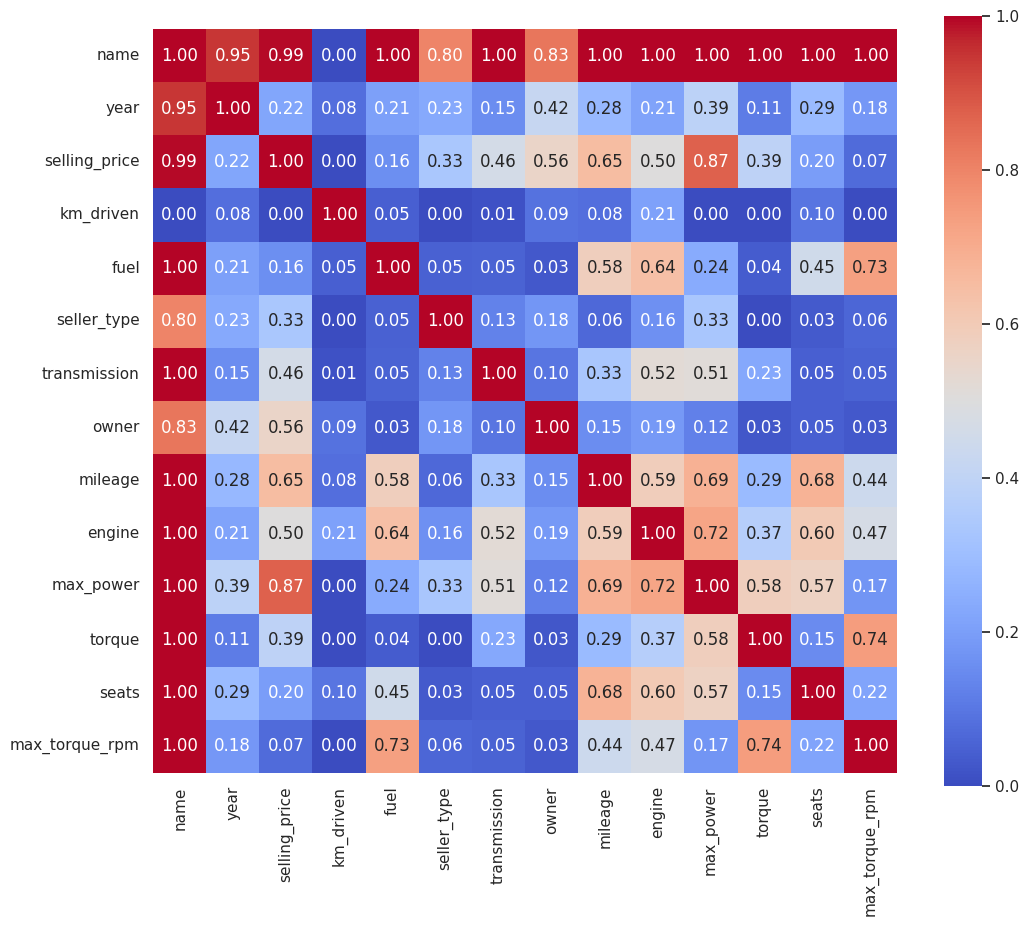

In [59]:
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(phik_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)

1) Очень сильная положительная корреляция между именем автомобиля и ценой, а также ценой и мощностью
2) Положительная корреляция междугодом выпуска, типом топлива,  продавца и трансмиссии, количеством владельцев, расходом топлива, объемом и моментом двигателя, количеством сидений и  ценой
3) Обороты и пробег, согласно данной матрице, не влияют на цену

### **Дополнительные визуализации (бонус 0.25 балла)**

Если вам кажется, что мы не попросили вас нарисовать какие-то очень важные зависимости, нарисуйте их и поясните.
Один график: 0.125 балла, при условии, что он обоснован.

Построим график распределения целевой переменной

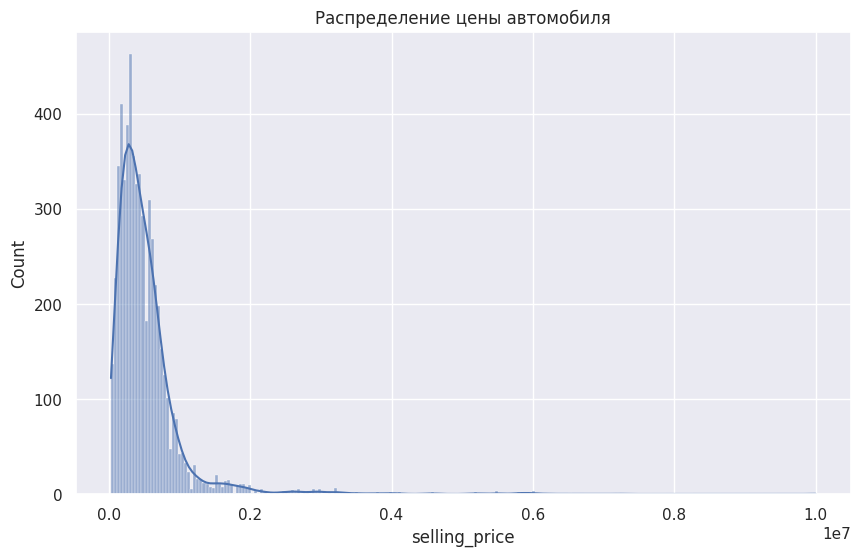

In [60]:
plt.figure(figsize=(10, 6))
sns.histplot(df_train['selling_price'], kde=True)
plt.title('Распределение цены автомобиля')
plt.show()

Из него видно, что распределение сильно скошено вправо. Для приведения переменной к нормальному распределению и более наглядной оценки выбросов ее можно логарифмировать

<Axes: xlabel='selling_price', ylabel='Count'>

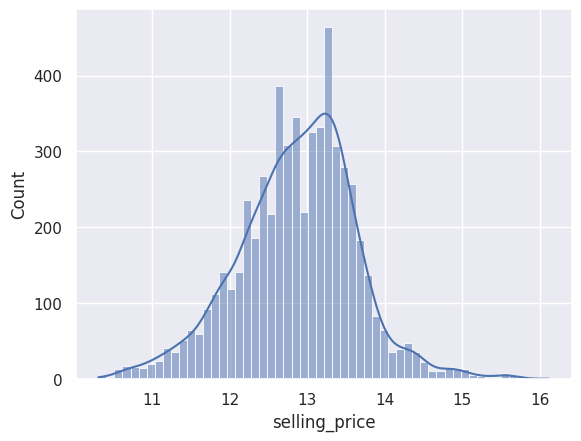

In [61]:
sns.histplot(np.log(df_train['selling_price']), kde=True)

Логарифм целевой переменной имеет практически нормальное распределение за исключением некоторых выбросов

Построим графики для оценки цены автомобиля по разным категориям - тип топлива, тип трансмиссии, количество сидений, а также найдем топ-10 самых дорогих марок авто

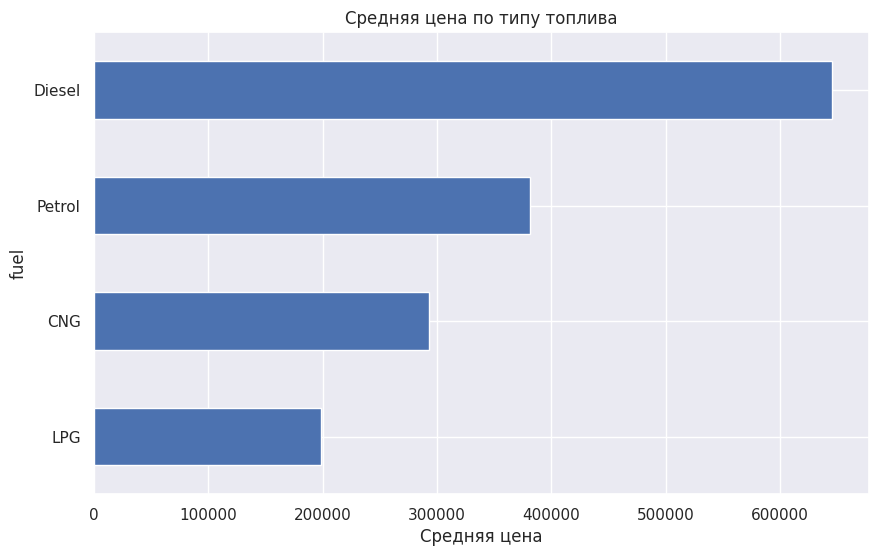

In [62]:
fuel_price = df_train.groupby('fuel')['selling_price'].mean().sort_values()
fuel_price.plot(kind='barh', figsize=(10, 6))
plt.title('Средняя цена по типу топлива')
plt.xlabel('Средняя цена')
plt.show()

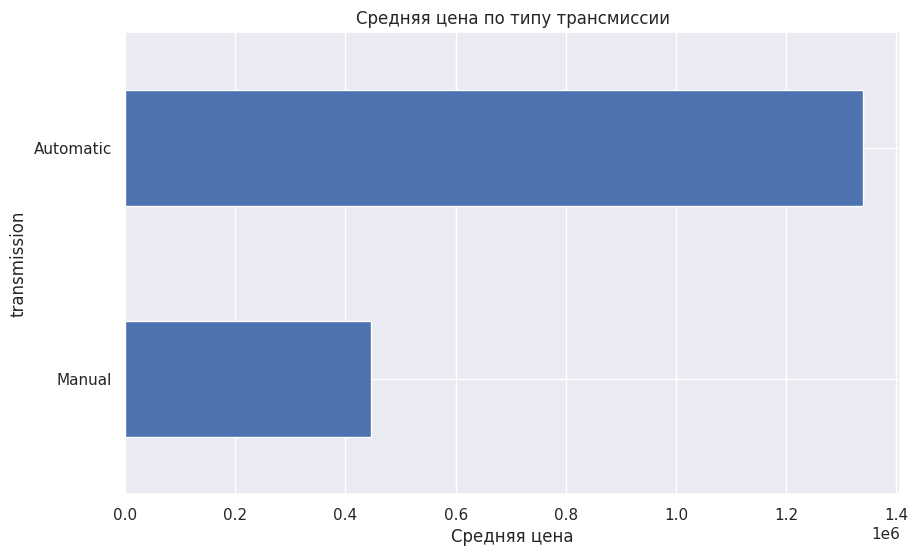

In [63]:
transmission = df_train.groupby('transmission')['selling_price'].mean().sort_values()
transmission.plot(kind='barh', figsize=(10, 6))
plt.title('Средняя цена по типу трансмиссии')
plt.xlabel('Средняя цена')
plt.show()

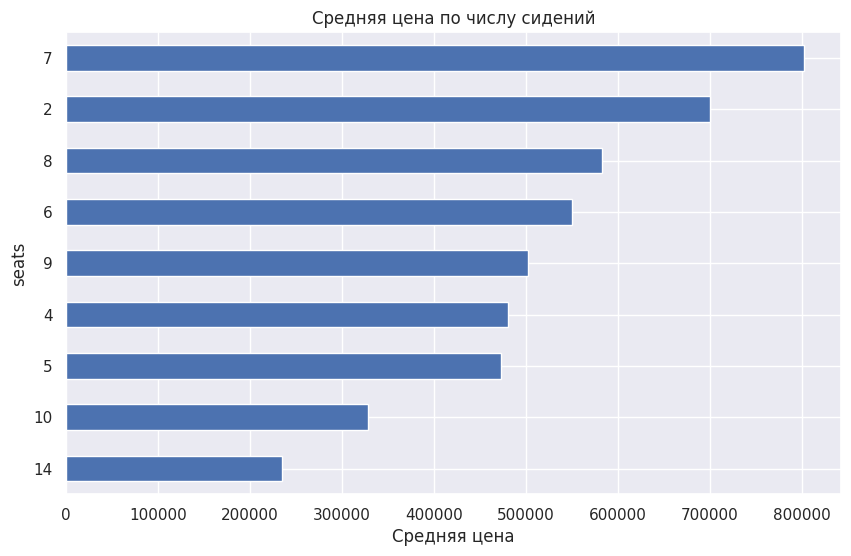

In [64]:
seats = df_train.groupby('seats')['selling_price'].mean().sort_values()
seats.plot(kind='barh', figsize=(10, 6))
plt.title('Средняя цена по числу сидений')
plt.xlabel('Средняя цена')
plt.show()

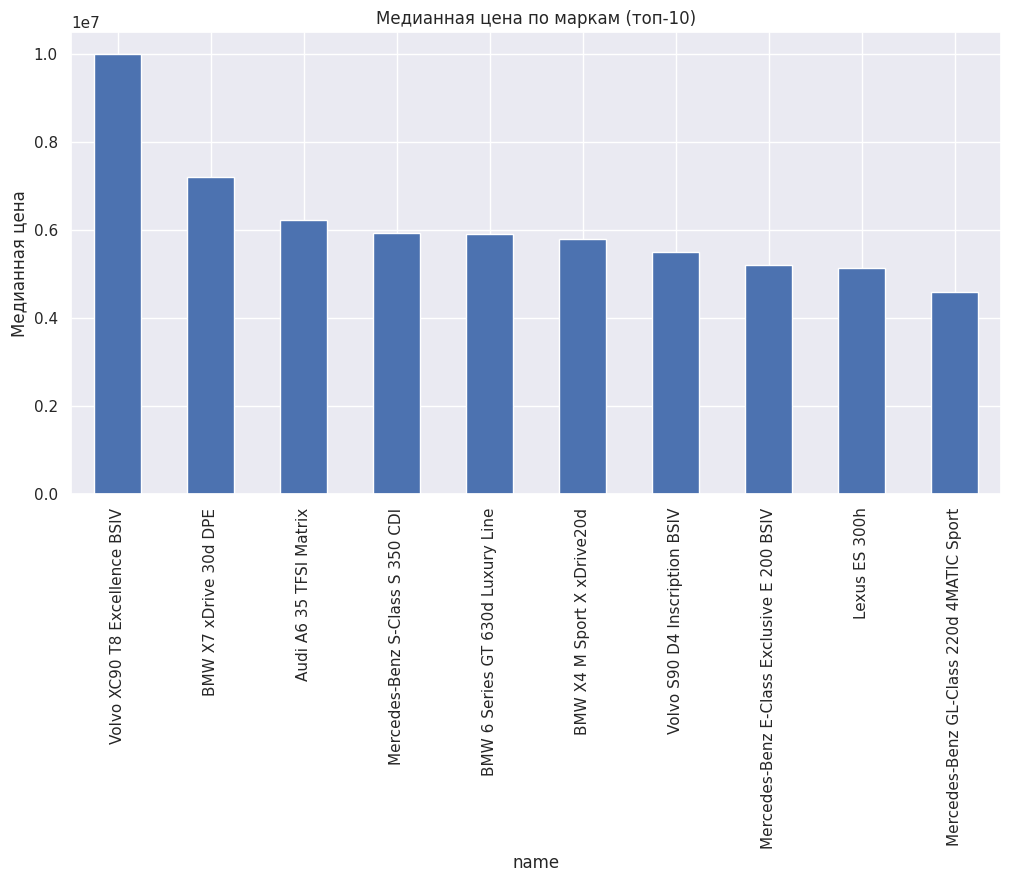

In [65]:
plt.figure(figsize=(12, 6))
df_train.groupby('name')['selling_price'].median().sort_values(ascending=False).head(10).plot(kind='bar')
plt.title('Медианная цена по маркам (топ-10)')
plt.ylabel('Медианная цена')
plt.show()

Построим "ящики с усами" для оценки выбросов в числовых переменных

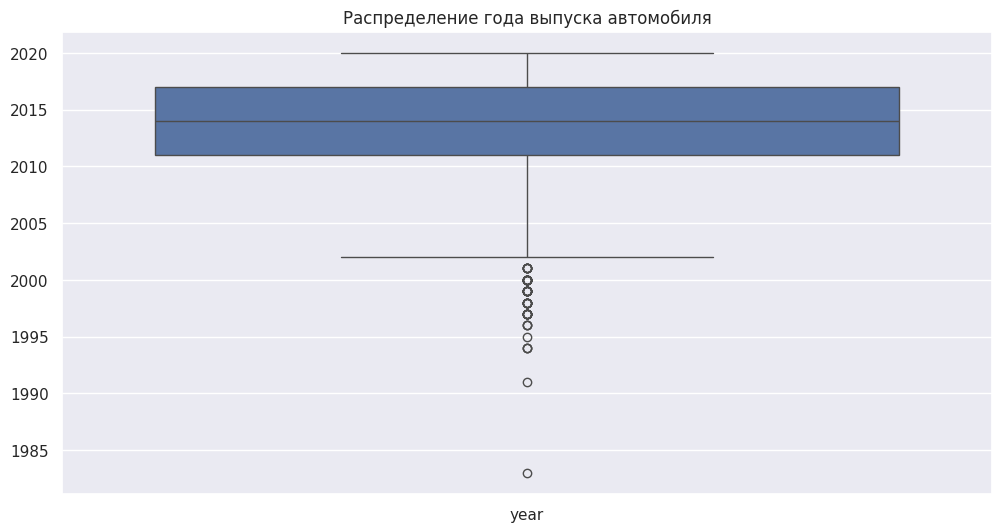

In [66]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train[['year']])
plt.title('Распределение года выпуска автомобиля')
plt.show()

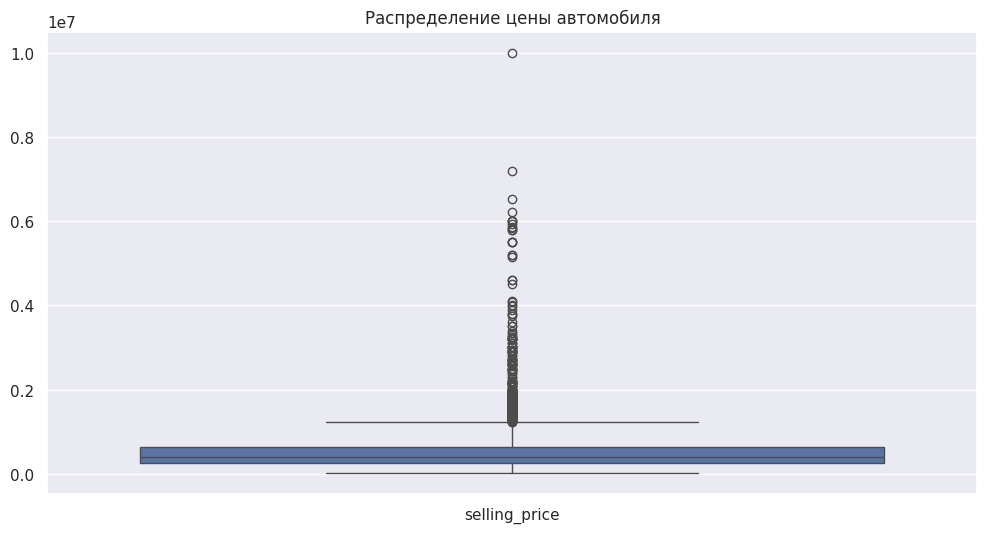

In [67]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train[['selling_price']])
plt.title('Распределение цены автомобиля')
plt.show()

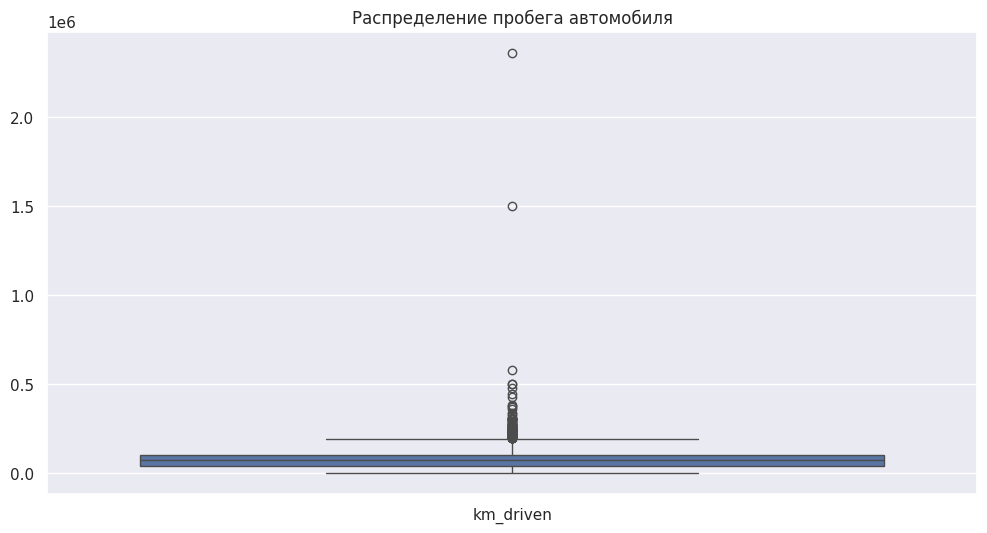

In [68]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train[['km_driven']])
plt.title('Распределение пробега автомобиля')
plt.show()

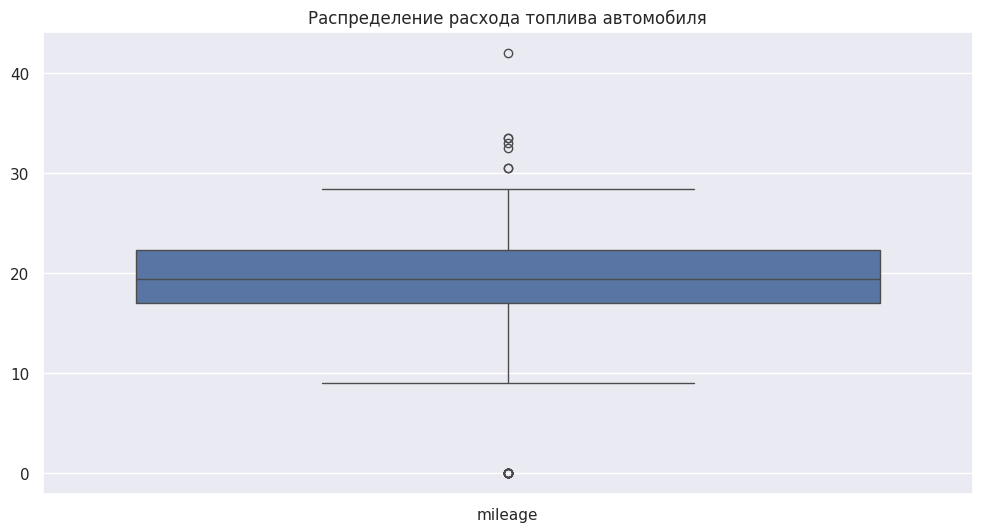

In [69]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train[['mileage']])
plt.title('Распределение расхода топлива автомобиля')
plt.show()

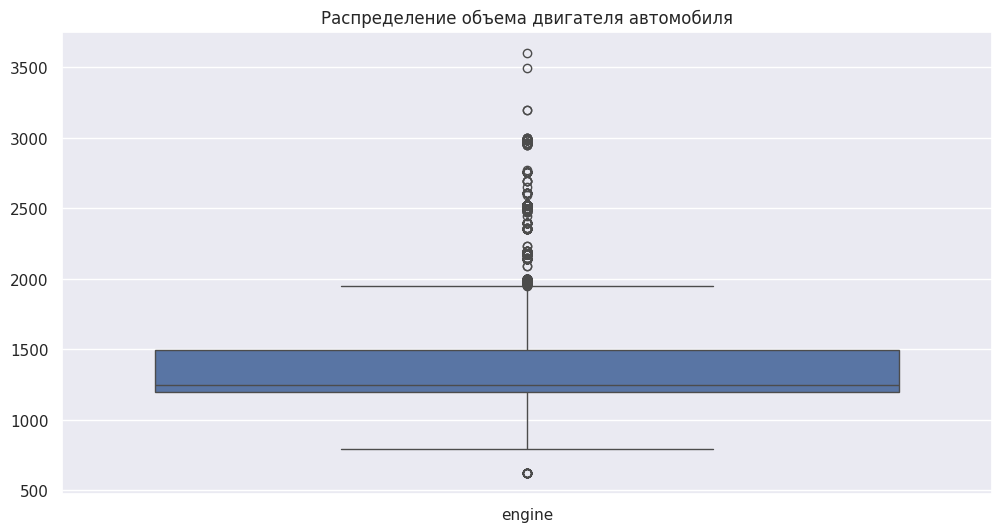

In [70]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train[['engine']])
plt.title('Распределение объема двигателя автомобиля')
plt.show()

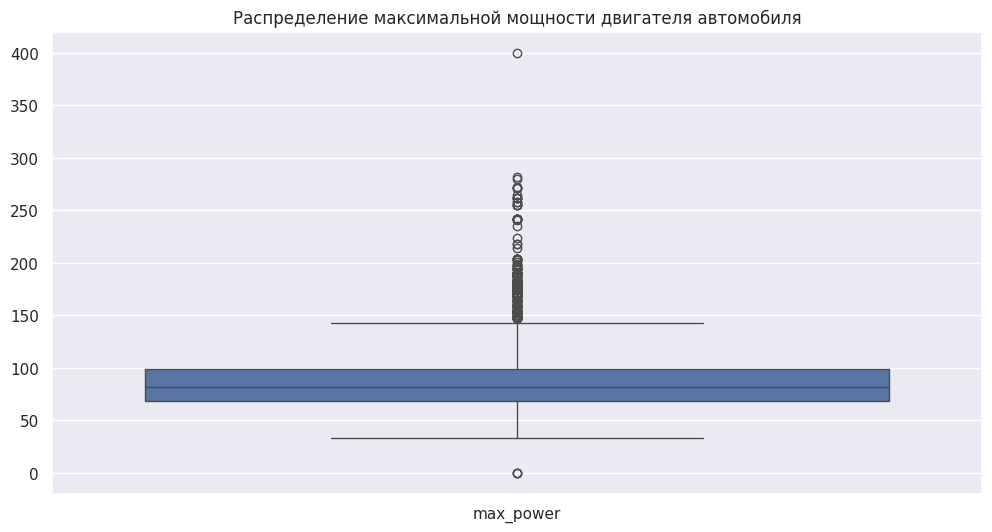

In [71]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train[['max_power']])
plt.title('Распределение максимальной мощности двигателя автомобиля')
plt.show()

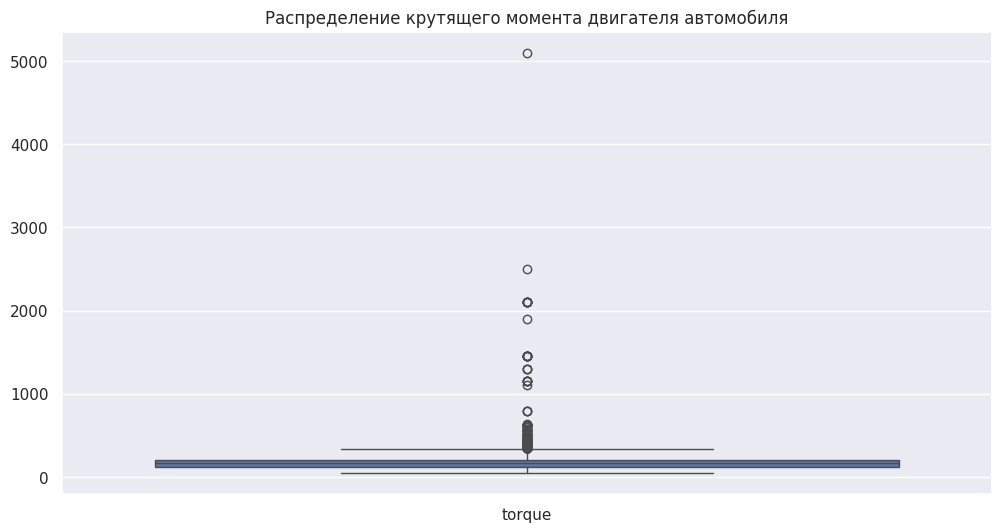

In [72]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train[['torque']])
plt.title('Распределение крутящего момента двигателя автомобиля')
plt.show()

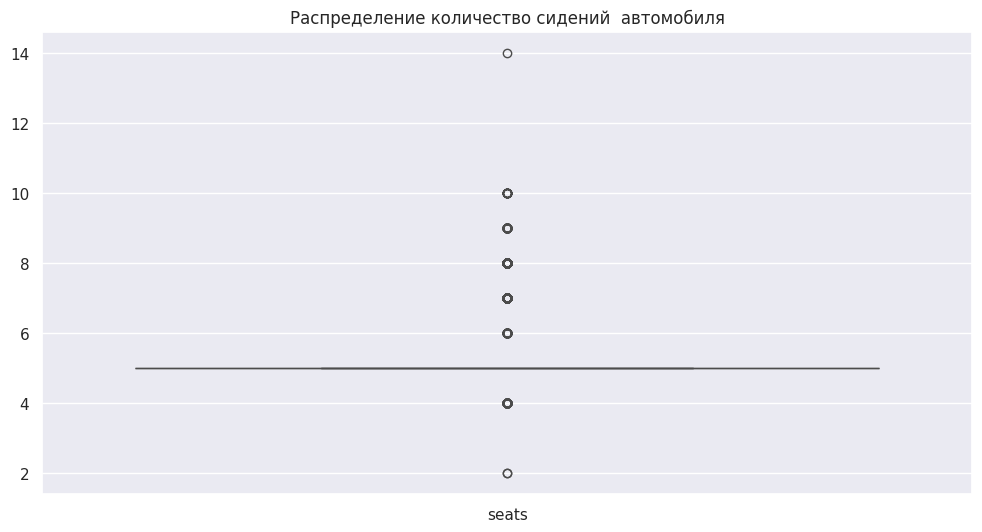

In [73]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train[['seats']])
plt.title('Распределение количество сидений  автомобиля')
plt.show()

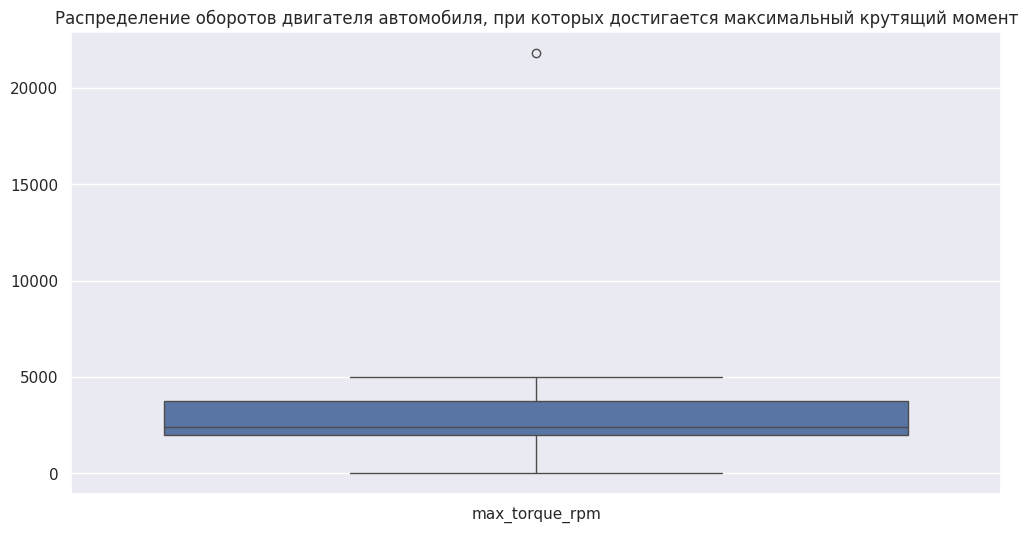

In [74]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_train[['max_torque_rpm']])
plt.title('Распределение оборотов двигателя автомобиля, при которых достигается максимальный крутящий момент')
plt.show()

Подводя итог, можно сказать, что практически все переменные имеют значения за пределами 1.5IQR, но далеко не все они являются выбросами

# **Часть 2 (1.7 балла) | Модель только на вещественных признаках**

В этой части вам предстоит обучить модель только на вещественных признаках. Почему только на них?

Чем больше признаковое пространство — чем сложнее модель. А чем модель проще — тем лучше для скорости работы и интерпретации признаков.

За задания этой части вы можете набрать 1.7 основных и 0.15 бонусных балла;

In [75]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5840 non-null   object 
 1   year            5840 non-null   int64  
 2   selling_price   5840 non-null   int64  
 3   km_driven       5840 non-null   int64  
 4   fuel            5840 non-null   object 
 5   seller_type     5840 non-null   object 
 6   transmission    5840 non-null   object 
 7   owner           5840 non-null   object 
 8   mileage         5840 non-null   float64
 9   engine          5840 non-null   int32  
 10  max_power       5840 non-null   float64
 11  torque          5840 non-null   float64
 12  seats           5840 non-null   int32  
 13  max_torque_rpm  5840 non-null   float64
dtypes: float64(4), int32(2), int64(3), object(5)
memory usage: 593.3+ KB


### **Задание 11 (0.05 балла)**

Разбейте данные на тренировочный и тестовый наборы. Перед разбиением создайте копию датафрейма, который будет хранить только вещественные признаки и используйте его (то есть категориальные столбцы (все, кроме seats) необходимо удалить).

В переменные y_train и y_test запишите значения целевых переменных.

In [76]:
df_float_train = df_train[['selling_price','year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque','seats', 'max_torque_rpm']].copy()
df_float_train

,selling_price,year,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
0,450000,2014,145500,23.40,1248,74.00,190.00,5,2000.0
1,370000,2014,120000,21.14,1498,103.52,250.00,5,2000.0
2,225000,2010,127000,23.00,1396,90.00,224.00,5,2250.0
3,130000,2007,120000,16.10,1298,88.20,115.00,5,4500.0
4,440000,2017,45000,20.14,1197,81.86,113.75,5,4000.0
...,...,...,...,...,...,...,...,...,...
5835,120000,2008,191000,17.92,1086,62.10,96.10,5,3000.0
5836,260000,2013,50000,18.90,998,67.10,90.00,5,3500.0
5837,320000,2013,110000,18.50,1197,82.85,113.70,5,4000.0
5838,135000,2007,119000,16.80,1493,110.00,240.00,5,2325.0


In [77]:
y_train = df_float_train['selling_price']
X_train = df_float_train.drop(['selling_price'], axis=1)

In [78]:
df_float_test = df_test[['selling_price','year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque','seats', 'max_torque_rpm']].copy()
df_float_test

,selling_price,year,km_driven,mileage,engine,max_power,torque,seats,max_torque_rpm
0,229999,2010,168000,14.00,2498,112.00,260.00,7,2000.0
1,665000,2017,25000,21.50,1497,108.50,260.00,5,2125.0
2,175000,2007,218463,12.90,1799,130.00,172.00,5,4300.0
3,635000,2015,173000,25.10,1498,98.60,200.00,5,1750.0
4,130000,2011,70000,16.50,1172,65.00,96.00,5,3000.0
...,...,...,...,...,...,...,...,...,...
995,250000,2008,100000,19.81,1086,68.05,99.04,5,4500.0
996,440000,2017,50000,18.60,1197,81.83,114.70,5,4000.0
997,340000,2009,40000,23.00,1396,90.00,224.00,5,2250.0
998,350000,2012,25000,20.36,1197,78.90,111.80,5,4000.0


In [79]:
y_test = df_float_test['selling_price']
X_test = df_float_test.drop(['selling_price'], axis=1)

### **Задание 12. (0.2 балла)**

Построим нашу первую модель!
- [ ] Обучите классическую линейную регрессию с дефолтными параметрами. Посчтитайте $R^2$ и $MSE$ для трейна и для теста.
- [ ] Сделайте выводы по значениям метрик качества.

**Примечание:**

Здесь и далее $R^2$ и $MSE$ для трейна и для теста выводите везде, где требуется обучать модели, даже если в явном виде этого не просят. Иначе непонятно, как понять, насколько успешны наши эксперименты.

In [80]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

train_mse = MSE(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mse = MSE(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print('Train MSE = ', train_mse)
print('Train R2 score = ', train_r2)
print('Test MSE = ', test_mse)
print('Test R2 score = ', test_r2)

Train MSE =  113917301299.13365
Train R2 score =  0.6025747918029705
Test MSE =  228368466241.61353
Test R2 score =  0.6027189950785035


### **Задание 13 (0.15 балла)**

- [ ] Реализуйте $R^2$ руками. Приведите формулу $R^2$ и объясните каждую компоненту метрики

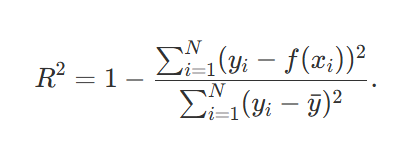

yi - истинные значения

f(xi) - предскаданные значения

y с чертой - среднее арифметическое истинных значений

In [81]:
def r2(y, y_pred):
  num = np.sum((y - y_pred) ** 2)
  denom = np.sum((y - np.mean(y)) ** 2)
  r2 = 1 - num/denom
  return float(r2)

In [82]:
print('Adj R2 Train = ', r2(y_train, y_train_pred))
print('Adj R2 Test = ', r2(y_test, y_test_pred))

Adj R2 Train =  0.6025747918029705
Adj R2 Test =  0.6027189950785035


Результаты реализованной функции совпадают с библиотечной

`Your answer here`

### **Бонус (0.15 балла)**

- [ ] Реализуйте [$\text{adjusted}-R^2$](https://en.wikipedia.org/wiki/Coefficient_of_determination).
- [ ] Объясните, когда применяется $\text{adjusted}-R^2$?

In [83]:
def adj_r2(y, y_pred, n, p):
  def r2(y, y_pred):
    num = np.sum((y - y_pred) ** 2)
    denom = np.sum((y - np.mean(y)) ** 2)
    r2 = 1 - num/denom
    return float(r2)

  r2 = r2(y, y_pred)
  adj_r2 =  1 - (1 - r2) * (n - 1) / (n - p - 1)
  return adj_r2

In [84]:
n_train = X_train.shape[0]
n_test = X_test.shape[0]

p = X_train.shape[1]

adj_r2_train = adj_r2(y_train, y_train_pred, n_train, p)
adj_r2_test = adj_r2(y_train, y_train_pred, n_test, p)

print(adj_r2_train)
print(adj_r2_test)

0.6020295334140875
0.5993665156520358


`Your answer here`

### **Задание 14 (0.05 балла)**

Всегда есть место совершенству. Поэтому давайте попробуем улучшить модель. При помощи стандартизации признаков.

- [ ] Стандартизируйте значения в тренировочных и тестовых данных. Стандартизатор **обучайте только на `train`**.

In [85]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


lr_scaled = LinearRegression()
lr_scaled.fit(X_train_scaled, y_train)

y_train_pred_scaled = lr_scaled.predict(X_train_scaled)
y_test_pred_scaled = lr_scaled.predict(X_test_scaled)

train_mse_scaled = MSE(y_train, y_train_pred_scaled)
train_r2_scaled = r2_score(y_train, y_train_pred_scaled)
test_mse_scaled = MSE(y_test, y_test_pred_scaled)
test_r2_scaled = r2_score(y_test, y_test_pred_scaled)

print('Train MSE = ', train_mse_scaled)
print('Train R2 score = ', train_r2_scaled)
print('Test MSE = ', test_mse_scaled)
print('Test R2 score = ', test_r2_scaled)

Train MSE =  113917301299.1334
Train R2 score =  0.6025747918029714
Test MSE =  228368466241.61325
Test R2 score =  0.602718995078504


### **Задание 15 (0.1 балла)**

Хотя стандартизация не помогла сильно прибавить в качестве она открыла возможность интерпретировать важность признаков в модели. Правило интерпретации такое:

Чем больше коэффициент $\beta_i$ по модулю, тем важнее признак.

**Ответьте на вопрос:**

- [ ] Какой признак оказался наиболее информативным в предсказании цены?

In [86]:
coefficients = lr_scaled.coef_
d = {}
for feature, coef in zip(X_train.columns, coefficients):
    d[feature] = coef
d = sorted(d.items(), key=lambda item: item[1], reverse=True)
coefs = pd.DataFrame.from_dict(d)
display(coefs)
print('Самый информативный признак в предсказании цены: ', coefs.iloc[0, 0])

,0,1
0,max_power,325596.324333
1,year,166295.735471
2,engine,12570.566551
3,torque,10041.465377
4,mileage,-11852.254109
5,seats,-31085.431894
6,km_driven,-50121.131146
7,max_torque_rpm,-66610.976960


Самый информативный признак в предсказании цены:  max_power


### **Задание 16 (0.25 балла)**

Попробуем улучшить нашу модель с помощью применения регуляризации. Для этого воспльзуемся `Lasso` регрессией.  Кроме того, попробуйте использовать её теоретическое свойство отбора признаков, за счет зануления незначимых коэффициентов.

**Задание:**

- [ ] Обучите Lasso регрессию на тренировочном наборе данных с нормализованными признаками. Оцените её качество
- [ ] Проверьте, занулила ли L1-регуляризация с параметрами по умолчанию какие-нибудь веса? Предположите почему.

In [87]:
from sklearn.linear_model import Lasso
lasso = Lasso(max_iter=10000)
lasso.fit(X_train_scaled, y_train)

y_train_pred_lasso= lasso.predict(X_train_scaled)
y_test_pred_lasso = lasso.predict(X_test_scaled)

train_mse_lasso = MSE(y_train, y_train_pred_lasso)
train_r2_lasso = r2_score(y_train, y_train_pred_lasso)
test_mse_lasso = MSE(y_test, y_test_pred_lasso)
test_r2_lasso = r2_score(y_test, y_test_pred_lasso)

print('Train MSE = ', train_mse_lasso)
print('Train R2 score = ', train_r2_lasso)
print('Test MSE = ', test_mse_lasso)
print('Test R2 score = ', test_r2_lasso)


Train MSE =  113917301312.0363
Train R2 score =  0.6025747917579568
Test MSE =  228369234513.9445
Test R2 score =  0.6027176585542069


In [88]:
coefficients = lasso.coef_
d = {}
for feature, coef in zip(X_train.columns, coefficients):
    d[feature] = coef
d = sorted(d.items(), key=lambda item: item[1], reverse=True)
coefs = pd.DataFrame.from_dict(d)
display(coefs)


,0,1
0,max_power,325597.702500
1,year,166293.634827
2,engine,12568.623926
3,torque,10040.980512
4,mileage,-11849.150273
5,seats,-31081.514015
6,km_driven,-50120.169475
7,max_torque_rpm,-66608.924359


Как можно увидеть, модель Lasso не занулила ни одного коэффициента

### **Задание 17. Финальный рывок (0.4 балла)**

До этого мы с вами использовали `train` для обучения и `test` для прогнозирования. Но у нас есть ещё одна задача — подобрать оптимальные параметры модели. Для этого используем кросс-валидацию, описанную на семинарах.

Кроме того, выжмем максимум из модификаций регрессии. Построим `ElasticNet`. И сделаем всё по порядку.

**Ваша задача 1:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для Lasso-регрессии. Вам пригодится класс [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).
- [ ] Ответьте на вопросы:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Что значит каждый параметр `param_grid`, который вы заполняли для `GridSearch`? Опишите каждый
 - Какой коэффициент регуляризации у лучшей из перебранных моделей? Занулились ли какие-нибудь из весов при такой регуляризации?

In [89]:
# Определение сетки гиперпараметров
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],  # ← ограничьте разумно
    'max_iter': [10000],                 # ← увеличьте
    'tol': [1e-4]
}

# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=lasso,
    param_grid=param_grid,
    scoring='r2',
    cv=10,
    n_jobs=-1,
    verbose=1
)

# Обучение GridSearch
grid_search.fit(X_train_scaled, y_train)

# Лучшие параметры и оценка
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая CV-оценка (R2):", grid_search.best_score_)

# Предсказание на тестовой выборке
y_pred_gs = grid_search.predict(X_test_scaled)
test_mse_gs = MSE(y_test, y_pred_gs)
test_r2_gs = r2_score(y_test, y_pred_gs)
print("Тестовый MSE:", test_mse_gs)
print("Тестовый R2:", test_r2_gs)
print("Коэффициенты модели:", grid_search.best_estimator_.coef_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Лучшие параметры: {'alpha': 10, 'max_iter': 10000, 'tol': 0.0001}
Лучшая CV-оценка (R2): 0.5755254667390456
Тестовый MSE: 228376191416.41443
Тестовый R2: 0.6027055559848379
Коэффициенты модели: [166273.95833254 -50111.62575389 -11820.07497237  12551.4677103
 325610.36609824  10036.64862638 -31045.77215443 -66590.0302456 ]


 Грид-сёрчу пришлось обучать 50 моделей

 alpha - коэффициент регуляризации

 max_iter максимальное количество итераций для сходимости

 tol — точность сходимости

 Наилучший коэффициент альфа = 10, ни один вес не занулился

**Ваша задача 2:**

- [ ] Перебором по сетке (c 10-ю фолдами) подберите оптимальные параметры для [ElasticNet](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html) регрессии.
- [ ] Ответьте на вопрос:
 - Сколько грид-сёрчу пришлось обучать моделей?
 - Какие гиперпараметры соответствуют лучшей (по выбранной метрике качества) из перебранных моделей?

In [90]:
elastic = ElasticNet()



# Определение сетки гиперпараметров
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0],
    'l1_ratio': [0.1, 0.2, 0.22, 0.3, 0.5, 0.7, 0.9, 0.95, 0.99, 1.0]
}

# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=elastic,
    param_grid=param_grid,
    scoring='r2',
    cv=10,
    n_jobs=-1,
    verbose=1
)

# Обучение GridSearch
grid_search.fit(X_train_scaled, y_train)

# Лучшие параметры и оценка
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая CV-оценка (R2):", grid_search.best_score_)

# Предсказание на тестовой выборке
y_pred_gs = grid_search.predict(X_test_scaled)
test_mse_gs = MSE(y_test, y_pred_gs)
test_r2_gs = r2_score(y_test, y_pred_gs)
print("Тестовый MSE:", test_mse_gs)
print("Тестовый R2:", test_r2_gs)
print("Коэффициенты модели:", grid_search.best_estimator_.coef_)

Fitting 10 folds for each of 40 candidates, totalling 400 fits
Лучшие параметры: {'alpha': 10.0, 'l1_ratio': 0.99}
Лучшая CV-оценка (R2): 0.5826608096070608
Тестовый MSE: 241733352782.4669
Тестовый R2: 0.5794687817587958
Коэффициенты модели: [154071.20316771 -52335.1038057   -2479.36800026  48184.16315178
 275619.49788316  22461.94739612 -32184.2332957  -51497.23573744]


### **Задание 18 (0.35 балла)**

И так, вы обучили все варианты регуляризаций, доступные в sklearn, но не все, что мы обсудили на занятии! И следующее задание о забытой - $L0$ регуляризации.


**Ваша задача:**>
- [ ] Реализуйте модель с $L0$-регуляризаицей.
- [ ] Обучите модель на данных и проанализируйте результат, экспериментируя с коэффициенитом регуляризации
- [ ] Проанализируйте результаты обучения

**Важно:**

Вопреки тому, что L0 не реализована в стандартных пакетах, концепция данной регуляризации не является мертвой. Она может встречаться в [статьях](https://arxiv.org/abs/1712.01312) и экспериментах.



In [91]:
#made by GigaCode :)

class LinearRegressionIHT(BaseEstimator, RegressorMixin):
    def __init__(self, k=5, learning_rate=0.1, max_iter=1000, tol=1e-6):
        self.k = k
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol

    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w_ = np.zeros(n_features, dtype=np.float64)
        self.b_ = 0.0

        # Инициализируем coef_ и intercept_ — важно для совместимости с sklearn
        self.coef_ = self.w_
        self.intercept_ = self.b_

        for i in range(self.max_iter):
            y_pred = X @ self.w_ + self.b_

            # Вычисляем градиенты
            dw = (2 / n_samples) * X.T @ (y_pred - y)
            db = (2 / n_samples) * np.sum(y_pred - y)

            # Шаг градиентного спуска
            w_new = self.w_ - self.learning_rate * dw
            b_new = self.b_ - self.learning_rate * db

            # Проверка на nan/inf
            if np.any(np.isnan(w_new)) or np.any(np.isinf(w_new)):
                # Прерываем обучение при нестабильности
                break

            # Hard thresholding: оставляем k наибольших по модулю
            idx = np.argsort(np.abs(w_new))[-self.k:]
            w_hard = np.zeros_like(w_new)
            w_hard[idx] = w_new[idx]

            # Проверка сходимости
            w_change = np.linalg.norm(w_hard - self.w_)
            self.w_ = w_hard
            self.b_ = b_new

            # Обновляем coef_ и intercept_
            self.coef_ = self.w_
            self.intercept_ = self.b_

            if w_change < self.tol:
                break

            # Ранняя остановка при переполнении
            if np.any(np.isnan(self.w_)) or np.any(np.isinf(self.w_)):
                break

        return self

    def predict(self, X):
        return X @ self.w_ + self.b_

    def score(self, X, y):
        y_pred = self.predict(X)
        ss_res = np.sum((y - y_pred) ** 2)
        ss_tot = np.sum((y - np.mean(y)) ** 2)
        return 1 - (ss_res / ss_tot) if ss_tot != 0 else -np.inf


In [92]:
L0 = LinearRegressionIHT(k=3)
L0.fit(X_train_scaled, y_train)

y_train_pred_L0= L0.predict(X_train_scaled)
y_test_pred_L0 = L0.predict(X_test_scaled)

train_mse_L0 = MSE(y_train, y_train_pred_L0)
train_r2_L0 = r2_score(y_train, y_train_pred_L0)
test_mse_L0 = MSE(y_test, y_test_pred_L0)
test_r2_L0 = r2_score(y_test, y_test_pred_L0)

print('Train MSE = ', train_mse_L0)
print('Train R2 score = ', train_r2_L0)
print('Test MSE = ', test_mse_L0)
print('Test R2 score = ', test_r2_L0)


Train MSE =  119245324280.5855
Train R2 score =  0.5839868282668456
Test MSE =  241343298480.9833
Test R2 score =  0.580147339387253


In [93]:
X_train_scaled_L0 = X_train_scaled.copy()
X_test_scaled_L0 = X_test_scaled.copy()

In [94]:
L0 = LinearRegressionIHT()


# Определение сетки гиперпараметров
param_grid = {
    'k': [1, 2, 3, 4, 5, 6],                    # разумные значения sparsity
    'learning_rate': [0.05, 0.1, 0.2],    # избегаем слишком малых шагов
    'max_iter': [500],                     # не 1000 — чтобы уменьшить риск переполнения
    'tol': [1e-4]                          # не слишком строгое
}

# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=L0,
    param_grid=param_grid,
    scoring='r2',
    cv=10,
    n_jobs=-1,
    verbose=1
)

# Обучение GridSearch
grid_search.fit(X_train_scaled, y_train)

# Лучшие параметры и оценка
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая CV-оценка (R2):", grid_search.best_score_)

# Предсказание на тестовой выборке
y_pred_gs = grid_search.predict(X_test_scaled)
test_mse_gs = MSE(y_test, y_pred_gs)
test_r2_gs = r2_score(y_test, y_pred_gs)
print("Тестовый MSE:", test_mse_gs)
print("Тестовый R2:", test_r2_gs)
print("Коэффициенты модели:", grid_search.best_estimator_.coef_)


Fitting 10 folds for each of 18 candidates, totalling 180 fits
Лучшие параметры: {'k': 3, 'learning_rate': 0.2, 'max_iter': 500, 'tol': 0.0001}
Лучшая CV-оценка (R2): 0.5806668231978867
Тестовый MSE: 239060435932.35138
Тестовый R2: 0.5841187192469339
Коэффициенты модели: [177598.99053366      0.              0.              0.
 335211.98953302      0.              0.         -51682.23873991]


# **Часть 3 (0.5 балла) | Добавляем категориальные фичи**

Попробуем для улучшения модели дать ей больше признаков. Добавим категориальные фичи.

За эту часть можно набрать 0.5 основных балла.



### **Задание 19 (0.1 балла)**

Проанализируйте столбец `name`. Очевидно, что эта переменная является категориальной, однако категорий в ней много.

- [ ] Предобработайте столбец `name`, чтобы избежать его удаления

Произведем парсинг параметра name с помощью LLM GigaCode

In [95]:
# Список марок
BRANDS = [
    'Maruti', 'Hyundai', 'Toyota', 'Ford', 'Mahindra', 'Honda', 'Tata', 'Skoda',
    'Renault', 'Volkswagen', 'Chevrolet', 'Datsun', 'Nissan', 'BMW', 'Mercedes-Benz',
    'Audi', 'MG', 'Jeep', 'Mitsubishi', 'Fiat', 'Isuzu', 'Peugeot', 'Volvo', 'Lexus',
    'Jaguar', 'Land Rover', 'Kia', 'Force', 'Ambassador', 'Daewoo', 'Ssangyong','Opel','Ashok'
]

# Типы топлива
FUEL_TYPES = [
    'Diesel', 'Petrol', 'CNG', 'LPG', 'Electric', 'Hybrid'
]

# Аббревиатуры, указывающие на тип топлива
FUEL_CODES = [
    'TDI', 'CRDi', 'DICOR', 'Revotorq', 'mHawk', 'dCi', 'DDiS', 'Kappa',
    'VTVT', 'VT', 'VVT', 'i-VTEC', 'i DTEC', 'i DTec', 'VX', 'VXi'
]

# Типы трансмиссии
TRANSMISSION = [
    'AMT', 'AT', 'MT', 'DCT', 'CVT', 'Manual', 'Automatic'
]

# Привод
DRIVE_TYPE = [
    '4x4', '4X4', 'AWD', '2WD', 'FWD', '4x2', '4WD'
]

# Экологические стандарты
EMISSION = [
    'BSII', 'BSIII', 'BSIV'
]

# Специальные версии
EDITIONS = [
    'Celebration', 'Limited Edition', 'Special Edition', 'Anniversary Edition',
    'Signature', 'Sports Edition', 'TRD Sportivo', 'Hurricane Limited',
    'Dark Edition', 'Stepway', 'Adventure Edition', 'Windsong Limited',
    'Knightracer', 'Corporate Edition', 'Premium', 'Luxury', 'Prestige',
    'Elegance', 'Style', 'Ambition', 'Option', 'Optional', 'Plus', 'Dual Tone'
]

# Комплектации (часто встречаются)
VARIANTS = [
    'VXI', 'ZXI', 'LDI', 'VDI', 'ZDI', 'LXi', 'LX', 'EX', 'EXi', 'LXI', 'VXi',
    'VX', 'ZXi', 'Alpha', 'Delta', 'Zeta', 'Sigma', 'Era', 'Magna', 'Sportz',
    'Asta', 'SX', 'SX+', 'GLS', 'GLE', 'GLX', 'GVS', 'VTEC', 'CRDi', 'S', 'E',
    'V', 'Z', 'L', 'H', 'X', 'R', 'STD', 'BASE', 'ABS', 'Airbag', 'Sunroof'
]

In [96]:
def extract_features(name):
    if not isinstance(name, str):
        name = ""
    original = name
    features = {
        'brand': None,
        'model': None,
        'variant': None,
        'engine_size': None,
        'fuel_type': None,
        'transmission': None,
        'drive_type': None,
        'seating_capacity': None,
        'edition': None,
        'emission': None
    }

    # 1. Извлечение марки
    for brand in sorted(BRANDS, key=len, reverse=True):
        if brand in name:
            features['brand'] = brand
            name = name.replace(brand, "", 1).strip()
            break

    # 2. Извлечение экологического стандарта
    for em in EMISSION:
        if em in name:
            features['emission'] = em
            name = name.replace(em, "").strip()

    # 3. Извлечение типа трансмиссии
    for trans in TRANSMISSION:
        if trans in name:
            features['transmission'] = trans
            name = name.replace(trans, "").strip()

    # 4. Извлечение привода
    for drive in DRIVE_TYPE:
        if drive in name:
            features['drive_type'] = drive
            name = name.replace(drive, "").strip()

    # 5. Извлечение количества мест
    seating_match = re.search(r'(\d+)\s*Seater|(\d+)\s*Seats|(\d+)\s*STR', original, re.IGNORECASE)
    if seating_match:
        features['seating_capacity'] = int(seating_match.group(1) or seating_match.group(2) or seating_match.group(3))

    # 6. Извлечение объёма двигателя
    engine_match = re.search(r'\b(\d+\.\d+|\d+)\s*(?:Litre|Litre|L|T|Litre|TDI|CRDi|VTVT|Petrol|Diesel|P)\b', original)
    if engine_match:
        features['engine_size'] = float(engine_match.group(1))

    # 7. Извлечение типа топлива
    # Сначала по словам
    for fuel in FUEL_TYPES:
        if fuel in original:
            features['fuel_type'] = fuel
            break
    # Если не найдено — по кодам
    if not features['fuel_type']:
        for code in FUEL_CODES:
            if code in original:
                features['fuel_type'] = 'Diesel' if code in ['TDI', 'CRDi', 'DICOR', 'dCi', 'Revotorq', 'mHawk', 'DDiS'] else 'Petrol'
                break

    # 8. Извлечение специальных версий
    editions_found = []
    for ed in sorted(EDITIONS, key=len, reverse=True):
        if ed in original and ed not in name:  # если было удалено ранее
            editions_found.append(ed)
    features['edition'] = ", ".join(editions_found) if editions_found else None

    # 9. Извлечение комплектации
    variants_found = []
    for v in sorted(VARIANTS, key=len, reverse=True):
        if re.search(rf'\b{re.escape(v)}\b', name):
            variants_found.append(v)
            name = re.sub(rf'\b{re.escape(v)}\b', "", name).strip()
    features['variant'] = ", ".join(variants_found) if variants_found else None

    # 10. Остаток — модель
    model = re.sub(r'[()]', "", name).strip()
    model = re.sub(r'\s+', ' ', model).strip()
    if model and model != features['variant']:
        features['model'] = model

    return pd.Series(features)

In [97]:
df_features_train = df_train['name'].apply(extract_features)
#df_features_train = pd.concat([df_train, df_features_train], axis=1)

df_features_test = df_test['name'].apply(extract_features)
#df_features_test = pd.concat([df_test, df_features_test], axis=1)

In [98]:
df_features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brand             5840 non-null   object 
 1   model             5840 non-null   object 
 2   variant           2978 non-null   object 
 3   engine_size       534 non-null    float64
 4   fuel_type         1909 non-null   object 
 5   transmission      498 non-null    object 
 6   drive_type        248 non-null    object 
 7   seating_capacity  252 non-null    float64
 8   edition           0 non-null      object 
 9   emission          729 non-null    object 
dtypes: float64(2), object(8)
memory usage: 456.4+ KB


In [99]:
df_features_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   brand             1000 non-null   object 
 1   model             1000 non-null   object 
 2   variant           547 non-null    object 
 3   engine_size       97 non-null     float64
 4   fuel_type         346 non-null    object 
 5   transmission      95 non-null     object 
 6   drive_type        32 non-null     object 
 7   seating_capacity  36 non-null     float64
 8   edition           0 non-null      object 
 9   emission          116 non-null    object 
dtypes: float64(2), object(8)
memory usage: 78.3+ KB


Как можно увидеть, в полученных данных очень много пропусков, кроме того, часть данных уже есть. Оставим только бренд, модель и комплектацию. Если комплектация неизвестна, напишем Unknown

In [100]:
df_features_train = df_features_train[['brand', 'model','variant']]
df_features_test = df_features_test[['brand', 'model','variant']]

In [101]:
df_features_train['variant'] = df_features_train['variant'].fillna('Unknown')
df_features_test['variant'] = df_features_test['variant'].fillna('Unknown')
df_features_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5840 entries, 0 to 5839
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   brand    5840 non-null   object
 1   model    5840 non-null   object
 2   variant  5840 non-null   object
dtypes: object(3)
memory usage: 137.0+ KB


In [102]:
df_final_train = pd.concat([df_train.drop('name', axis=1), df_features_train], axis=1)
df_final_test = pd.concat([df_test.drop('name', axis=1), df_features_test], axis=1)
df_final_train

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm,brand,model,variant
0,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.00,5,2000.0,Maruti,Swift Dzire,VDI
1,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.00,5,2000.0,Skoda,Rapid 1.5 TDI Ambition,Unknown
2,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,224.00,5,2250.0,Hyundai,i20 Diesel,Sportz
3,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,115.00,5,4500.0,Maruti,Swift I,VXI
4,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197,81.86,113.75,5,4000.0,Hyundai,Xcent 1.2 VTVT Plus,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92,1086,62.10,96.10,5,3000.0,Hyundai,Santro Xing,GLS
5836,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.90,998,67.10,90.00,5,3500.0,Maruti,Wagon BS IV with,"VXI, ABS, R"
5837,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197,82.85,113.70,5,4000.0,Hyundai,i20,Magna
5838,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493,110.00,240.00,5,2325.0,Hyundai,Verna,"CRDi, SX"


In [103]:
y_train = df_final_train['selling_price']
X_train = df_final_train.drop(['selling_price'], axis=1)

y_test = df_final_test['selling_price']
X_test = df_final_test.drop(['selling_price'], axis=1)

### **Задание 20 (0.1 балла)**

- [ ] Закодируйте категориалльные фичи и ``seats`` методом OneHot-кодирования.

In [104]:
cat_features = ['fuel', 'seller_type', 'transmission', 'owner', 'brand', 'model', 'variant', 'seats']

In [105]:

encoder = OneHotEncoder(drop = 'first', sparse_output = False, handle_unknown='ignore')
#encoder.fit(X_train[cat_features])

encoded_train_ohe = pd.DataFrame(encoder.fit_transform(X_train[cat_features]),index=X_train.index)
encoded_test_ohe = pd.DataFrame(encoder.transform(X_test[cat_features]), index=X_test.index)

encoded_train_ohe.columns = encoder.get_feature_names_out()
encoded_test_ohe.columns = encoder.get_feature_names_out()


X_train_onehot = X_train.join(encoded_train_ohe)
X_test_onehot = X_test.join(encoded_test_ohe)
X_train_onehot.drop(cat_features, axis = 1, inplace = True)
X_test_onehot.drop(cat_features, axis = 1, inplace = True)

assert encoded_train_ohe.index.equals(X_train.index), "Индексы не совпадают!"
assert encoded_test_ohe.index.equals(X_test.index), "Индексы теста не совпадают!"

X_train_onehot



,year,km_driven,mileage,engine,max_power,torque,max_torque_rpm,fuel_Diesel,fuel_LPG,fuel_Petrol,...,variant_Zeta,"variant_Zeta, S",seats_4,seats_5,seats_6,seats_7,seats_8,seats_9,seats_10,seats_14
0,2014,145500,23.40,1248,74.00,190.00,2000.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2014,120000,21.14,1498,103.52,250.00,2000.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2010,127000,23.00,1396,90.00,224.00,2250.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2007,120000,16.10,1298,88.20,115.00,4500.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2017,45000,20.14,1197,81.86,113.75,4000.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,2008,191000,17.92,1086,62.10,96.10,3000.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5836,2013,50000,18.90,998,67.10,90.00,3500.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5837,2013,110000,18.50,1197,82.85,113.70,4000.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5838,2007,119000,16.80,1493,110.00,240.00,2325.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### **Задание 21 (0.2 балла)**

OHE — базовый алгоритм преобразования категориальных признаков, но и с ним нужно быть аккуратными.

**Ответьте на вопросы:**


* Как корректно работать с OHE преобразованием?
* Почему мы удаляем один столбец?
* Пусть из $n$ признаков мы получили $n-1$ столбец, из которых $k < n -1$ оказались не важными по весам модели. Корректно ли их удалить?

`Your answer here`

1) OHE-кодирование не нужно использовать для ординальных признаков, а вот для таких, как тип КПП, тип владельца, тип топлива - его использовать хорошо.
2) OHE-кодирование нужно обучать только на трейне, а использовать уже и на трейне, и на тесте. Чтобы избежать появления новой категории в тесте, нужно использовать параметр handle_unknown='ignore'
3) Желательно не использовать OHE на признаках с высокой кардинальностью (как мы сделали, использовав OHE на моделях, брендах и комплектациях)


Один столбец мы удалили, чтобы избежать мультиколлинеарности


Удалять столбцы отдельно не нужно, потому что разные столбцы принадлежат одной переменной, мы тогда сломаяем структуру кодировки, что может привести к смещению оценок или потере интерпретируемости

### **Задание 22 (0.1 балла)**
Повторим то, что делали на прошлом шаге для моделей на вещественных признаках, однако теперь с моделью `Ridge`.


**Ваша задача:**
- [ ] Переберите параметр регуляризации `alpha` для гребневой (ridge) регрессии с помощью класса `GridSearchCV` В качестве параметров при объявлении GridSearchCV кроме модели укажите метрику качества $R^2$. Кроссвалидируйтесь по 10-ти фолдам.
- [ ] Ответье на вопрос: Удалось ли улучшить качество прогнозов?

In [106]:
ridge = Ridge()
# Определение сетки гиперпараметров
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1, 10],  # ← ограничьте разумно
    'max_iter': [10000],                 # ← увеличьте
    'tol': [1e-4]
}

# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring='r2',
    cv=10,
    n_jobs=-1,
    verbose=1
)

# Обучение GridSearch
grid_search.fit(X_train_onehot, y_train)

# Лучшие параметры и оценка
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая CV-оценка (R2):", grid_search.best_score_)

# Предсказание на тестовой выборке
y_pred_gs = grid_search.predict(X_test_onehot)
test_mse_gs = MSE(y_test, y_pred_gs)
test_r2_gs = r2_score(y_test, y_pred_gs)
print("Тестовый MSE:", test_mse_gs)
print("Тестовый R2:", test_r2_gs)
print("Коэффициенты модели:", grid_search.best_estimator_.coef_)

Fitting 10 folds for each of 5 candidates, totalling 50 fits
Лучшие параметры: {'alpha': 0.1, 'max_iter': 10000, 'tol': 0.0001}
Лучшая CV-оценка (R2): 0.8109825790831902
Тестовый MSE: 27835392577.525524
Тестовый R2: 0.951576183360255
Коэффициенты модели: [ 3.63592819e+04 -2.20873204e-01  6.69683015e+03 ... -1.31462205e+05
  1.38824142e+04 -3.74308146e+04]


Качество прогнозов значительно улучшилось - с 0,60 до 0,95 после подбора гиперпараметров

# **Часть 4 - бонусная (1 балл) | Feature Engineering**

В этой части домашнего задания вам предлагается проявить свою креативность для улучшения прогноза модели. Любые другие модели, кроме различных форм линейной (или полиномиальной) регресси, использовать запрещается. А значит, придется работать с признаками

**Что можно попробовать сделать?** (каждый пункт по 0.4 балла, но не больше 1-х балла в сумме)

1.   *Сгенерировать новые признаки на основе уже существующих:*
    * посчитать произведения // частные признаков (кажется, что посчитать число "лошадей" на литр объема может быть полезно);
    * имеет смысл обратить внимание на визуализации в части с EDA (к примеру, зависимость цены от года выглядит квадратичной, а не линейной; значит, квадрат года нам, скорее всего, принесет больше пользы)

2.   *Добыть новые признаки:*
    * имеем название автомобиля, которое никак не используем (можно спарсить инфу о классе автомобиля или каких-то специфических опциях)
    * можно добавить пороговые признаки вроде "владелец третий или больше" и объединить признаки в некоторые осмысленные правила, например "первый или второй владелец и продавец официальный дилер" (подбирать пороги удобно по диаграммам рассеяния)

3.   *Поработать с уже имеющимися:*
    * далеко не факт, что заполнить пропуск медианой было лучшей идеей (как минимум, можно добавить dummy-столбец для модели, сигнализирующий, что раньше на месте медианы был пропуск -- там где он был, конечно); попробуйте другие способы филлинга;
    * мы не анализировали, есть ли в данных выбросы => никак выбросы не обрабатывали; наиболее простым и, тем не менее, довольно полезным вариантом нахождения выбросов могут послужить boxplot'ы для каждого столбца; что делать с выбросами думайте сами :) -- вариантов довольно много
    * мы толком не смотрели на таргет сам по себе; в нем тоже могут быть неожиданности -- стоит хотя бы проверить
    * можно заметить, что некоторые признаки распределены совсем не нормально; возможно их стоит отлогарифмировать

И так далее...

Feel Free to Try!

1) отлогарифмируем selling_price

In [107]:
df_final_train

,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,max_torque_rpm,brand,model,variant
0,2014,450000,145500,Diesel,Individual,Manual,First Owner,23.40,1248,74.00,190.00,5,2000.0,Maruti,Swift Dzire,VDI
1,2014,370000,120000,Diesel,Individual,Manual,Second Owner,21.14,1498,103.52,250.00,5,2000.0,Skoda,Rapid 1.5 TDI Ambition,Unknown
2,2010,225000,127000,Diesel,Individual,Manual,First Owner,23.00,1396,90.00,224.00,5,2250.0,Hyundai,i20 Diesel,Sportz
3,2007,130000,120000,Petrol,Individual,Manual,First Owner,16.10,1298,88.20,115.00,5,4500.0,Maruti,Swift I,VXI
4,2017,440000,45000,Petrol,Individual,Manual,First Owner,20.14,1197,81.86,113.75,5,4000.0,Hyundai,Xcent 1.2 VTVT Plus,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,2008,120000,191000,Petrol,Individual,Manual,First Owner,17.92,1086,62.10,96.10,5,3000.0,Hyundai,Santro Xing,GLS
5836,2013,260000,50000,Petrol,Individual,Manual,Second Owner,18.90,998,67.10,90.00,5,3500.0,Maruti,Wagon BS IV with,"VXI, ABS, R"
5837,2013,320000,110000,Petrol,Individual,Manual,First Owner,18.50,1197,82.85,113.70,5,4000.0,Hyundai,i20,Magna
5838,2007,135000,119000,Diesel,Individual,Manual,Fourth & Above Owner,16.80,1493,110.00,240.00,5,2325.0,Hyundai,Verna,"CRDi, SX"


In [108]:
def get_outlier_bounds(data, method='iqr', factor=1.5):
    """
    Возвращает границы для выбросов по обучающим данным.
    """
    data = np.array(data)
    if method == 'iqr':
        Q1 = np.percentile(data, 25)
        Q3 = np.percentile(data, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        return lower_bound, upper_bound
    else:
        raise ValueError("Метод пока поддерживается только 'iqr'")

def cap_outliers(data, lower_bound, upper_bound):
    """
    Заменяет выбросы на границы (capping).
    """
    data = np.array(data)
    data = np.where(data < lower_bound, lower_bound, data)
    data = np.where(data > upper_bound, upper_bound, data)
    return data

In [109]:
df_final_train['log_selling_price'] = np.log(df_final_train['selling_price'])


df_final_test['log_selling_price'] = np.log(df_final_test['selling_price'])

# Список признаков, в которых обрабатываем выбросы
features_to_cap = ['km_driven', 'max_torque_rpm', 'engine', 'torque']

for col in features_to_cap:
    # Шаг 1: вычисляем границы по train
    lower, upper = get_outlier_bounds(df_final_train[col], method='iqr', factor=1.5)

    # Шаг 2: применяем к train
    df_final_train[col] = cap_outliers(df_final_train[col], lower, upper)

    # Шаг 3: применяем ТЕ ЖЕ ГРАНИЦЫ к test
    df_final_test[col] = cap_outliers(df_final_test[col], lower, upper)


In [110]:
!pip install category_encoders

In [111]:
from category_encoders import LeaveOneOutEncoder

Сгенерируем новые признаки

In [112]:
df_final_train['age'] = 2025 - df_final_train['year'] #возраст авто
df_final_train['power_liters'] = df_final_train['max_power'] / df_final_train['engine'].replace(0, 1)  # мощность/литр
df_final_train['specific_fuel_consumption'] = df_final_train['mileage'] / df_final_train['max_power'].replace(0, 1) # удельный расход топлива
df_final_train['km_per_year'] = df_final_train['km_driven'] / df_final_train['age'].replace(0, 1)# коэффициент использования авто
df_final_train['torque_power_ratio'] = df_final_train['torque'] / df_final_train['max_power'].replace(0, 1)# момент/мощность
df_final_train['age_x_km'] = df_final_train['age'] * df_final_train['km_driven']# степень износа
df_final_train['is_budget'] = df_final_train['brand'].apply(lambda x: 1 if x in ['Maruti', 'Renault', 'Chevrolet', 'Fiat', 'Datsun', 'Tata', 'Daewoo','Force', 'Ambassador'] else 0) #бюджетное авто
df_final_train['is_premium'] = df_final_train['brand'].apply(lambda x: 1 if x in ['Mercedes-Benz', 'Audi', 'BMW','Lexus', 'Jaguar', 'Land Rover', 'Volvo'] else 0) #премиум авто

df_final_test['age'] = 2025 - df_final_test['year'] #возраст авто
df_final_test['power_liters'] = df_final_test['max_power'] / df_final_test['engine'].replace(0, 1)  # мощность/литр
df_final_test['specific_fuel_consumption'] = df_final_test['mileage'] / df_final_test['max_power'].replace(0, 1) # удельный расход топлива
df_final_test['km_per_year'] = df_final_test['km_driven'] / df_final_test['age'].replace(0, 1)# коэффициент использования авто
df_final_test['torque_power_ratio'] = df_final_test['torque'] / df_final_test['max_power'].replace(0, 1)# момент/мощность
df_final_test['age_x_km'] = df_final_test['age'] * df_final_test['km_driven']# степень износа
df_final_test['is_budget'] = df_final_test['brand'].apply(lambda x: 1 if x in ['Maruti', 'Renault', 'Chevrolet', 'Fiat', 'Datsun', 'Tata', 'Daewoo','Force', 'Ambassador'] else 0) #бюджетное авто
df_final_test['is_premium'] = df_final_test['brand'].apply(lambda x: 1 if x in ['Mercedes-Benz', 'Audi', 'BMW','Lexus', 'Jaguar', 'Land Rover', 'Volvo'] else 0) #премиум авто

In [113]:
corr_martix = spearman(df_final_train)
corr_sorted = corr_martix['log_selling_price'].sort_values(key=lambda x: x.abs(), ascending=False)
corr_sorted

,log_selling_price
selling_price,1.000000
log_selling_price,1.000000
year,0.707123
age,-0.707123
max_power,0.612598
torque,0.577922
age_x_km,-0.492916
engine,0.468069
power_liters,0.454718
specific_fuel_consumption,-0.418601


In [114]:
y_train = df_final_train['log_selling_price']
X_train = df_final_train.drop(['log_selling_price', 'selling_price'], axis=1)

y_test = df_final_test['log_selling_price']
X_test = df_final_test.drop(['log_selling_price', 'selling_price'], axis=1)

In [115]:
X_test.columns

Index(['year', 'km_driven', 'fuel', 'seller_type', 'transmission', 'owner',
       'mileage', 'engine', 'max_power', 'torque', 'seats', 'max_torque_rpm',
       'brand', 'model', 'variant', 'age', 'power_liters',
       'specific_fuel_consumption', 'km_per_year', 'torque_power_ratio',
       'age_x_km', 'is_budget', 'is_premium'],
      dtype='object')

In [116]:
X_test['seats']

,seats
0,7
1,5
2,5
3,5
4,5
...,...
995,5
996,5
997,5
998,5


In [117]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = ['age', 'year', 'max_power', 'torque','age_x_km', 'engine', 'specific_fuel_consumption', 'power_liters']
train = X_train[poly_features]
test = X_test[poly_features]


poly = PolynomialFeatures(degree=2, include_bias=False)
df_final_train_poly = poly.fit_transform(train)
df_final_test_poly = poly.transform(test)

# Получаем имена полиномиальных признаков
poly_feature_names = poly.get_feature_names_out(poly_features)

# Преобразуем в DataFrame
df_train_poly = pd.DataFrame(df_final_train_poly, columns=poly_feature_names, index=train.index)
df_test_poly = pd.DataFrame(df_final_test_poly, columns=poly_feature_names, index=test.index)

X_final_train_poly = pd.concat([df_final_train.drop(columns=poly_features), df_train_poly], axis=1)
X_final_test_poly = pd.concat([df_final_test.drop(columns=poly_features), df_test_poly], axis=1)

X_final_train_poly

,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,seats,max_torque_rpm,brand,...,age_x_km^2,age_x_km engine,age_x_km specific_fuel_consumption,age_x_km power_liters,engine^2,engine specific_fuel_consumption,engine power_liters,specific_fuel_consumption^2,specific_fuel_consumption power_liters,power_liters^2
0,450000,145500.0,Diesel,Individual,Manual,First Owner,23.40,5,2000.0,Maruti,...,2.561600e+12,1.997424e+09,506104.054054,94901.442308,1557504.0,394.637838,74.00,0.099993,0.018750,0.003516
1,370000,120000.0,Diesel,Individual,Manual,Second Owner,21.14,5,2000.0,Skoda,...,1.742400e+12,1.977360e+09,269559.505410,91219.225634,2244004.0,305.909196,103.52,0.041702,0.014112,0.004776
2,225000,127000.0,Diesel,Individual,Manual,First Owner,23.00,5,2250.0,Hyundai,...,3.629025e+12,2.659380e+09,486833.333333,122815.186246,1948816.0,356.755556,90.00,0.065309,0.016476,0.004156
3,130000,120000.0,Petrol,Individual,Manual,First Owner,16.10,5,4500.0,Maruti,...,4.665600e+12,2.803680e+09,394285.714286,146773.497689,1684804.0,236.936508,88.20,0.033321,0.012404,0.004617
4,440000,45000.0,Petrol,Individual,Manual,First Owner,20.14,5,4000.0,Hyundai,...,1.296000e+11,4.309200e+08,88570.730516,24619.548872,1432809.0,294.497679,81.86,0.060531,0.016825,0.004677
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,120000,191000.0,Petrol,Individual,Manual,First Owner,17.92,5,3000.0,Hyundai,...,1.054301e+13,3.526242e+09,936976.489533,185670.994475,1179396.0,313.383575,62.10,0.083271,0.016501,0.003270
5836,260000,50000.0,Petrol,Individual,Manual,Second Owner,18.90,5,3500.0,Maruti,...,3.600000e+11,5.988000e+08,169001.490313,40340.681363,996004.0,281.105812,67.10,0.079338,0.018938,0.004520
5837,320000,110000.0,Petrol,Individual,Manual,First Owner,18.50,5,4000.0,Hyundai,...,1.742400e+12,1.580040e+09,294749.547375,91363.408521,1432809.0,267.284249,82.85,0.049861,0.015455,0.004791
5838,135000,119000.0,Diesel,Individual,Manual,Fourth & Above Owner,16.80,5,2325.0,Hyundai,...,4.588164e+12,3.198006e+09,327141.818182,157816.476892,2229049.0,228.021818,110.00,0.023326,0.011253,0.005428


In [118]:
X_final_train_poly.drop(['selling_price','log_selling_price'], axis = 1, inplace = True)
X_final_test_poly.drop(['selling_price','log_selling_price'], axis = 1, inplace = True)
X_final_test_poly

,km_driven,fuel,seller_type,transmission,owner,mileage,seats,max_torque_rpm,brand,model,...,age_x_km^2,age_x_km engine,age_x_km specific_fuel_consumption,age_x_km power_liters,engine^2,engine specific_fuel_consumption,engine power_liters,specific_fuel_consumption^2,specific_fuel_consumption power_liters,power_liters^2
0,168000.0,Diesel,Individual,Manual,First Owner,14.00,7,2000.0,Mahindra,Xylo E4 BS IV,...,6.350400e+12,4.912740e+09,315000.000000,144775.583483,3800550.25,243.687500,112.00,0.015625,0.007181,0.003301
1,25000.0,Diesel,Individual,Manual,First Owner,21.50,5,2125.0,Tata,Nexon 1.5 Revotorq XE,...,4.000000e+10,2.994000e+08,39631.336406,14495.657983,2241009.00,296.640553,108.50,0.039266,0.014362,0.005253
2,191500.0,Petrol,Individual,Automatic,First Owner,12.90,5,4300.0,Honda,Civic 1.8,...,1.188181e+13,6.201153e+09,342048.461538,249088.382435,3236401.00,178.516154,130.00,0.009847,0.007171,0.005222
3,173000.0,Diesel,Individual,Manual,First Owner,25.10,5,1750.0,Honda,City i DTEC,...,2.992900e+12,2.591540e+09,440395.537525,113870.493992,2244004.00,381.336714,98.60,0.064803,0.016756,0.004332
4,70000.0,Petrol,Individual,Manual,Second Owner,16.50,5,3000.0,Tata,Indica Vista Aura 1.2 Safire,...,9.604000e+11,1.148560e+09,248769.230769,54351.535836,1373584.00,297.507692,65.00,0.064438,0.014078,0.003076
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,100000.0,Petrol,Individual,Manual,Second Owner,19.81,5,4500.0,Hyundai,i10 1.1L,...,2.890000e+12,1.846200e+09,494886.113152,106523.941068,1179396.00,316.144893,68.05,0.084745,0.018241,0.003926
996,50000.0,Petrol,Individual,Manual,Second Owner,18.60,5,4000.0,Hyundai,i20 2015-2017 1.2,...,1.600000e+11,4.788000e+08,90920.200415,27345.029240,1432809.00,272.078700,81.83,0.051666,0.015539,0.004673
997,40000.0,Diesel,Individual,Manual,First Owner,23.00,5,2250.0,Hyundai,i20 Diesel,...,4.096000e+11,8.934400e+08,163555.555556,41260.744986,1948816.00,356.755556,90.00,0.065309,0.016476,0.004156
998,25000.0,Petrol,Individual,Manual,First Owner,20.36,5,4000.0,Hyundai,i10,...,1.056250e+11,3.890250e+08,83865.652725,21422.305764,1432809.00,308.883650,78.90,0.066589,0.017009,0.004345


In [119]:
X_final_train_poly.columns

Index(['km_driven', 'fuel', 'seller_type', 'transmission', 'owner', 'mileage',
       'seats', 'max_torque_rpm', 'brand', 'model', 'variant', 'km_per_year',
       'torque_power_ratio', 'is_budget', 'is_premium', 'age', 'year',
       'max_power', 'torque', 'age_x_km', 'engine',
       'specific_fuel_consumption', 'power_liters', 'age^2', 'age year',
       'age max_power', 'age torque', 'age age_x_km', 'age engine',
       'age specific_fuel_consumption', 'age power_liters', 'year^2',
       'year max_power', 'year torque', 'year age_x_km', 'year engine',
       'year specific_fuel_consumption', 'year power_liters', 'max_power^2',
       'max_power torque', 'max_power age_x_km', 'max_power engine',
       'max_power specific_fuel_consumption', 'max_power power_liters',
       'torque^2', 'torque age_x_km', 'torque engine',
       'torque specific_fuel_consumption', 'torque power_liters', 'age_x_km^2',
       'age_x_km engine', 'age_x_km specific_fuel_consumption',
       'age_x_km pow

In [120]:
numeric_columns = list(X_final_train_poly.select_dtypes(include=['number']).columns)
numeric_columns.remove('seats')
print(numeric_columns)
scaler = StandardScaler()
scaler.fit(X_final_train_poly[numeric_columns])
X_final_train_poly[numeric_columns] = scaler.transform(X_final_train_poly[numeric_columns])
X_final_test_poly[numeric_columns] = scaler.transform(X_final_test_poly[numeric_columns])
X_train_scaled = X_final_train_poly
X_test_scaled = X_final_test_poly

['km_driven', 'mileage', 'max_torque_rpm', 'km_per_year', 'torque_power_ratio', 'is_budget', 'is_premium', 'age', 'year', 'max_power', 'torque', 'age_x_km', 'engine', 'specific_fuel_consumption', 'power_liters', 'age^2', 'age year', 'age max_power', 'age torque', 'age age_x_km', 'age engine', 'age specific_fuel_consumption', 'age power_liters', 'year^2', 'year max_power', 'year torque', 'year age_x_km', 'year engine', 'year specific_fuel_consumption', 'year power_liters', 'max_power^2', 'max_power torque', 'max_power age_x_km', 'max_power engine', 'max_power specific_fuel_consumption', 'max_power power_liters', 'torque^2', 'torque age_x_km', 'torque engine', 'torque specific_fuel_consumption', 'torque power_liters', 'age_x_km^2', 'age_x_km engine', 'age_x_km specific_fuel_consumption', 'age_x_km power_liters', 'engine^2', 'engine specific_fuel_consumption', 'engine power_liters', 'specific_fuel_consumption^2', 'specific_fuel_consumption power_liters', 'power_liters^2']


In [121]:
cat_features = ['fuel', 'seller_type', 'transmission','owner', 'seats']
high_card_features = ['brand', 'model','variant']

In [122]:
import category_encoders as ce

loo_encoder = ce.LeaveOneOutEncoder(cols=high_card_features)

# Обучаем на трейне (используем y_train для кодирования)
X_train_encoded = loo_encoder.fit_transform(X_train_scaled, y_train)
X_test_encoded = loo_encoder.transform(X_test_scaled)  # На тесте — просто преобразуем

X_train_encoded


,km_driven,fuel,seller_type,transmission,owner,mileage,seats,max_torque_rpm,brand,model,...,age_x_km^2,age_x_km engine,age_x_km specific_fuel_consumption,age_x_km power_liters,engine^2,engine specific_fuel_consumption,engine power_liters,specific_fuel_consumption^2,specific_fuel_consumption power_liters,power_liters^2
0,1.683732,Diesel,Individual,Manual,First Owner,0.995867,5,-0.884555,12.654352,13.150413,...,0.551677,0.599935,0.600681,0.876906,-0.413971,0.127723,-0.439212,-0.019455,0.550877,-0.437217
1,1.098756,Diesel,Individual,Manual,Second Owner,0.428830,5,-0.884555,12.914223,13.512960,...,0.172463,0.582770,0.088430,0.792726,0.287706,-0.034470,0.493648,-0.026312,-0.248828,0.263040
2,1.259337,Diesel,Individual,Manual,First Owner,0.895506,5,-0.621093,12.831581,12.870725,...,1.045796,1.166257,0.558949,1.515046,-0.014008,0.058475,0.066403,-0.023535,0.158710,-0.081171
3,1.098756,Petrol,Individual,Manual,First Owner,-0.835712,5,1.750064,12.655041,12.043554,...,1.525635,1.289710,0.358532,2.062761,-0.283856,-0.160549,0.009522,-0.027298,-0.543416,0.175058
4,-0.621763,Petrol,Individual,Manual,First Owner,0.177929,5,1.223140,12.830947,13.122363,...,-0.574115,-0.740254,-0.303511,-0.729819,-0.541423,-0.055330,-0.190828,-0.024097,0.219017,0.208174
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,2.727514,Petrol,Individual,Manual,First Owner,-0.379072,5,0.169293,12.832176,12.048363,...,4.246334,1.907883,1.533759,2.952002,-0.800438,-0.020807,-0.815263,-0.021422,0.163068,-0.574003
5836,-0.507062,Petrol,Individual,Manual,Second Owner,-0.133189,5,0.696216,12.654656,12.496831,...,-0.467461,-0.596628,-0.129334,-0.370416,-0.987885,-0.079810,-0.657258,-0.021885,0.583272,0.121234
5837,0.869353,Petrol,Individual,Manual,First Owner,-0.233549,5,1.223140,12.831248,12.538947,...,0.172463,0.242851,0.142981,0.796022,-0.541423,-0.105075,-0.159543,-0.025353,-0.017228,0.271439
5838,1.075815,Diesel,Individual,Manual,Fourth & Above Owner,-0.660081,5,-0.542054,12.832065,12.378447,...,1.489789,1.627067,0.213128,2.315216,0.272421,-0.176845,0.698422,-0.028474,-0.741916,0.625907


In [123]:
encoder = OneHotEncoder(drop = 'first', sparse_output = False, handle_unknown='ignore')
#encoder.fit(X_train[cat_features])

encoded_train_ohe = pd.DataFrame(encoder.fit_transform(X_train_encoded[cat_features]),index=X_train_encoded.index)
encoded_test_ohe = pd.DataFrame(encoder.transform(X_test_encoded[cat_features]), index=X_test_encoded.index)

encoded_train_ohe.columns = encoder.get_feature_names_out()
encoded_test_ohe.columns = encoder.get_feature_names_out()


X_train_encoded = X_train_encoded.join(encoded_train_ohe)
X_test_encoded  = X_test_encoded.join(encoded_test_ohe)
X_train_encoded .drop(cat_features, axis = 1, inplace = True)
X_test_encoded .drop(cat_features, axis = 1, inplace = True)

assert encoded_train_ohe.index.equals(X_train_encoded.index), "Индексы не совпадают!"
assert encoded_test_ohe.index.equals(X_test_encoded.index), "Индексы теста не совпадают!"

X_train_encoded


,km_driven,mileage,max_torque_rpm,brand,model,variant,km_per_year,torque_power_ratio,is_budget,is_premium,...,owner_Test Drive Car,owner_Third Owner,seats_4,seats_5,seats_6,seats_7,seats_8,seats_9,seats_10,seats_14
0,1.683732,0.995867,-0.884555,12.654352,13.150413,13.140105,2.023450,0.154113,1.043765,-0.153829,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.098756,0.428830,-0.884555,12.914223,13.512960,12.904412,1.354230,0.112780,-0.958070,-0.153829,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.259337,0.895506,-0.621093,12.831581,12.870725,12.888110,0.649145,0.132799,-0.958070,-0.153829,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.098756,-0.835712,1.750064,12.655041,12.043554,12.829410,0.129516,-0.188225,1.043765,-0.153829,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.621763,0.177929,1.223140,12.830947,13.122363,13.387161,-0.171196,-0.165005,-0.958070,-0.153829,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,2.727514,-0.379072,0.169293,12.832176,12.048363,11.883009,1.448400,-0.122220,-0.958070,-0.153829,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5836,-0.507062,-0.133189,0.696216,12.654656,12.496831,12.496831,-0.592191,-0.178086,1.043765,-0.153829,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5837,0.869353,-0.233549,1.223140,12.831248,12.538947,12.703811,0.851223,-0.169667,-0.958070,-0.153829,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5838,1.075815,-0.660081,-0.542054,12.832065,12.378447,13.421571,0.113478,0.049614,-0.958070,-0.153829,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:

from sklearn.metrics import mean_absolute_error as MAE
ridge = Ridge()
# Определение сетки гиперпараметров
param_grid = {
    'alpha': np.logspace(-2, 3, 20),  # от 0.01 до 1000
    'max_iter': [10000],                 # ← увеличьте
    'tol': [1e-4]
}

print("y_train (min, max):", y_train.min(), y_train.max())
print("y_test (min, max):", y_test.min(), y_test.max())

# Настройка GridSearchCV
grid_search = GridSearchCV(
    estimator=ridge,
    param_grid=param_grid,
    scoring='r2',
    cv=10,
    n_jobs=-1,
    verbose=1
)

# Обучение GridSearch
grid_search.fit(X_train_encoded, y_train)

# Лучшие параметры и оценка
print("Лучшие параметры:", grid_search.best_params_)
print("Лучшая CV-оценка (R2):", grid_search.best_score_)

# Предсказание на тестовой выборке
y_pred_gs_log = grid_search.predict(X_test_encoded)
y_pred_gs = np.exp(y_pred_gs_log) #избавляемся от логарифма
y_test_without_log = np.exp(y_test)
test_mse_gs = MSE(y_test_without_log, y_pred_gs)
test_r2_gs = r2_score(y_test_without_log, y_pred_gs)
test_r2_log = r2_score(y_test, y_pred_gs_log)
test_mae_log = MAE(y_test, y_pred_gs_log)
test_mae = MAE(y_test_without_log, y_pred_gs)
print("R2 (log scale):", test_r2_log)
print("MAE (log scale):", test_mae_log)
print("Тестовый MSE:", test_mse_gs)
print("Тестовый RMSE:", test_mse_gs ** 0.5)
print("Тестовый MAE:", test_mae)
print("Тестовый R2:", test_r2_gs)
print("Коэффициенты модели:", grid_search.best_estimator_.coef_)

y_train (min, max): 10.308919326755392 16.11809565095832
y_test (min, max): 10.341742483467284 15.60727002719233
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Лучшие параметры: {'alpha': np.float64(7.847599703514606), 'max_iter': 10000, 'tol': 0.0001}
Лучшая CV-оценка (R2): 0.8903363208521903
R2 (log scale): 0.9074881540288877
MAE (log scale): 0.18321256596855193
Тестовый MSE: 110763004169.96672
Тестовый RMSE: 332810.763302461
Тестовый MAE: 120491.9343923936
Тестовый R2: 0.8073112355266595
Коэффициенты модели: [ 2.66231577e-01  2.63714246e-03  1.33529635e-03  3.02966308e-01
  2.64144001e-01  6.85845366e-02 -9.64640346e-02 -9.11917610e-03
  2.73633577e-02  2.45267211e-02 -6.25638158e-02  6.25638158e-02
  1.79581955e-02  1.07966600e-01 -1.78554270e-01 -1.43787812e-03
 -3.98325293e-02  1.00369576e-01  1.16940330e-01 -6.50650229e-02
 -1.52275247e-01 -4.28485402e-02  2.62068466e-02 -8.86306202e-02
  6.63526726e-04  5.49777260e-02  6.38060192e-02  1.91552574e-02
  1.08820432

In [125]:
coefficients = grid_search.best_estimator_.coef_
d = {}
for feature, coef in zip(X_train_encoded.columns, coefficients):
    d[feature] = coef
d = sorted(d.items(), key=lambda item: item[1], reverse=True)
coefs = pd.DataFrame.from_dict(d)
display(coefs)
print('Самый информативный признак в предсказании цены: ', coefs.iloc[0, 0])

,0,1
0,brand,0.302966
1,km_driven,0.266232
2,model,0.264144
3,engine^2,0.244935
4,torque specific_fuel_consumption,0.167676
...,...,...
67,age max_power,-0.152275
68,seats_6,-0.165773
69,seats_4,-0.176429
70,age_x_km,-0.178554


Самый информативный признак в предсказании цены:  brand


# **Часть 4. | Бизнесовая (0.5 балла)**

### **Задание 23 (0.25 балла)**

В мире бизнеса очень важно давать оценку качества модели понятную бизнесу, поэтому иногда заказчики приходят с кастомными метриками. Попробуем сделать такую для нашей задачи.

**Описание метрики:**

Среди всех предсказанных цен на авто нужно посчитать долю прогнозов, отличающихся от реальных цен на эти авто не более чем на 10% (в одну или другую сторону)

**Ваша задача:**

- [ ] Реализуйте метрику `business_metric`
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса

In [126]:
def business_metrics(y_true, y_pred):
  thresh = 0.1
  errors = np.abs(y_pred - y_true) / (np.abs(y_true) + 1e-8)
  acc = (errors <= thresh).mean()
  return float(acc)
    # your code here

business_metrics(y_test_without_log, y_pred_gs)

0.399

In [127]:
y_train_without_log = np.exp(y_train)
lasso.fit(X_train_encoded, y_train)
elastic.fit(X_train_encoded, y_train)
L0.fit(X_train_scaled_L0, y_train_without_log)
ridge.fit(X_train_encoded, y_train)

y_pred_lasso = np.exp(lasso.predict(X_test_encoded))
y_pred_elastic = np.exp(elastic.predict(X_test_encoded))
y_pred_L0 = L0.predict(X_test_scaled_L0)
y_pred_ridge = np.exp(ridge.predict(X_test_encoded))

print('lasso = ', business_metrics(y_test_without_log, y_pred_lasso))
print('elastic = ', business_metrics(y_test_without_log, y_pred_elastic))
print('L0 = ', business_metrics(y_test_without_log, y_pred_L0))
print('ridge = ', business_metrics(y_test_without_log, y_pred_ridge))


lasso =  0.094
elastic =  0.105
L0 =  0.251
ridge =  0.388


### **Задание 24 (0.25 балла)**

Но у бизнеса не всегда есть идеи и иногда задача на выбор метрики делегируется вам.

**Задание:**

- [ ] Придумайте и реализуйте другую кастомную метрику с учетом того, что модель не должна сильно ошибаться в прогнозе, но недопрогноз для модели, согласно мнению бизнеса, хуже, чем перепрогноз.
- [ ] Посчитайте метрику для всех обученных моделей и определеите, какаю лучше всего решает задачу бизнеса



Асимметричная MAE

Штрафует недопрогноз  в 2 раза сильнее, чем перепрогноз

In [128]:
def your_business_metrics(y_true, y_pred):
  alpha=2
  residuals = y_true - y_pred
  # Определяем, где была underprediction (предсказание < истине)
  underprediction = residuals > 0

  # Вычисляем взвешенную абсолютную ошибку
  weights = np.where(underprediction, alpha, 1.0)
  loss = weights * np.abs(residuals)

  return np.mean(loss)



In [129]:
print('Asymmetric MAE: lasso = ', your_business_metrics(y_test_without_log, y_pred_lasso))
print('Asymmetric MAE: elastic = ', your_business_metrics(y_test_without_log, y_pred_elastic))
print('Asymmetric MAE: L0 = ', your_business_metrics(y_test_without_log, y_pred_L0))
print('Asymmetric MAE: ridge = ', your_business_metrics(y_test_without_log, y_pred_ridge))
print('Asymmetric MAE: ridge after FE = ', your_business_metrics(y_test_without_log, y_pred_gs))

Asymmetric MAE: lasso =  669097.7162581594
Asymmetric MAE: elastic =  654426.8553266802
Asymmetric MAE: L0 =  356629.5695479251
Asymmetric MAE: ridge =  187335.65870846075
Asymmetric MAE: ridge after FE =  189724.9003567531


# **Часть 6 (1 балл) | Оформление результатов**

### **Задание 25**

**Результаты вашей работы** необходимо разместить в своем Гитхабе. Далее в этот же репозиторий вы прикрепите вторую часть. Под результатами первой части понимаем следующее:
* ``.ipynb``-ноутбук со всеми проведёнными вами экспериментами (output'ы ячеек, разумеется, сохранить)
* ``.pickle``-файл с сохранёнными весами модели, коэффициентами скейлинга и прочими числовыми значениями, которые могут понадобиться для инференса
* ``.md``-файл с выводами про проделанной вами работе:
    * что было сделано
    * с какими результатами
    * что дало наибольший буст в качестве
    * что сделать не вышло и почему (это нормально, даже хорошо😀)

**За что могут быть сняты баллы в этом пункте:**
* за отсутствие ``.pickle``-файла с весами использованной модели
* за недостаточную аналитику в ``.md``-файле
* за оформление и логику кода (в определённом смысле это тоже элемент оформления решения)

Реализуем полный пайплайн модели с предобработкой датасета. Для более удобного деплоя реализуем собственные классы как части пайплайна

Пайплайн должен в себя включать:
1) Изменение типа данных в некоторых колонках
2) Генерация фичей путем парсинга из другой фичи с помощью функции
3) Заполнение пропусков медианой
4) Удаление выбросов
5) Генерация еще фичей, так как раньше было нельзя из-за пропусков
6) Генерация полиномиальных признаков
7) Стандартизация числовых признаков
8) Кодирование высококардинальных признаков с помощью LeaveOneOutEncoder
9) Кодирование категориальных признаков с помощью OHE
10) Обучение модели линейной регрессии

In [130]:
#преобразование типов
class TypeConverter(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        #['mileage'] = X['mileage'].apply(lambda x: float(x.astype(str).str.extract(r'(\d+)')) if isinstance(x, str) else x)
        X['mileage'] = X['mileage'].astype(str).str.extract(r'(\d+)')[0]

        X['mileage'] = pd.to_numeric(X['mileage'], errors='coerce')
        X['mileage'] = X['mileage'].fillna(X['mileage'].median())

        #X['engine'] = X['engine'].apply(lambda x: float(x.split()[0]) if isinstance(x, str)  else x)
        X['engine'] = X['engine'].astype(str).str.extract(r'(\d+)')[0]
        X['engine'] = pd.to_numeric(X['engine'], errors='coerce')
        X['engine'] = X['engine'].fillna(X['engine'].median())

        #X['max_power'] = X['max_power'].apply(lambda x: float(x.astype(str).str.extract(r'(\d+)')) if isinstance(x, str) else x)
        X['max_power'] = X['max_power'].astype(str).str.extract(r'(\d+)')[0]
        X['max_power'] = pd.to_numeric(X['max_power'], errors='coerce')
        X['max_power'] = X['max_power'].fillna(X['max_power'].median())

        return X

#парсинг строки с моментом и оборотами
class FeatureExtractor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        X['torque_text'] = X['torque']
        X['torque'] = X['torque_text'].apply(lambda x: extract_torque(x) if type(x) != float else x)
        X['max_torque_rpm'] = X['torque_text'].apply(lambda x: extract_max_torque_rpm(x) if type(x) != float else x)
        X = X.drop('torque_text', axis=1)

        return X

#заполнение пропусков медианой
class MedianImputer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.medians_ = None

    def fit(self, X, y=None):
        self.medians_ = X[self.columns].median()
        return self

    def transform(self, X):
        X = X.copy()
        for col in self.columns:
            X[col] = X[col].fillna(self.medians_[col])
        return X

#удаление выбросов
class OutlierCapper(BaseEstimator, TransformerMixin):
    def __init__(self, columns, fold=1.5):
        self.columns = columns
        self.fold = fold
        self.winsorizer_ = None

    def fit(self, X, y=None):
        self.winsorizer_ = Winsorizer(
            capping_method='iqr',
            tail='both',
            fold=self.fold
        )
        self.winsorizer_.fit(X[self.columns])
        return self

    def transform(self, X):
        X = X.copy()
        X[self.columns] = self.winsorizer_.transform(X[self.columns])
        return X

#добавление новых признаков
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        X = X.copy()
        temp = X['name'].apply(extract_features)
        temp = temp[['brand', 'model', 'variant']].copy()
        temp['variant'] = temp['variant'].fillna('Unknown')
        X = X.drop('name', axis=1)
        X = pd.concat([X, temp], axis=1)
        X['age'] = 2025 - X['year'] #возраст авто
        X['power_liters'] = X['max_power'] / X['engine'].replace(0, 1)  # мощность/литр
        X['specific_fuel_consumption'] = X['mileage'] / X['max_power'].replace(0, 1) # удельный расход топлива
        X['km_per_year'] = X['km_driven'] / X['age'].replace(0, 1)# коэффициент использования авто
        X['torque_power_ratio'] = X['torque'] / X['max_power'].replace(0, 1)# момент/мощность
        X['age_x_km'] = X['age'] * X['km_driven']# степень износа
        X['is_budget'] = X['brand'].apply(lambda x: 1 if x in ['Maruti', 'Renault', 'Chevrolet', 'Fiat', 'Datsun', 'Tata', 'Daewoo','Force', 'Ambassador'] else 0) #бюджетное авто
        X['is_premium'] = X['brand'].apply(lambda x: 1 if x in ['Mercedes-Benz', 'Audi', 'BMW','Lexus', 'Jaguar', 'Land Rover', 'Volvo'] else 0) #премиум авто

        return X

#добавление полиномиальных признаков
class PolynomialFeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self, features, degree=2):
        self.features = features
        self.degree = degree
        self.poly = None
        self.feature_names = None

    def fit(self, X, y=None):
        self.poly = PolynomialFeatures(degree=self.degree, include_bias=False)
        self.poly.fit(X[self.features])

        self.feature_names = [f"poly_{i}" for i in range(self.poly.n_output_features_)]
        return self

    def transform(self, X):
        X = X.copy()
        poly_vals = self.poly.transform(X[self.features])
        poly_df = pd.DataFrame(poly_vals, index=X.index, columns=self.feature_names)
        return pd.concat([X, poly_df], axis=1)


#Стандартизация числовых признаков
class StandardScalerCustom(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.scaler_ = StandardScaler()

    def fit(self, X, y=None):
        self.scaler_.fit(X[self.columns])
        return self

    def transform(self, X):
        X = X.copy()
        X[self.columns] = self.scaler_.transform(X[self.columns])
        return X

#Кодирование высококардинальных признаков: LeaveOneOut
class LOOEncoderWrapper(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.encoder_ = LeaveOneOutEncoder(cols=columns)

    def fit(self, X, y):
        self.encoder_.fit(X, y)
        return self

    def transform(self, X):
        return self.encoder_.transform(X)

# OHE для категориальных с низкой кардинальностью
from sklearn.base import BaseEstimator, TransformerMixin
import pandas as pd

class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.dummies_ = {}          # Для хранения имён закодированных столбцов
        self.categories_ = {}       # <-- Добавлено: инициализация атрибута

    def fit(self, X, y=None):
        X_copy = X.copy()

        for col in self.columns:
            if col not in X_copy.columns:
                raise ValueError(f"Column '{col}' not found in data")

            # Принудительно приводим к строке
            X_copy[col] = X_copy[col].astype(str)

            # Сохраняем уникальные категории
            self.categories_[col] = X_copy[col].unique()

            # Создаём дамми-столбцы, чтобы запомнить все возможные имена
            dummies = pd.get_dummies(X_copy[col], prefix=col, dummy_na=False)
            self.dummies_[col] = dummies.columns.tolist()
        return self

    def transform(self, X):
        X_copy = X.copy()

        for col in self.columns:
            if col not in X_copy.columns:
                raise ValueError(f"Column '{col}' not found in data during transform")

            # Приводим к строке
            X_copy[col] = X_copy[col].astype(str)

            # Создаём дамми-переменные
            dummies = pd.get_dummies(X_copy[col], prefix=col, dummy_na=False)

            # Восстанавливаем все ожидаемые колонки (включая отсутствующие)
            for dummy_col in self.dummies_[col]:
                if dummy_col not in dummies.columns:
                    dummies[dummy_col] = 0

            # Сортируем колонки в том же порядке, что и при обучении
            dummies = dummies.reindex(columns=self.dummies_[col], fill_value=0)

            # Удаляем исходную колонку и добавляем дамми
            X_copy = X_copy.drop(columns=[col])
            X_copy = pd.concat([X_copy, dummies], axis=1)
        return X_copy


In [131]:
numeric_for_impute = ['torque', 'engine','mileage','max_power','seats','max_torque_rpm']
outlier_cols = ['km_driven', 'max_torque_rpm', 'engine', 'torque']
poly_features = ['age', 'year', 'max_power', 'torque','age_x_km', 'engine', 'specific_fuel_consumption', 'power_liters']
cat_features = ['fuel', 'seller_type', 'transmission','owner', 'seats']
high_card_features = ['brand', 'model','variant']


In [132]:
y_train_pipe = np.log(df_train_pipe['selling_price'])

X_train_pipe = df_train_pipe.drop(['selling_price'], axis=1)

y_test_pipe = np.log(df_test_pipe['selling_price'])

X_test_pipe = df_test_pipe.drop(['selling_price'], axis=1)
y_test_without_log_pipe = np.exp(y_test_pipe)

In [133]:

full_pipeline = Pipeline([
    ('type_conv', TypeConverter()),
    ('feat_extract', FeatureExtractor()),
    ('imputer', MedianImputer(columns=numeric_for_impute)),
    ('outliers', OutlierCapper(columns=outlier_cols)),
    ('feat', FeatureEngineer()),
    ('poly_feat', PolynomialFeatureEngineer(features=poly_features, degree=2)),
    ('scaler', StandardScalerCustom(columns=[f"poly_{i}" for i in range(10)] + poly_features)),
    ('loo_encode', LOOEncoderWrapper(columns=high_card_features)),
    ('ohe_encode', OHEEncoder(columns=cat_features)),
    ('model', Ridge(alpha=7.8476, max_iter=10000, tol=1e-4))
])


In [134]:
full_pipeline.fit(X_train_pipe, y_train_pipe)

X_train_processed = full_pipeline[:-1].fit_transform(X_train_pipe, y_train_pipe)  # все шаги, кроме модели
feature_names = X_train_processed.columns.tolist()

# Сохраняем преобразования датасета
joblib.dump(feature_names, 'feature_names.pkl')
# Сохраняем обученный пайплайн
joblib.dump(full_pipeline, 'full_pipeline.pkl')

y_pred_pipe_log = full_pipeline.predict(X_test_pipe)
y_pred_pipe = np.exp(y_pred_pipe_log) #избавляемся от логарифма
test_mse_pipe = MSE(y_test_without_log, y_pred_pipe)
test_r2_pipe = r2_score(y_test_without_log_pipe, y_pred_pipe)
test_r2_log = r2_score(y_test_pipe, y_pred_pipe_log)
test_mae_log = MAE(y_test_pipe, y_pred_pipe_log)
test_mae = MAE(y_test_without_log_pipe, y_pred_pipe)

print("R2 (log scale):", test_r2_log)
print("MAE (log scale):", test_mae_log)
print("Тестовый MSE:", test_mse_pipe)
print("Тестовый RMSE:", test_mse_pipe ** 0.5)
print("Тестовый MAE:", test_mae)
print("Тестовый R2:", test_r2_pipe)

R2 (log scale): 0.9103522866449372
MAE (log scale): 0.1775684316516449
Тестовый MSE: 50735350475.14442
Тестовый RMSE: 225245.089791419
Тестовый MAE: 99336.20447931837
Тестовый R2: 0.9117382913957811


In [135]:
# Проверка: загрузка и тестирование модели через Pickle
print("🔍 Проверяем загрузку модели через Pickle...\n")

# Загружаем модель: ВАЖНО - открываем файл в бинарном режиме ('rb' = read binary)
with open('full_pipeline.pkl', 'rb') as f:
    loaded_model = joblib.load(f)

# Загружаем список признаков
with open('feature_names.pkl', 'rb') as f:
    loaded_features = joblib.load(f)


print("✅ Модель успешно загружена через Pickle!")
print(f"\nТип модели: {type(loaded_model).__name__}")
print(f"Количество признаков: {len(loaded_features)}\n")

print(f"Список признаков: ")

print(loaded_features)

🔍 Проверяем загрузку модели через Pickle...

✅ Модель успешно загружена через Pickle!

Тип модели: Pipeline
Количество признаков: 85

Список признаков: 
['year', 'km_driven', 'mileage', 'engine', 'max_power', 'torque', 'max_torque_rpm', 'brand', 'model', 'variant', 'age', 'power_liters', 'specific_fuel_consumption', 'km_per_year', 'torque_power_ratio', 'age_x_km', 'is_budget', 'is_premium', 'poly_0', 'poly_1', 'poly_2', 'poly_3', 'poly_4', 'poly_5', 'poly_6', 'poly_7', 'poly_8', 'poly_9', 'poly_10', 'poly_11', 'poly_12', 'poly_13', 'poly_14', 'poly_15', 'poly_16', 'poly_17', 'poly_18', 'poly_19', 'poly_20', 'poly_21', 'poly_22', 'poly_23', 'poly_24', 'poly_25', 'poly_26', 'poly_27', 'poly_28', 'poly_29', 'poly_30', 'poly_31', 'poly_32', 'poly_33', 'poly_34', 'poly_35', 'poly_36', 'poly_37', 'poly_38', 'poly_39', 'poly_40', 'poly_41', 'poly_42', 'poly_43', 'fuel_CNG', 'fuel_Diesel', 'fuel_LPG', 'fuel_Petrol', 'seller_type_Dealer', 'seller_type_Individual', 'seller_type_Trustmark Dealer'